In [1]:
import itertools
import random

import torch
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset, Entities
from torch_geometric.transforms import NormalizeFeatures

from custom.utils import *
from custom.model import GraphMatchingNetwork

Total number of graphs: 188
Number of classes: 2
Number of node features: 7
Average number of nodes per graph: 17
Max number of nodes in a graph: 28
Min number of nodes in a graph: 10
Class distribution:
 - Class 1: 125 graphs (66.49%)
 - Class 0: 63 graphs (33.51%)


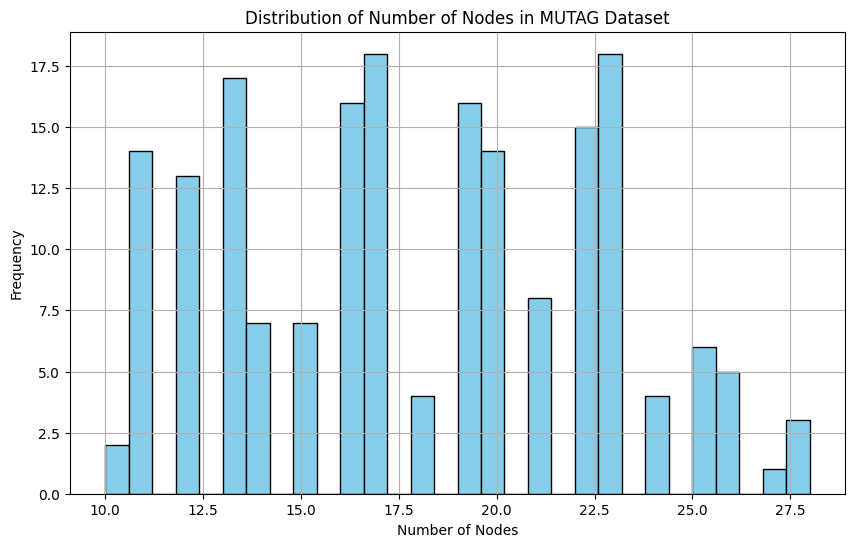

Small graphs: 188
Medium graphs: 0
Large graphs: 0


In [2]:
dataset = TUDataset(
    root="data", name="MUTAG", use_node_attr=True, transform=NormalizeFeatures()
)

small_graphs, medium_graphs, large_graphs, classes = analyze_dataset(dataset, 10, 20)

In [3]:
print(dataset[0].x)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])


In [4]:
data = [graph for graph in dataset if 10 <= graph.num_nodes <= 20]

In [5]:
def train(model, optimizer, pairs, labels, batch_size, title=""):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2, _, _ = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        losses.append(loss)
        accs.append(acc)

        if i % batch_size == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()

    plt.figure(figsize=(12, 5))

    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [6]:
def test(model, title="", layers=3, num_classes=2, n=0, k=None):
    class_clusters = []
    class_accs = []
    class_circles = []
    for i in range(num_classes):
        c = f"class_{str(i)}"
        idx1 = random.sample(range(len(classes[c])), 1)[0]
        idx2 = random.sample(range(len(classes[c])), 1)[0]
        graph1, graph2 = classes[c][idx1], classes[c][idx2]

        model.eval()

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([len(graph1.x)])
        sizes_2 = torch.tensor([len(graph2.x)])
        _, _, cluster1, cluster2 = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2, k
        )

        clusters = []
        accs = []
        circles = []

        for i in range(len(model.topk_outputs)):
            (
                (x_pooled_1, edge_index_pooled_1, perm1, x_pooled_perm_1),
                (x_pooled_2, edge_index_pooled_2, perm2, x_pooled_perm_2),
            ) = model.topk_outputs[i]
            clusters.append(
                (
                    Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
                    Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
                )
            )
            print(f"Perm: {(perm1, perm2)}")
            accs.append(
                (
                    len(set(range(8)) & set(perm1.tolist())),
                    len(set(range(8)) & set(perm2.tolist())),
                )
            )
            # circles.append(
            #     (
            #         len(
            #             list(
            #                 nx.simple_cycles(
            #                     to_networkx(
            #                         Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
            #                         to_undirected=True,
            #                     )
            #                 )
            #             )
            #         ),
            #         len(
            #             list(
            #                 nx.simple_cycles(
            #                     to_networkx(
            #                         Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
            #                         to_undirected=True,
            #                     )
            #                 )
            #             )
            #         ),
            #     )
            # )

        acc = list(itertools.chain.from_iterable(zip(*accs)))
        class_accs.extend(acc)

        cs = list(itertools.chain.from_iterable(zip(*clusters)))
        class_clusters.extend(cs)

        # c = list(itertools.chain.from_iterable(zip(*circles)))
        # class_circles.extend(c)

    plot_all_classes(class_clusters, class_accs, title, layers, num_classes)

In [7]:
hyperparameters_mutag = [
    (32, 3, 0.2, 0.001, 64, 500),
    (32, 3, 0.4, 0.01, 16, 1000),
    (32, 3, 0.4, 0.01, 32, 1000),
    (32, 3, 0.4, 0.01, 64, 3000),
    (32, 3, 0.5, 0.01, 64, 1000),
    (32, 3, 0.5, 0.01, 128, 3000),
    (32, 3, 0.5, 0.001, 64, 3000),
    (32, 4, 0.1, 0.01, 16, 500),
    (32, 4, 0.1, 0.001, 32, 1000),
    (32, 4, 0.3, 0.0001, 16, 500),
    (32, 4, 0.4, 0.001, 32, 1000),
    (32, 4, 0.5, 0.01, 32, 500),
    (32, 4, 0.5, 0.01, 64, 1000),
    (32, 4, 0.5, 0.01, 128, 2000),
    (32, 4, 0.5, 0.01, 128, 3000),
    (32, 4, 0.5, 0.001, 64, 2000),
    (32, 4, 1, 0.01, 32, 500),
    (32, 4, 1, 0.01, 128, 2000),
    (32, 5, 0.2, 0.0001, 64, 1000),
    (32, 5, 0.1, 0.01, 64, 1000),
    (32, 4, 1, 0.01, 128, 2000),
    (32, 5, 1, 0.001, 64, 2000),
    (32, 6, 0.2, 0.001, 16, 2000),
    (32, 7, 0.2, 0.001, 16, 500),
    (32, 7, 0.4, 0.001, 64, 500),
    (32, 7, 0.4, 0.001, 128, 1000),
    (32, 8, 0.2, 0.001, 64, 2000),
    (32, 8, 0.5, 0.01, 64, 3000),
]

In [8]:
hyperparameters_enzymes = [
    (16, 3, 0.3, 0.01, 128, 10000),
    (16, 3, 0.3, 0.01, 256, 2500),
    (16, 3, 0.5, 0.01, 128, 10000),
    (16, 3, 0.5, 0.01, 256, 10000),
    (16, 4, 0.3, 0.01, 128, 10000),
    (16, 4, 0.3, 0.01, 256, 10000),
    (16, 4, 0.3, 0.001, 256, 10000),
    (16, 4, 0.5, 0.01, 128, 10000),
    (16, 4, 0.5, 0.001, 256, 10000),
    (16, 4, 1, 0.001, 128, 10000),
    (16, 5, 0.3, 0.01, 256, 10000),
    (16, 5, 0.5, 0.01, 256, 10000),
    (16, 6, 0.3, 0.01, 256, 10000),
    (16, 6, 0.3, 0.001, 256, 10000),
    (16, 6, 0.5, 0.01, 256, 10000),
    (16, 7, 0.3, 0.01, 256, 10000),
    (16, 8, 0.3, 0.01, 256, 10000),
    (16, 8, 0.5, 0.01, 256, 10000),
    (32, 4, 0.1, 0.01, 256, 10000),
    (32, 4, 0.3, 0.01, 256, 10000),
    (32, 4, 0.3, 0.001, 256, 10000),
    (32, 4, 0.5, 0.01, 256, 10000),
    (32, 5, 0.1, 0.01, 256, 10000),
    (32, 5, 0.1, 0.001, 256, 10000),
    (32, 6, 0.5, 0.01, 256, 10000),
    (32, 8, 0.3, 0.01, 256, 10000),
]

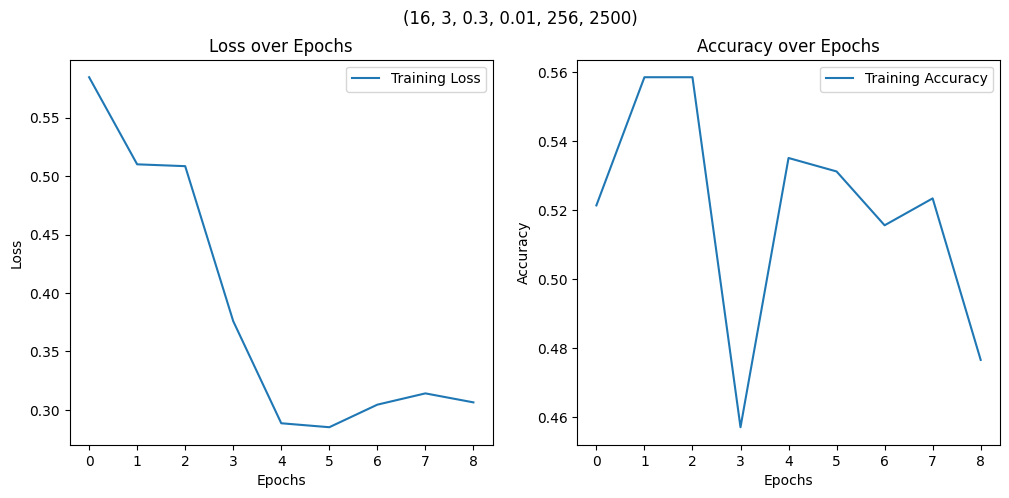

3
Perm: (tensor([12, 11,  8]), tensor([9, 8, 2]))
Perm: (tensor([12, 11,  0]), tensor([9, 8, 0]))
Perm: (tensor([8, 4, 6]), tensor([10,  6,  2]))
Perm: (tensor([19, 18, 17]), tensor([16, 15, 14]))
Perm: (tensor([ 5, 11,  4]), tensor([12,  0, 11]))
Perm: (tensor([ 7,  8, 13]), tensor([9, 2, 3]))


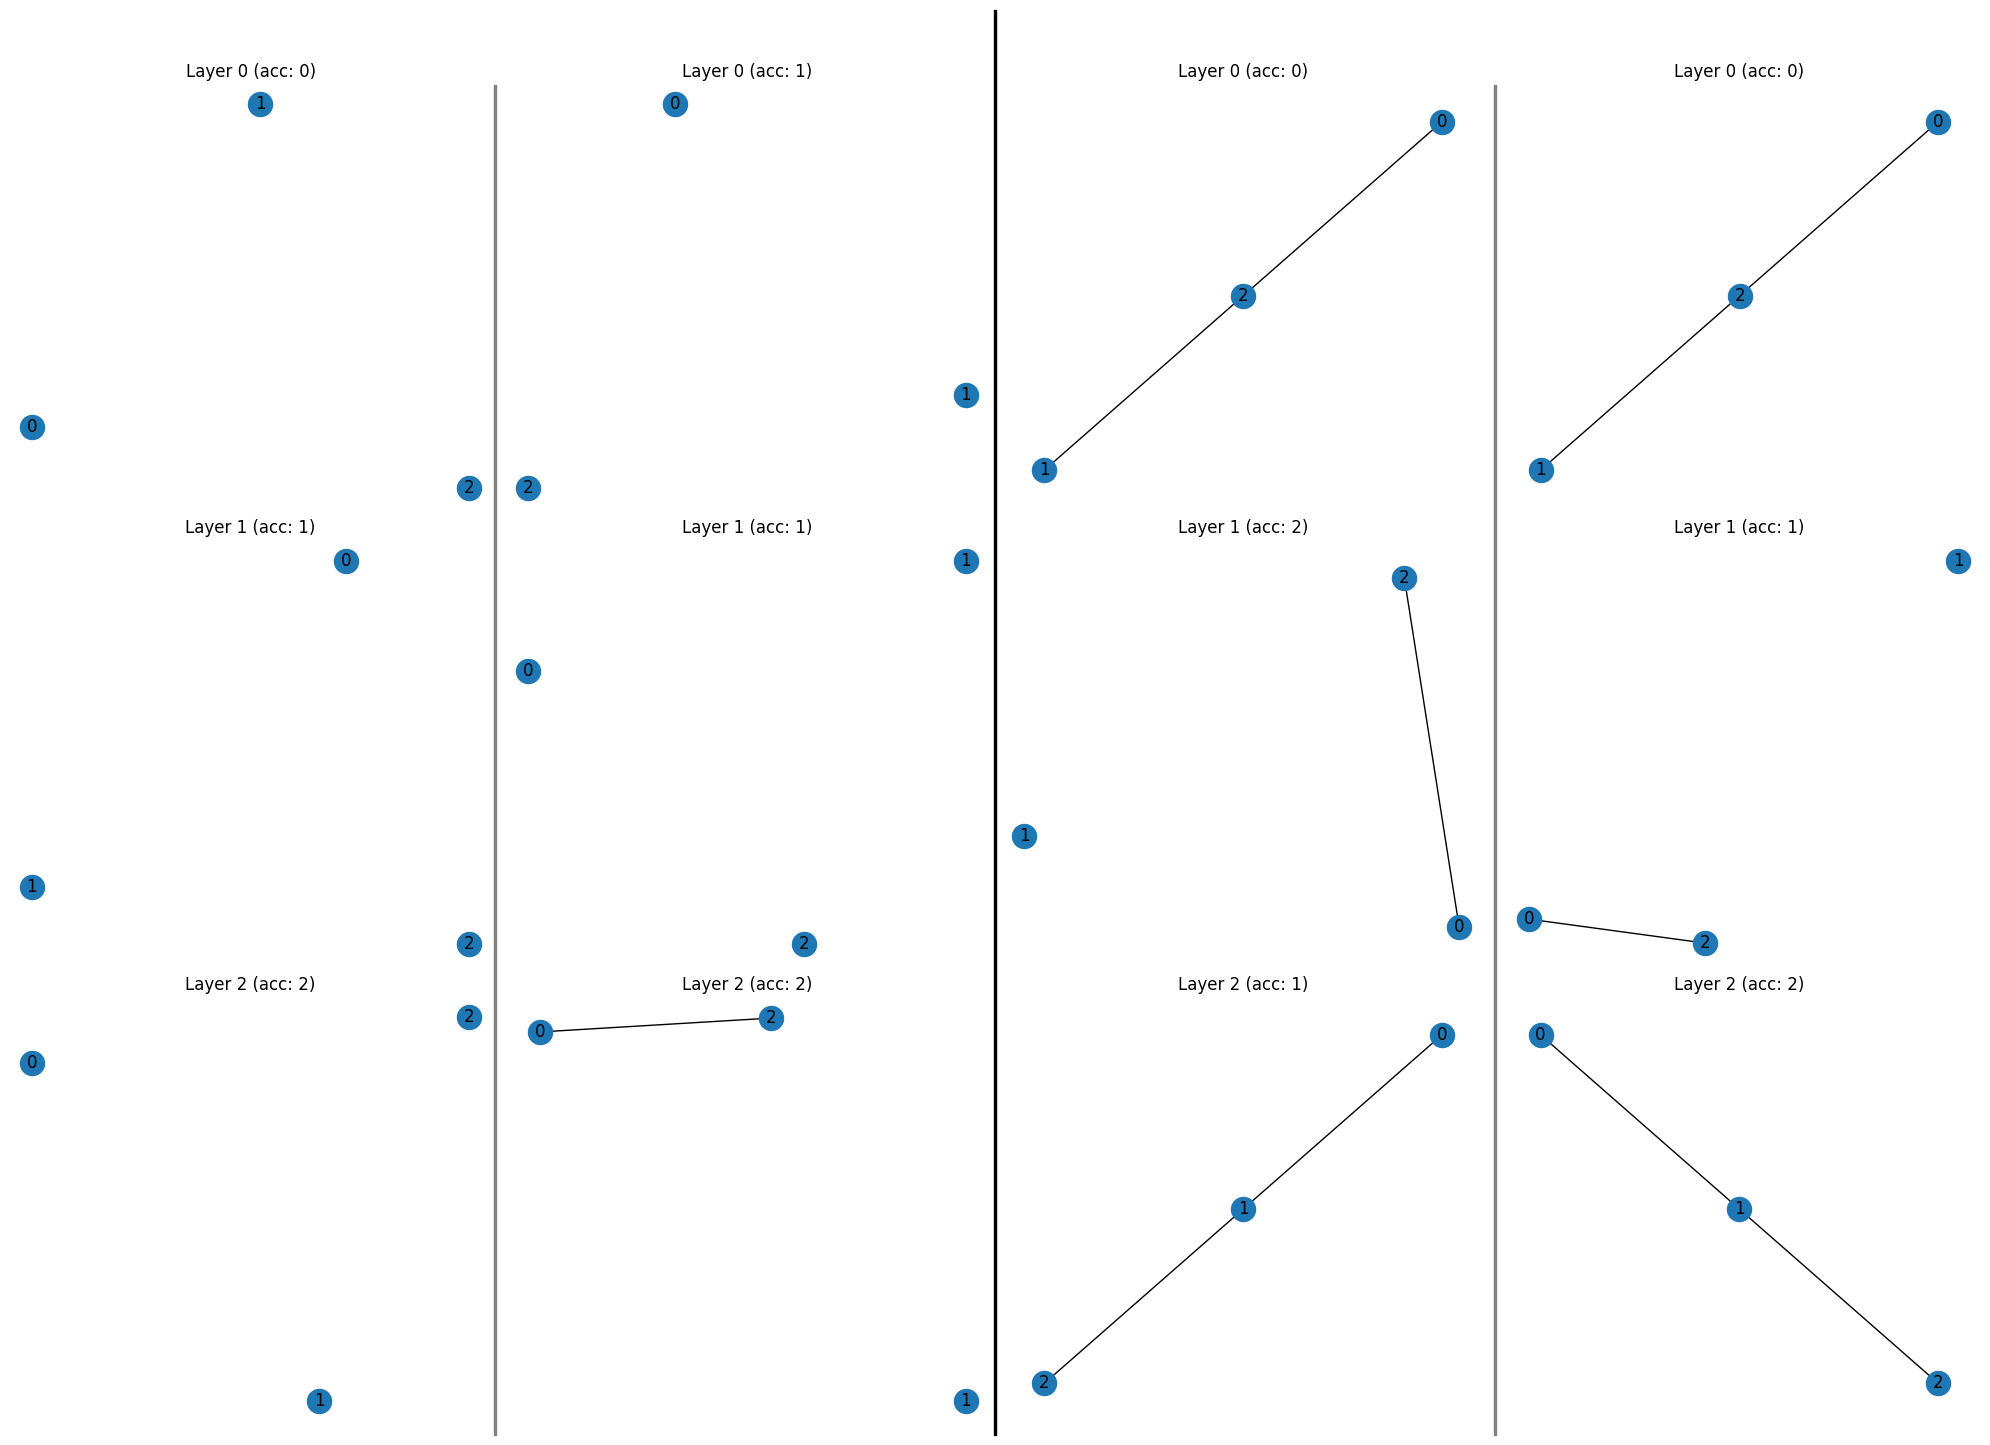

Perm: (tensor([6, 9, 0]), tensor([10,  1,  0]))
Perm: (tensor([12, 11, 10]), tensor([ 5,  3, 12]))
Perm: (tensor([11,  8, 10]), tensor([11, 12,  5]))
Perm: (tensor([7, 8, 2]), tensor([2, 5, 0]))
Perm: (tensor([3, 2, 4]), tensor([2, 5, 6]))
Perm: (tensor([ 7, 12, 11]), tensor([2, 5, 0]))


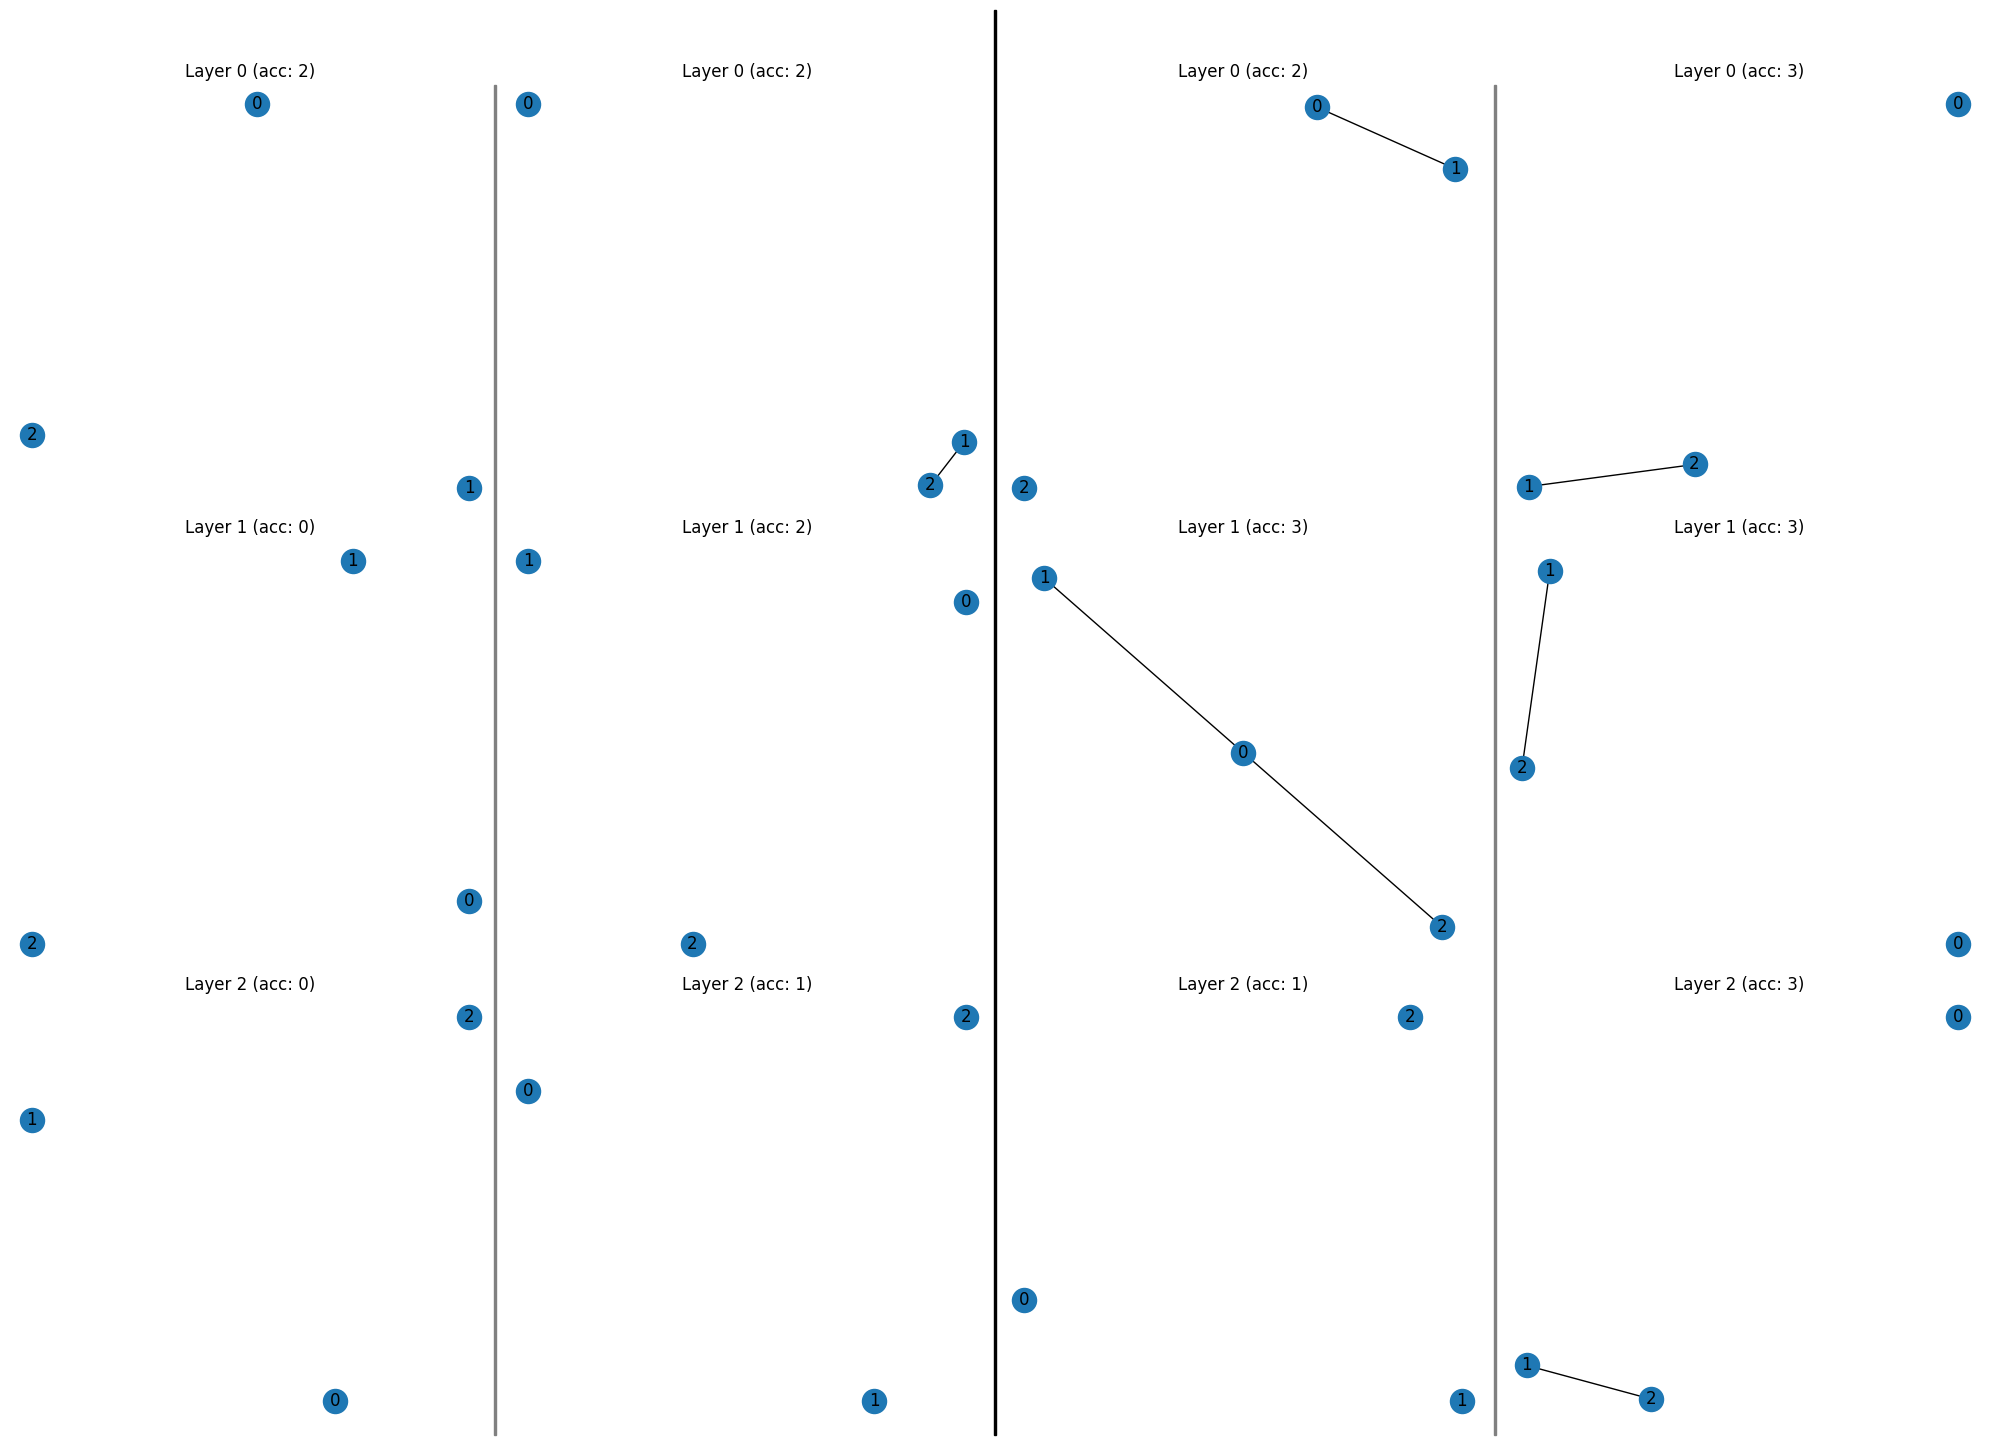

Perm: (tensor([3, 8, 7]), tensor([5, 6, 4]))
Perm: (tensor([3, 6, 1]), tensor([7, 5, 4]))
Perm: (tensor([ 2, 11, 10]), tensor([ 1,  0, 10]))
Perm: (tensor([6, 5, 9]), tensor([6, 5, 9]))
Perm: (tensor([15, 14, 13]), tensor([17, 13, 16]))
Perm: (tensor([12, 14, 13]), tensor([15, 12, 17]))


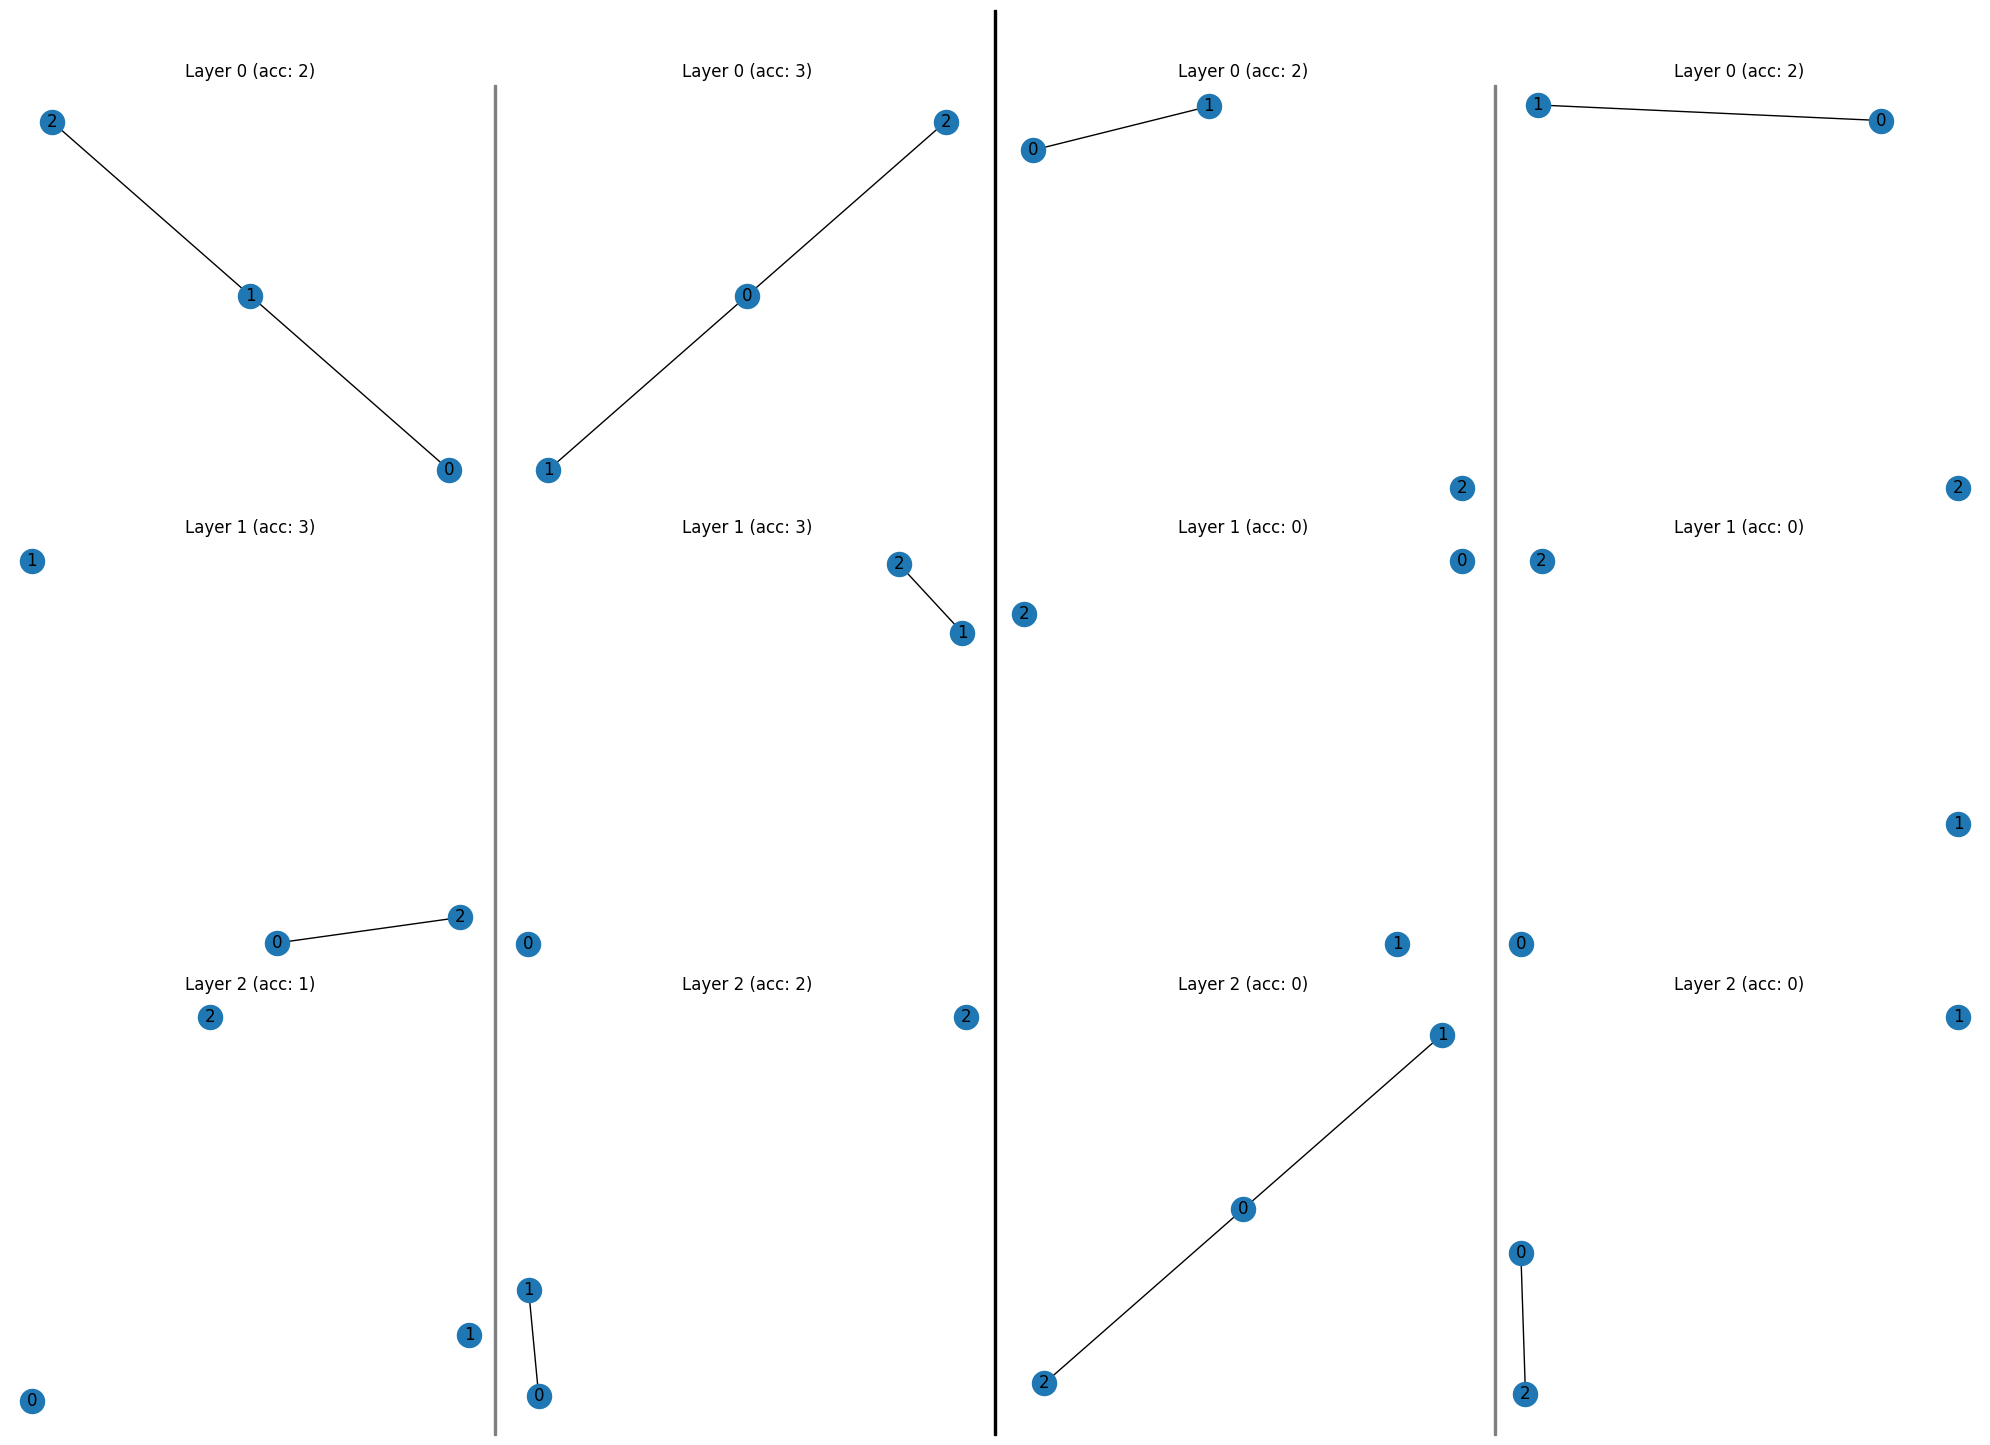

Perm: (tensor([10,  6,  9]), tensor([8, 7, 6]))
Perm: (tensor([2, 4, 3]), tensor([2, 3, 5]))
Perm: (tensor([3, 7, 0]), tensor([6, 5, 8]))
Perm: (tensor([16, 15, 14]), tensor([13, 16, 15]))
Perm: (tensor([ 0,  1, 12]), tensor([0, 1, 2]))
Perm: (tensor([4, 8, 9]), tensor([12, 13, 11]))


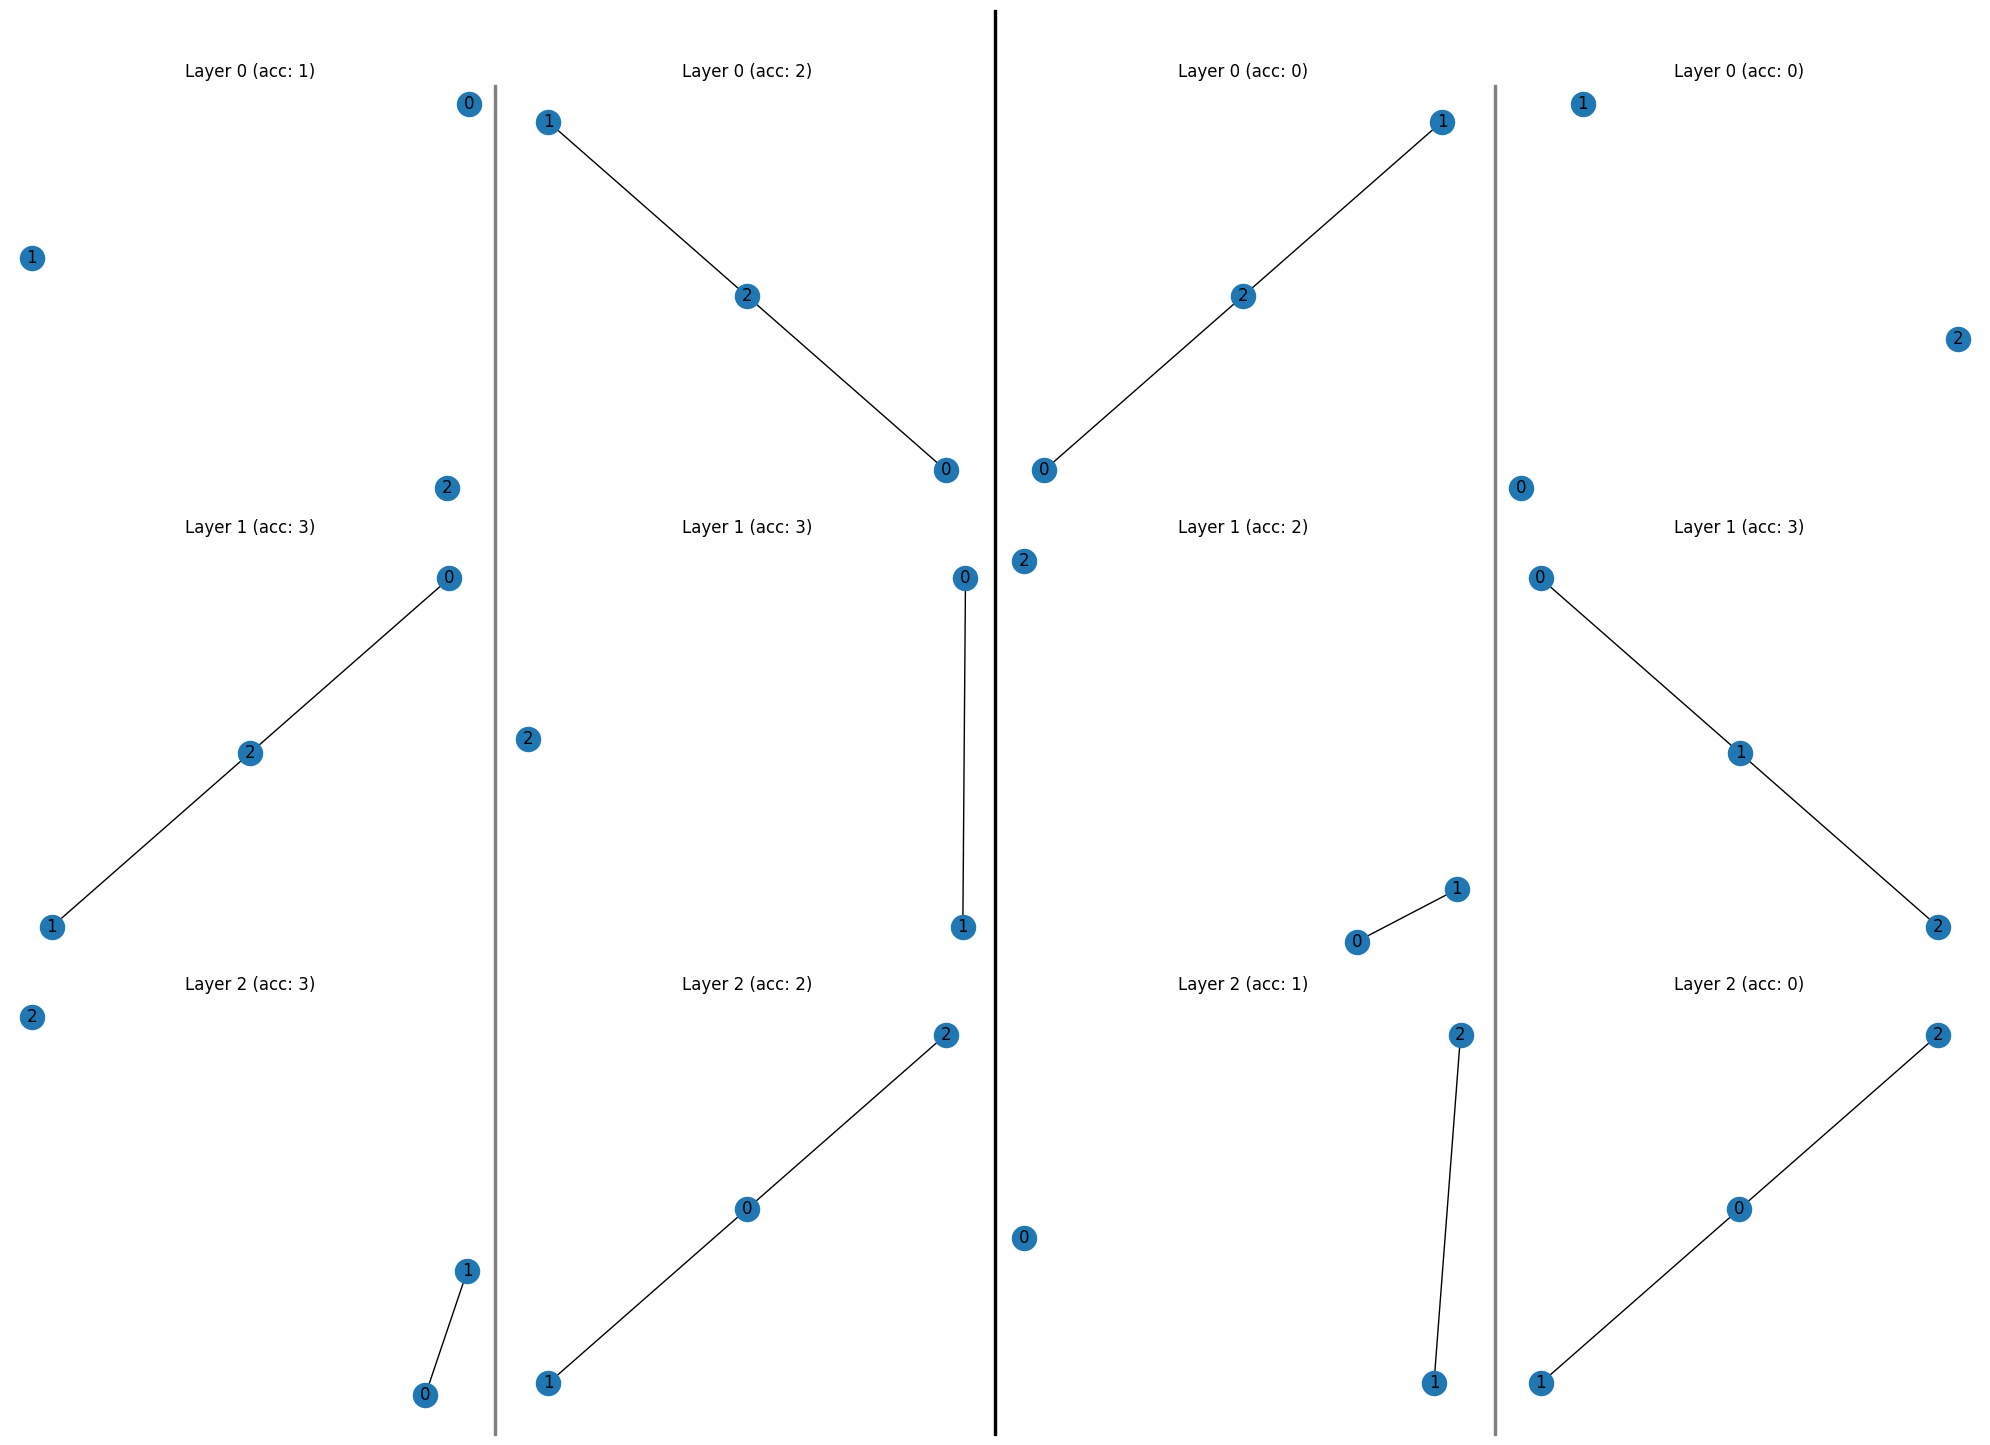

Perm: (tensor([10,  6,  1]), tensor([2, 3, 5]))
Perm: (tensor([1, 7, 6]), tensor([1, 0, 4]))
Perm: (tensor([6, 7, 1]), tensor([12, 11,  9]))
Perm: (tensor([8, 9, 3]), tensor([10,  9,  2]))
Perm: (tensor([16, 15,  7]), tensor([19, 18, 16]))
Perm: (tensor([14,  7, 16]), tensor([17,  8, 19]))


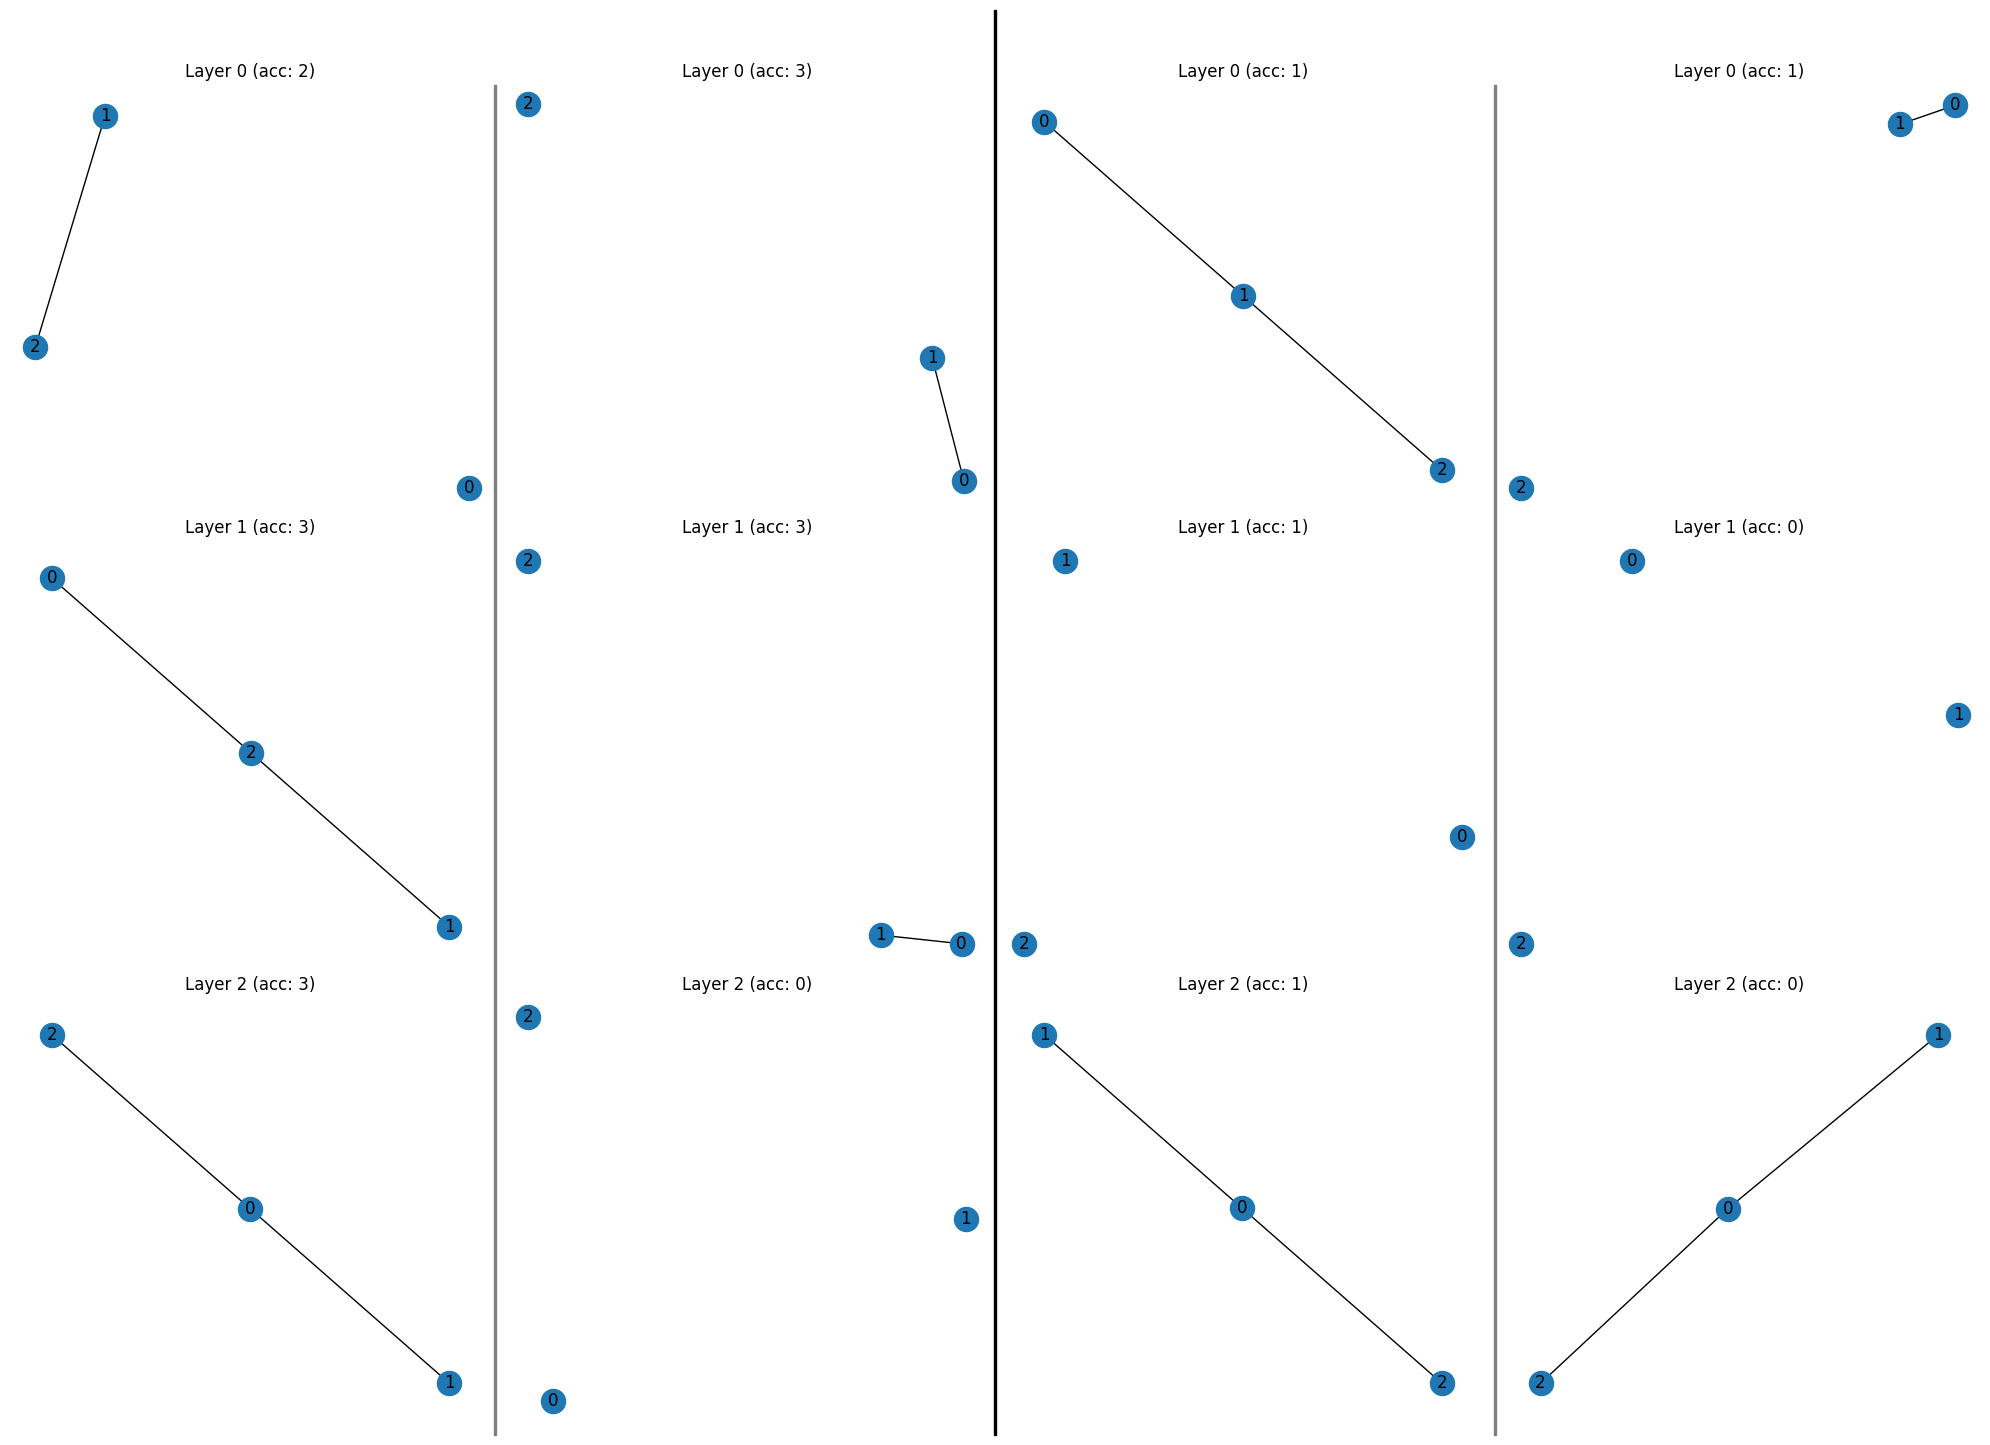

Perm: (tensor([7, 4, 2]), tensor([8, 1, 3]))
Perm: (tensor([12, 11,  7]), tensor([13, 12,  1]))
Perm: (tensor([ 9, 10, 12]), tensor([13, 12,  6]))
Perm: (tensor([ 6, 16, 12]), tensor([ 6,  5, 16]))
Perm: (tensor([18, 17,  8]), tensor([14,  4, 15]))
Perm: (tensor([9, 3, 2]), tensor([11,  2, 10]))


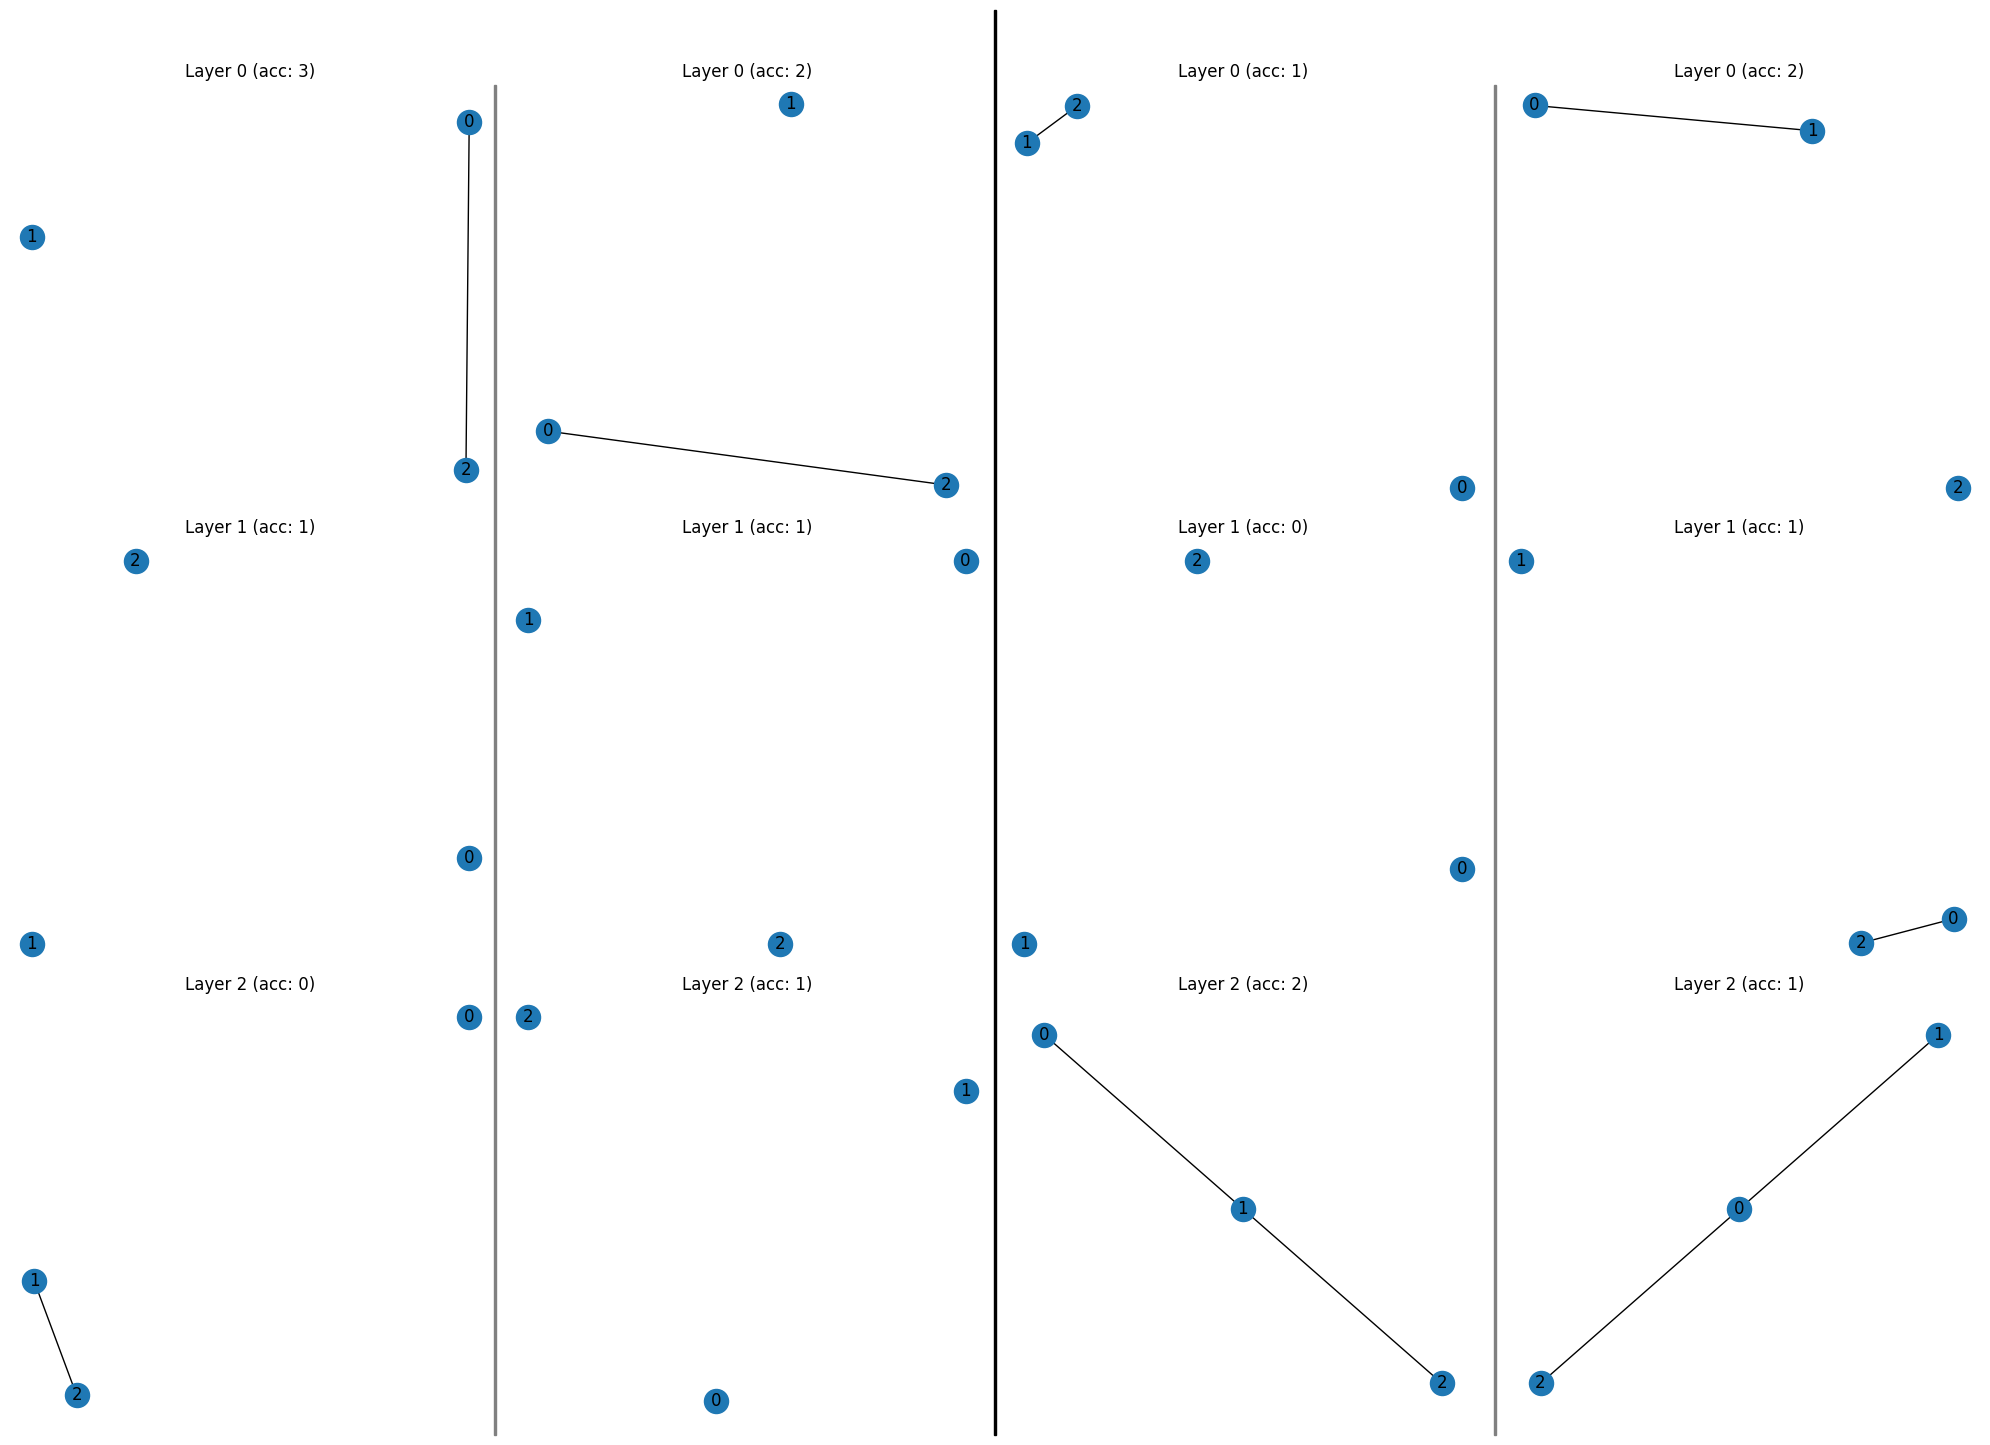

Perm: (tensor([ 1, 10,  5]), tensor([ 7, 10,  5]))
Perm: (tensor([10,  1,  2]), tensor([ 7, 10,  0]))
Perm: (tensor([12, 11,  7]), tensor([5, 6, 0]))
Perm: (tensor([ 6, 12,  2]), tensor([15,  5,  2]))
Perm: (tensor([16,  5, 11]), tensor([10, 12,  2]))
Perm: (tensor([ 8, 16,  0]), tensor([10, 19, 18]))


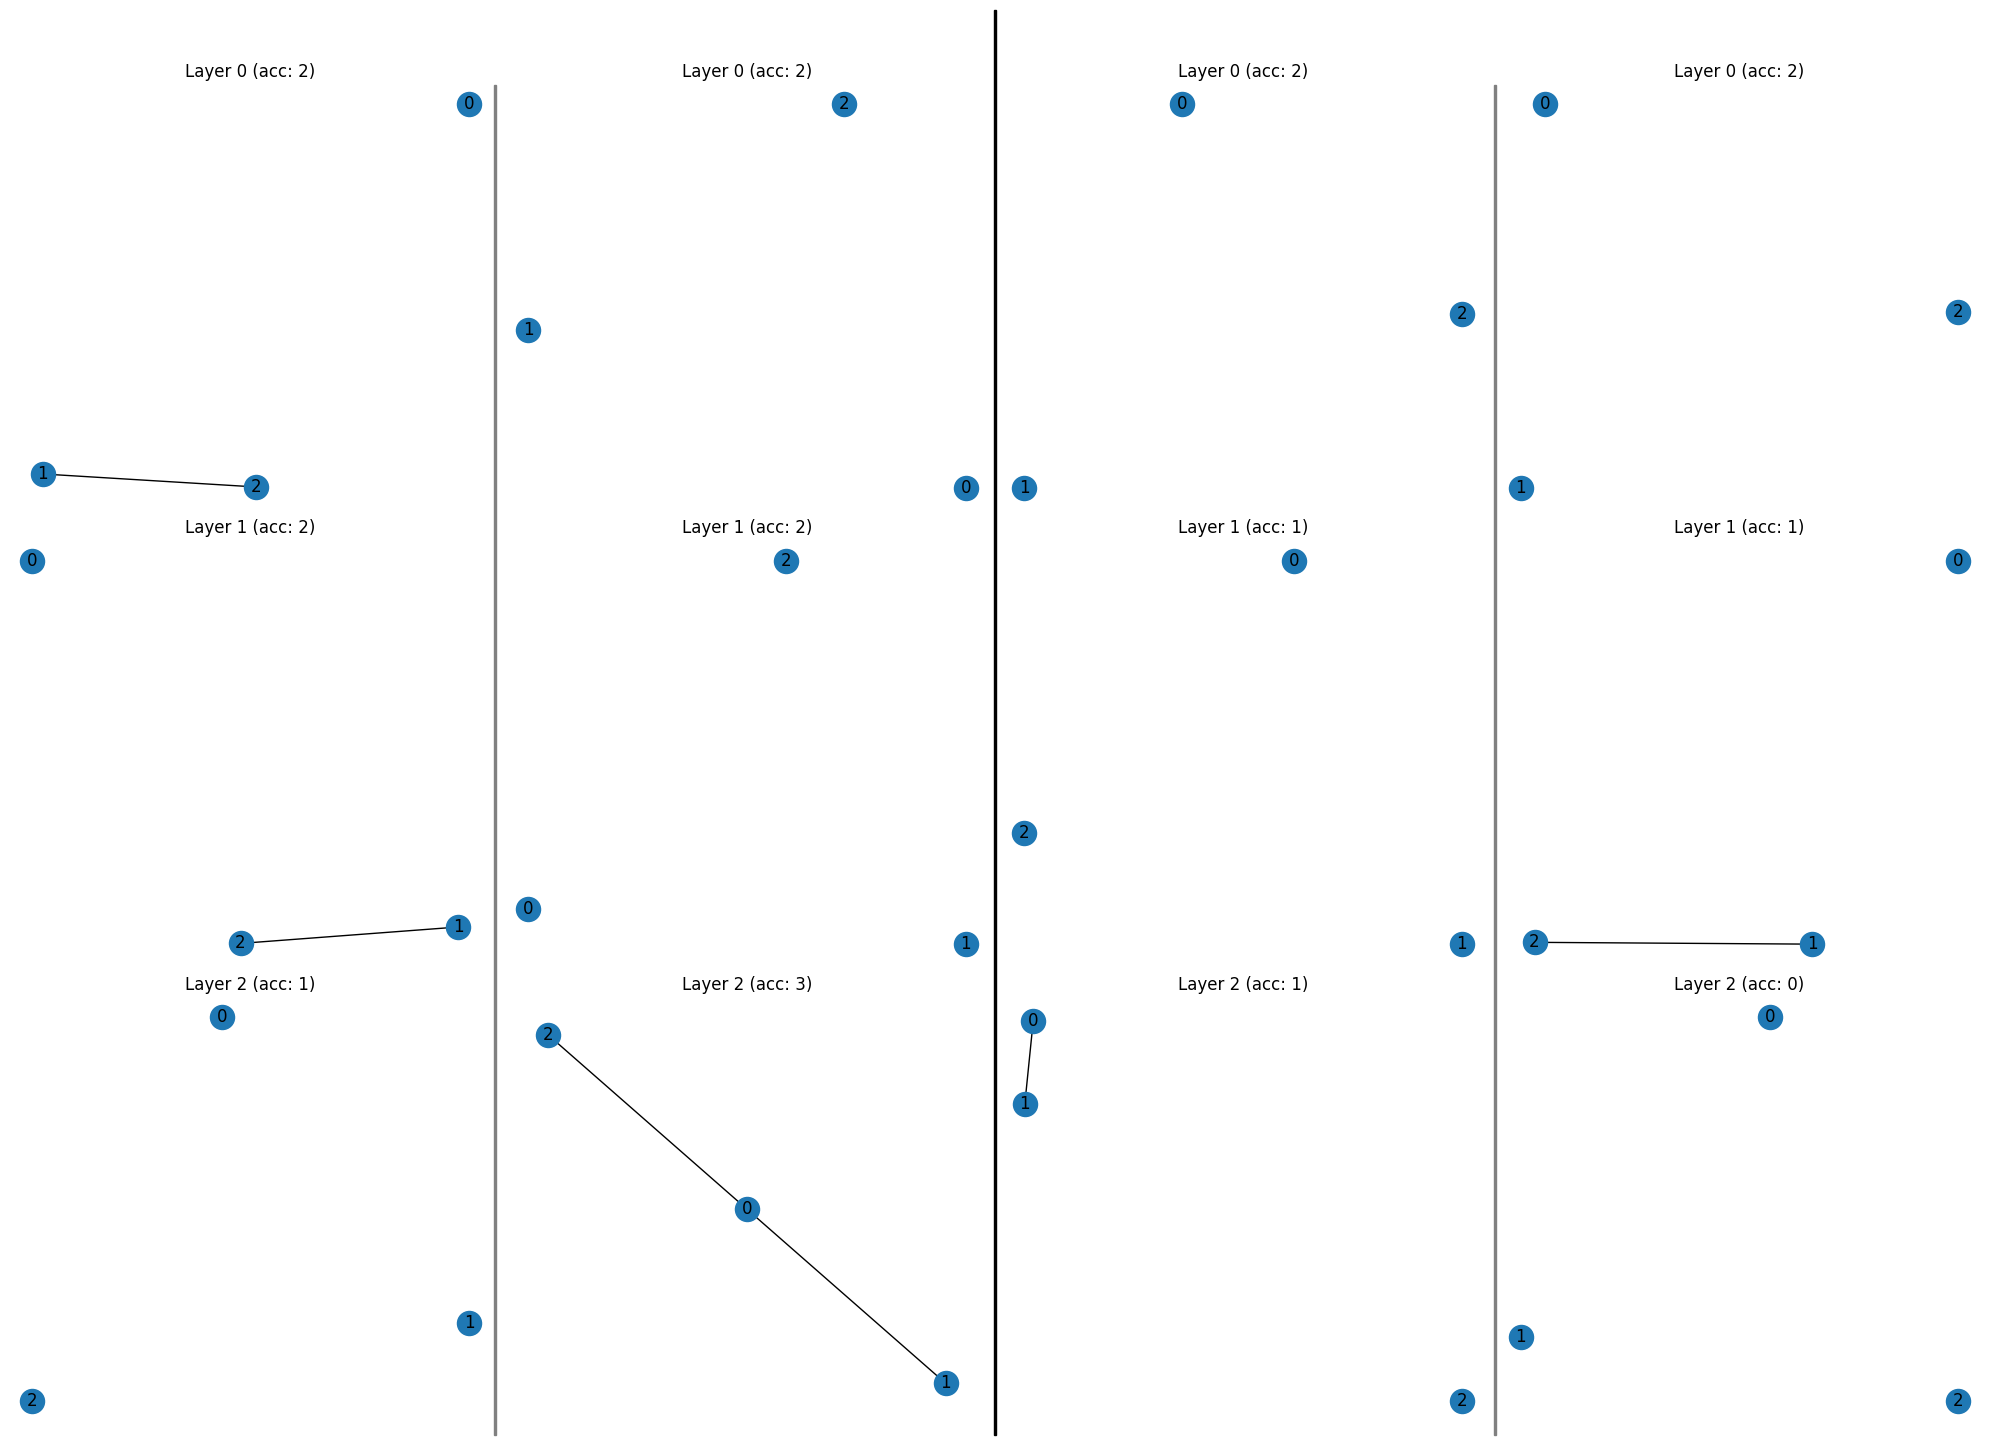

Perm: (tensor([7, 2, 8]), tensor([6, 3, 9]))
Perm: (tensor([1, 9, 6]), tensor([12,  7,  2]))
Perm: (tensor([ 8, 11, 12]), tensor([9, 6, 3]))
Perm: (tensor([2, 3, 5]), tensor([7, 2, 8]))
Perm: (tensor([5, 3, 1]), tensor([2, 8, 6]))
Perm: (tensor([ 9,  6, 10]), tensor([13, 10,  8]))


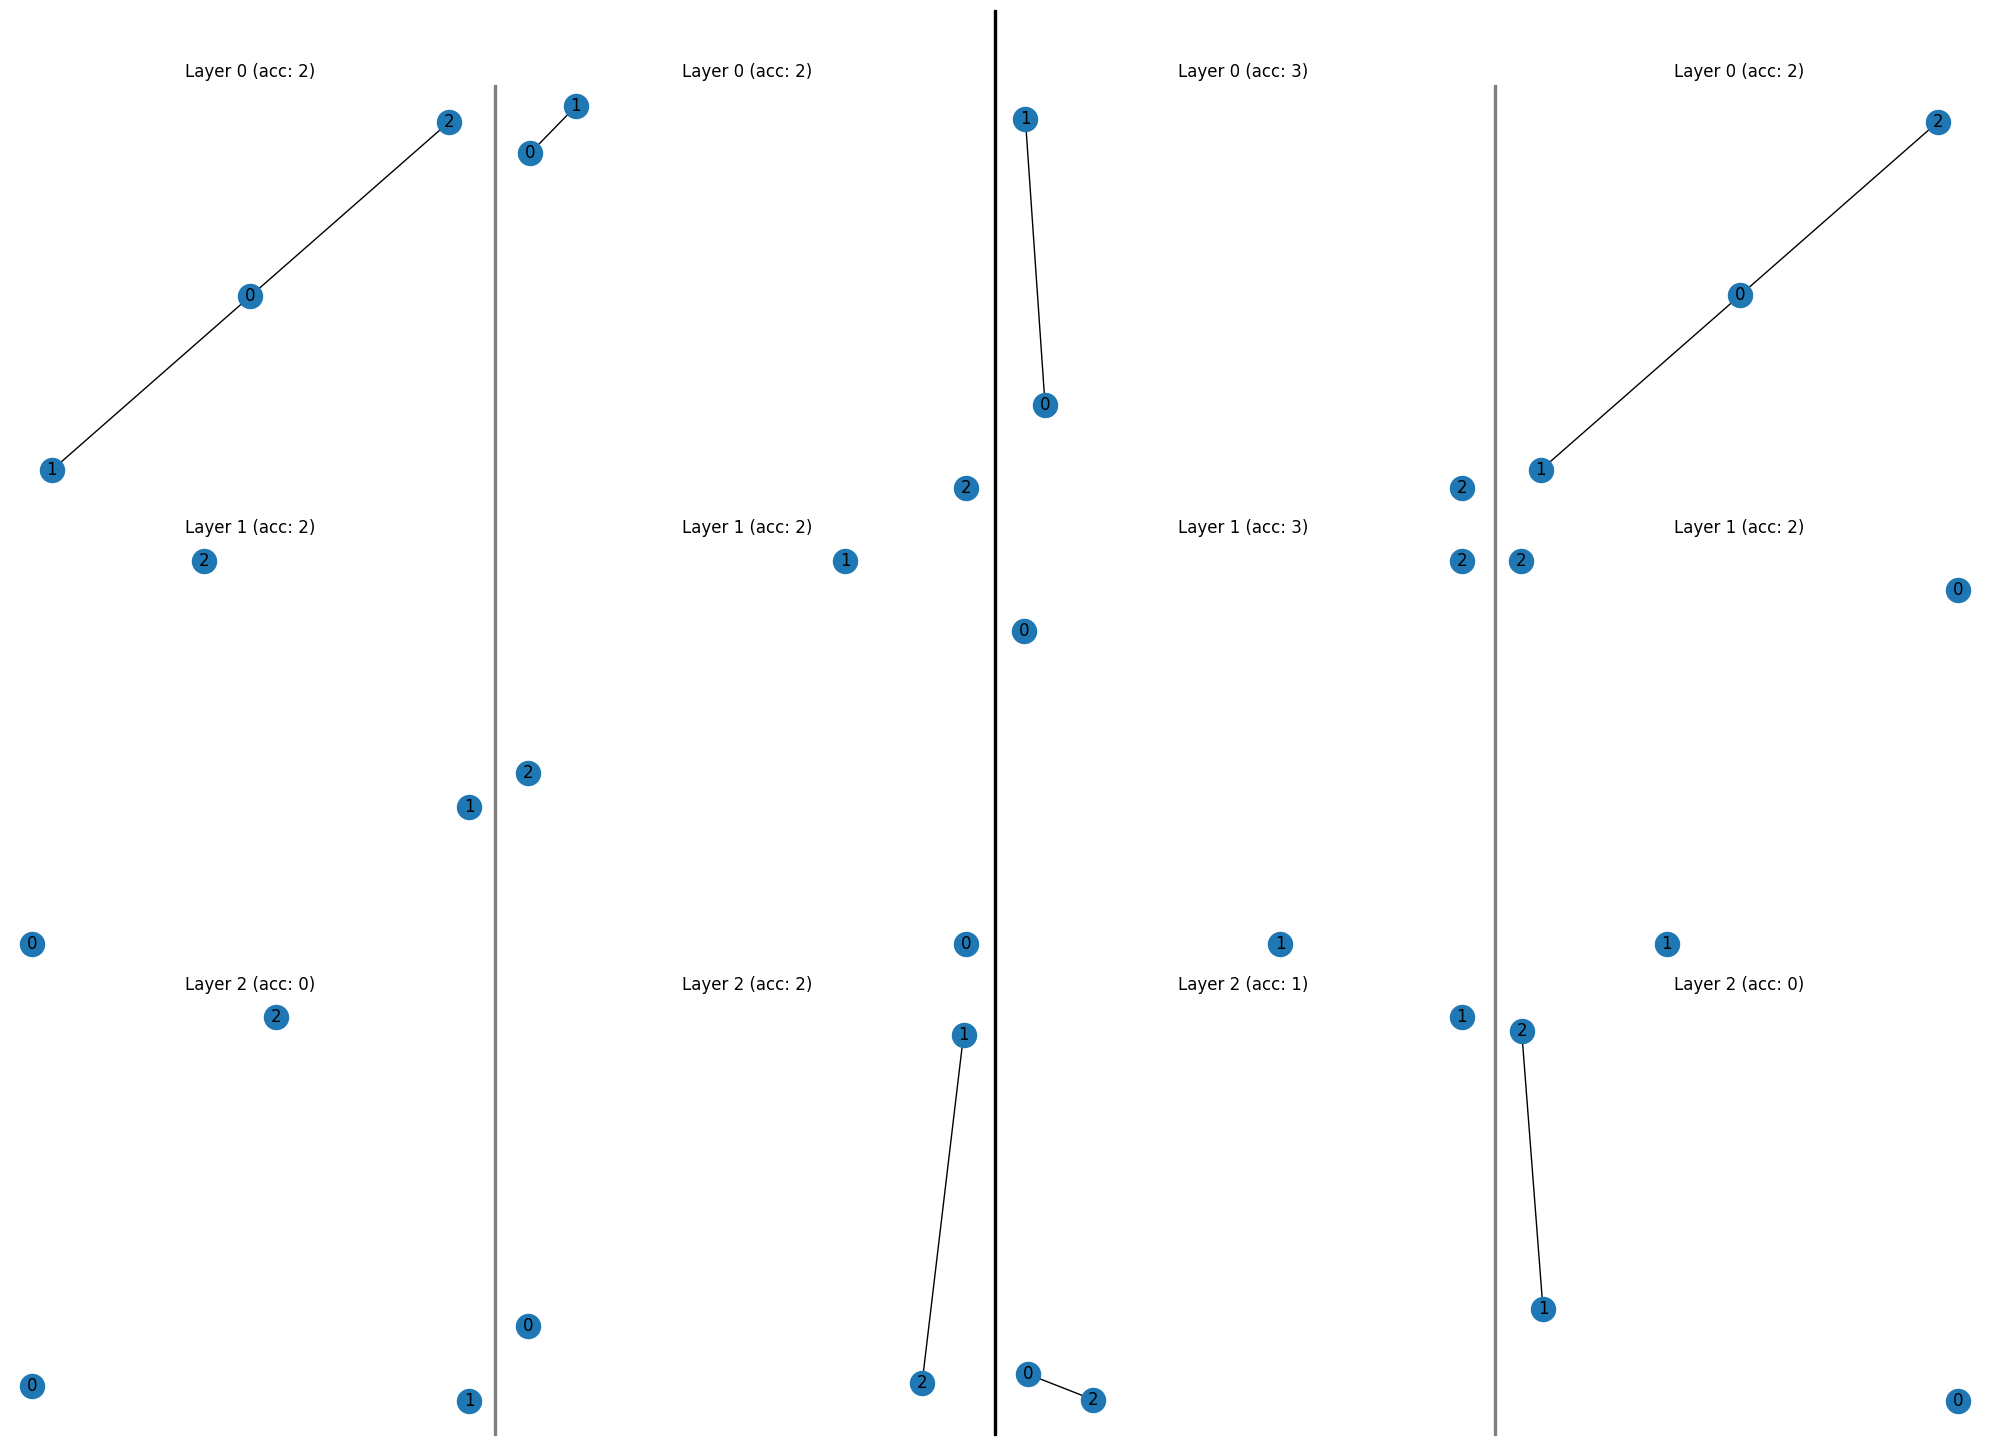

Perm: (tensor([3, 2, 5]), tensor([ 1, 10,  3]))
Perm: (tensor([2, 3, 1]), tensor([ 3, 10,  1]))
Perm: (tensor([7, 9, 8]), tensor([7, 6, 1]))
Perm: (tensor([3, 9, 2]), tensor([12,  5,  3]))
Perm: (tensor([17, 11,  4]), tensor([6, 9, 4]))
Perm: (tensor([16,  0, 15]), tensor([ 2, 12,  1]))


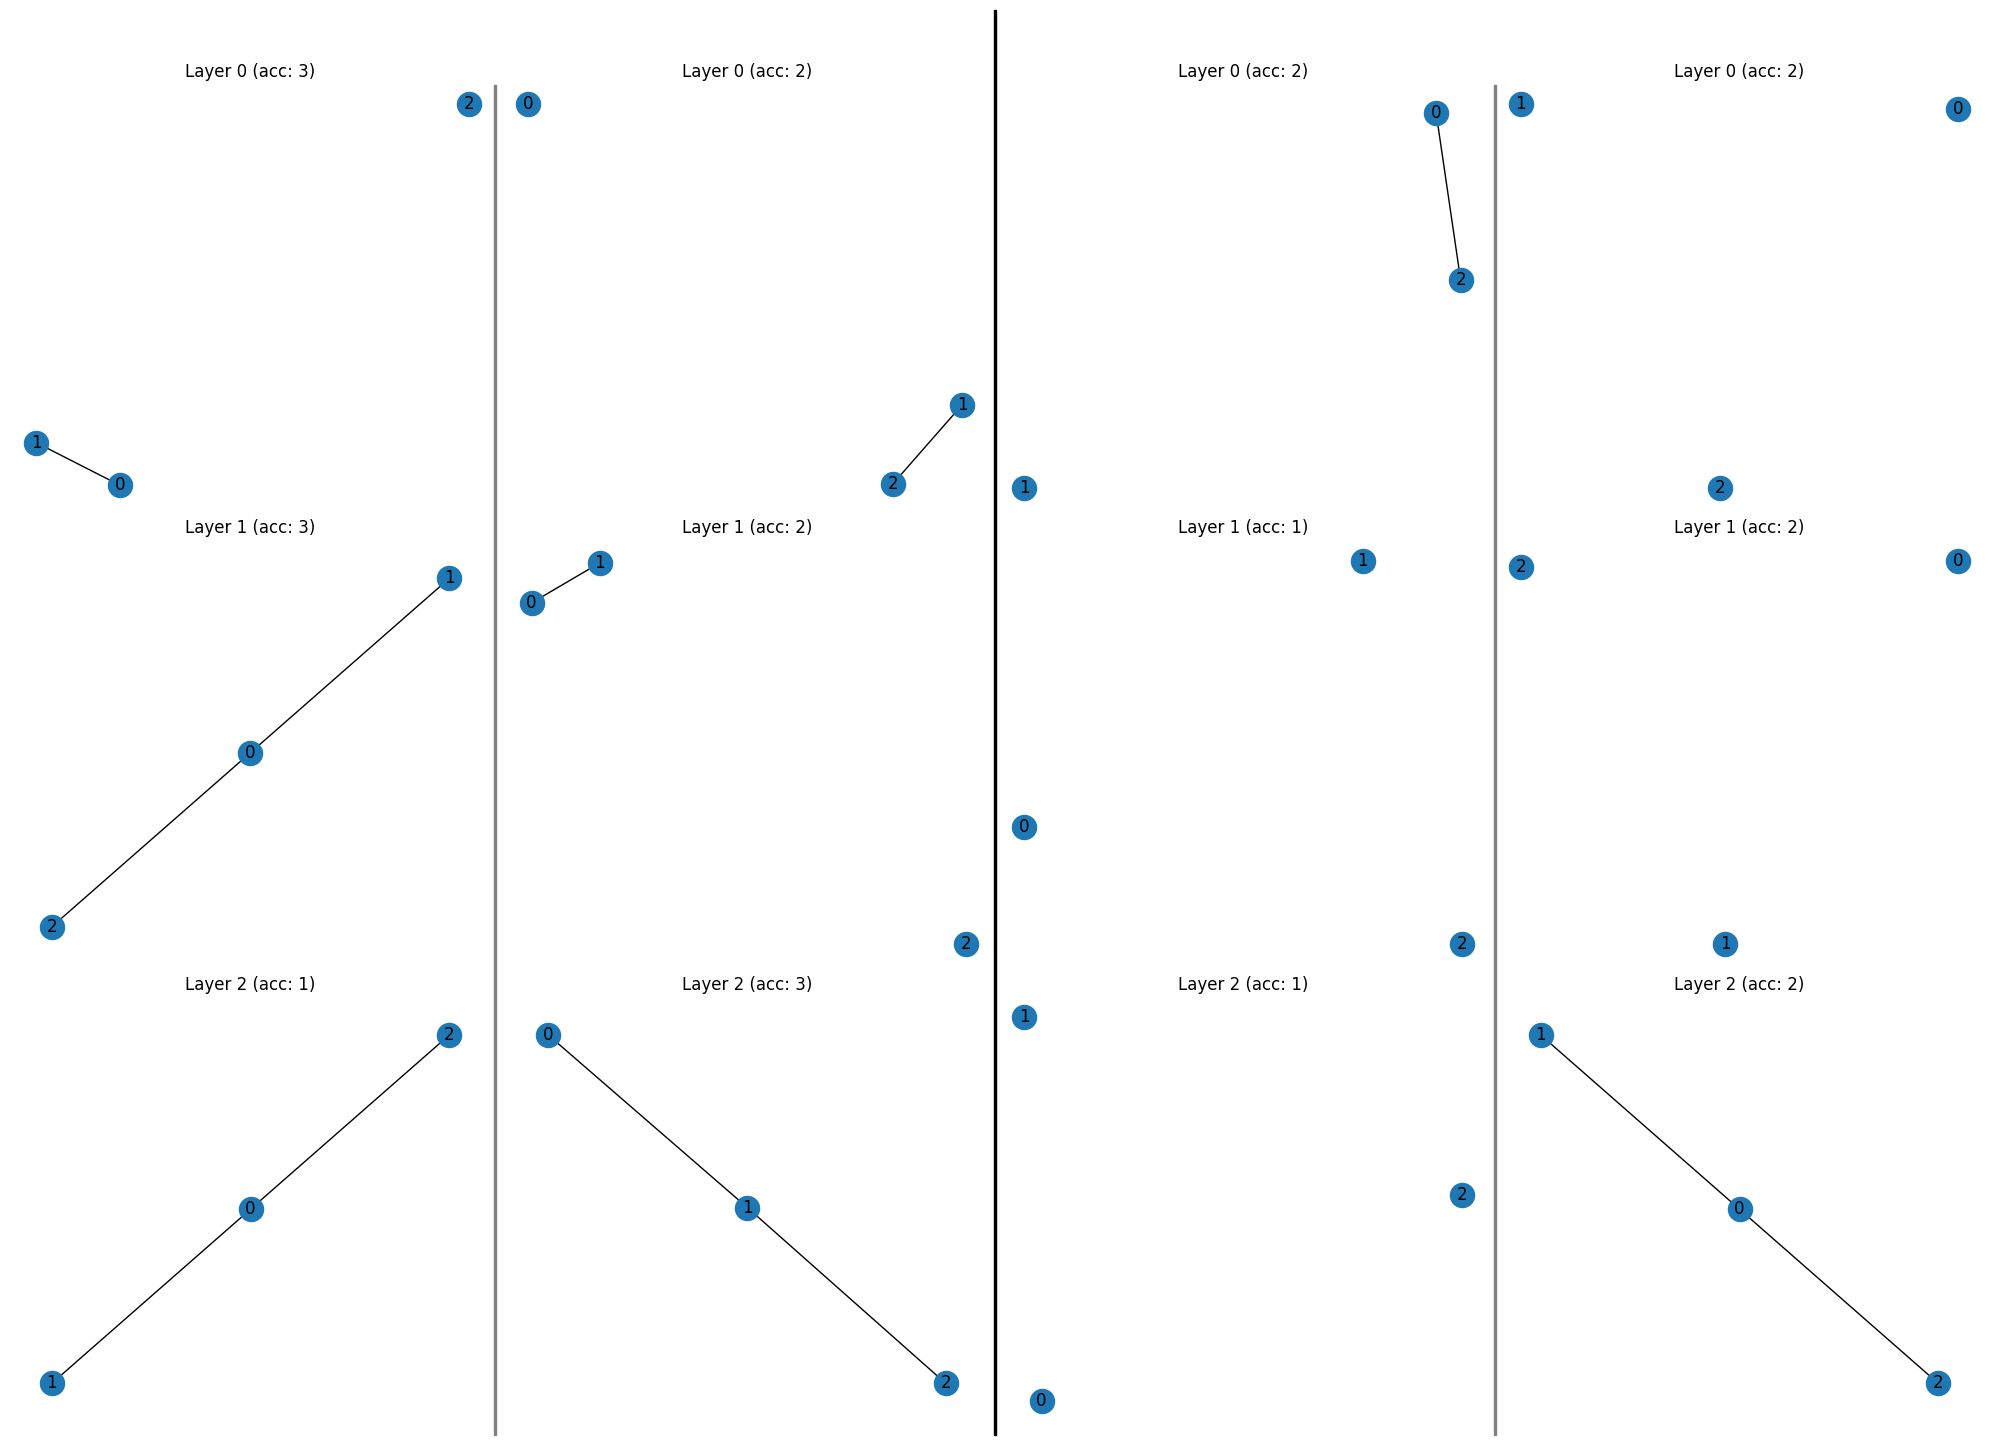

Perm: (tensor([13, 10,  6]), tensor([13, 10,  3]))
Perm: (tensor([13,  3,  4]), tensor([13,  1,  0]))
Perm: (tensor([15, 14,  1]), tensor([10, 12, 15]))
Perm: (tensor([16, 19, 18]), tensor([ 8,  7, 11]))
Perm: (tensor([9, 6, 3]), tensor([5, 2, 3]))
Perm: (tensor([19, 18, 16]), tensor([6, 8, 7]))


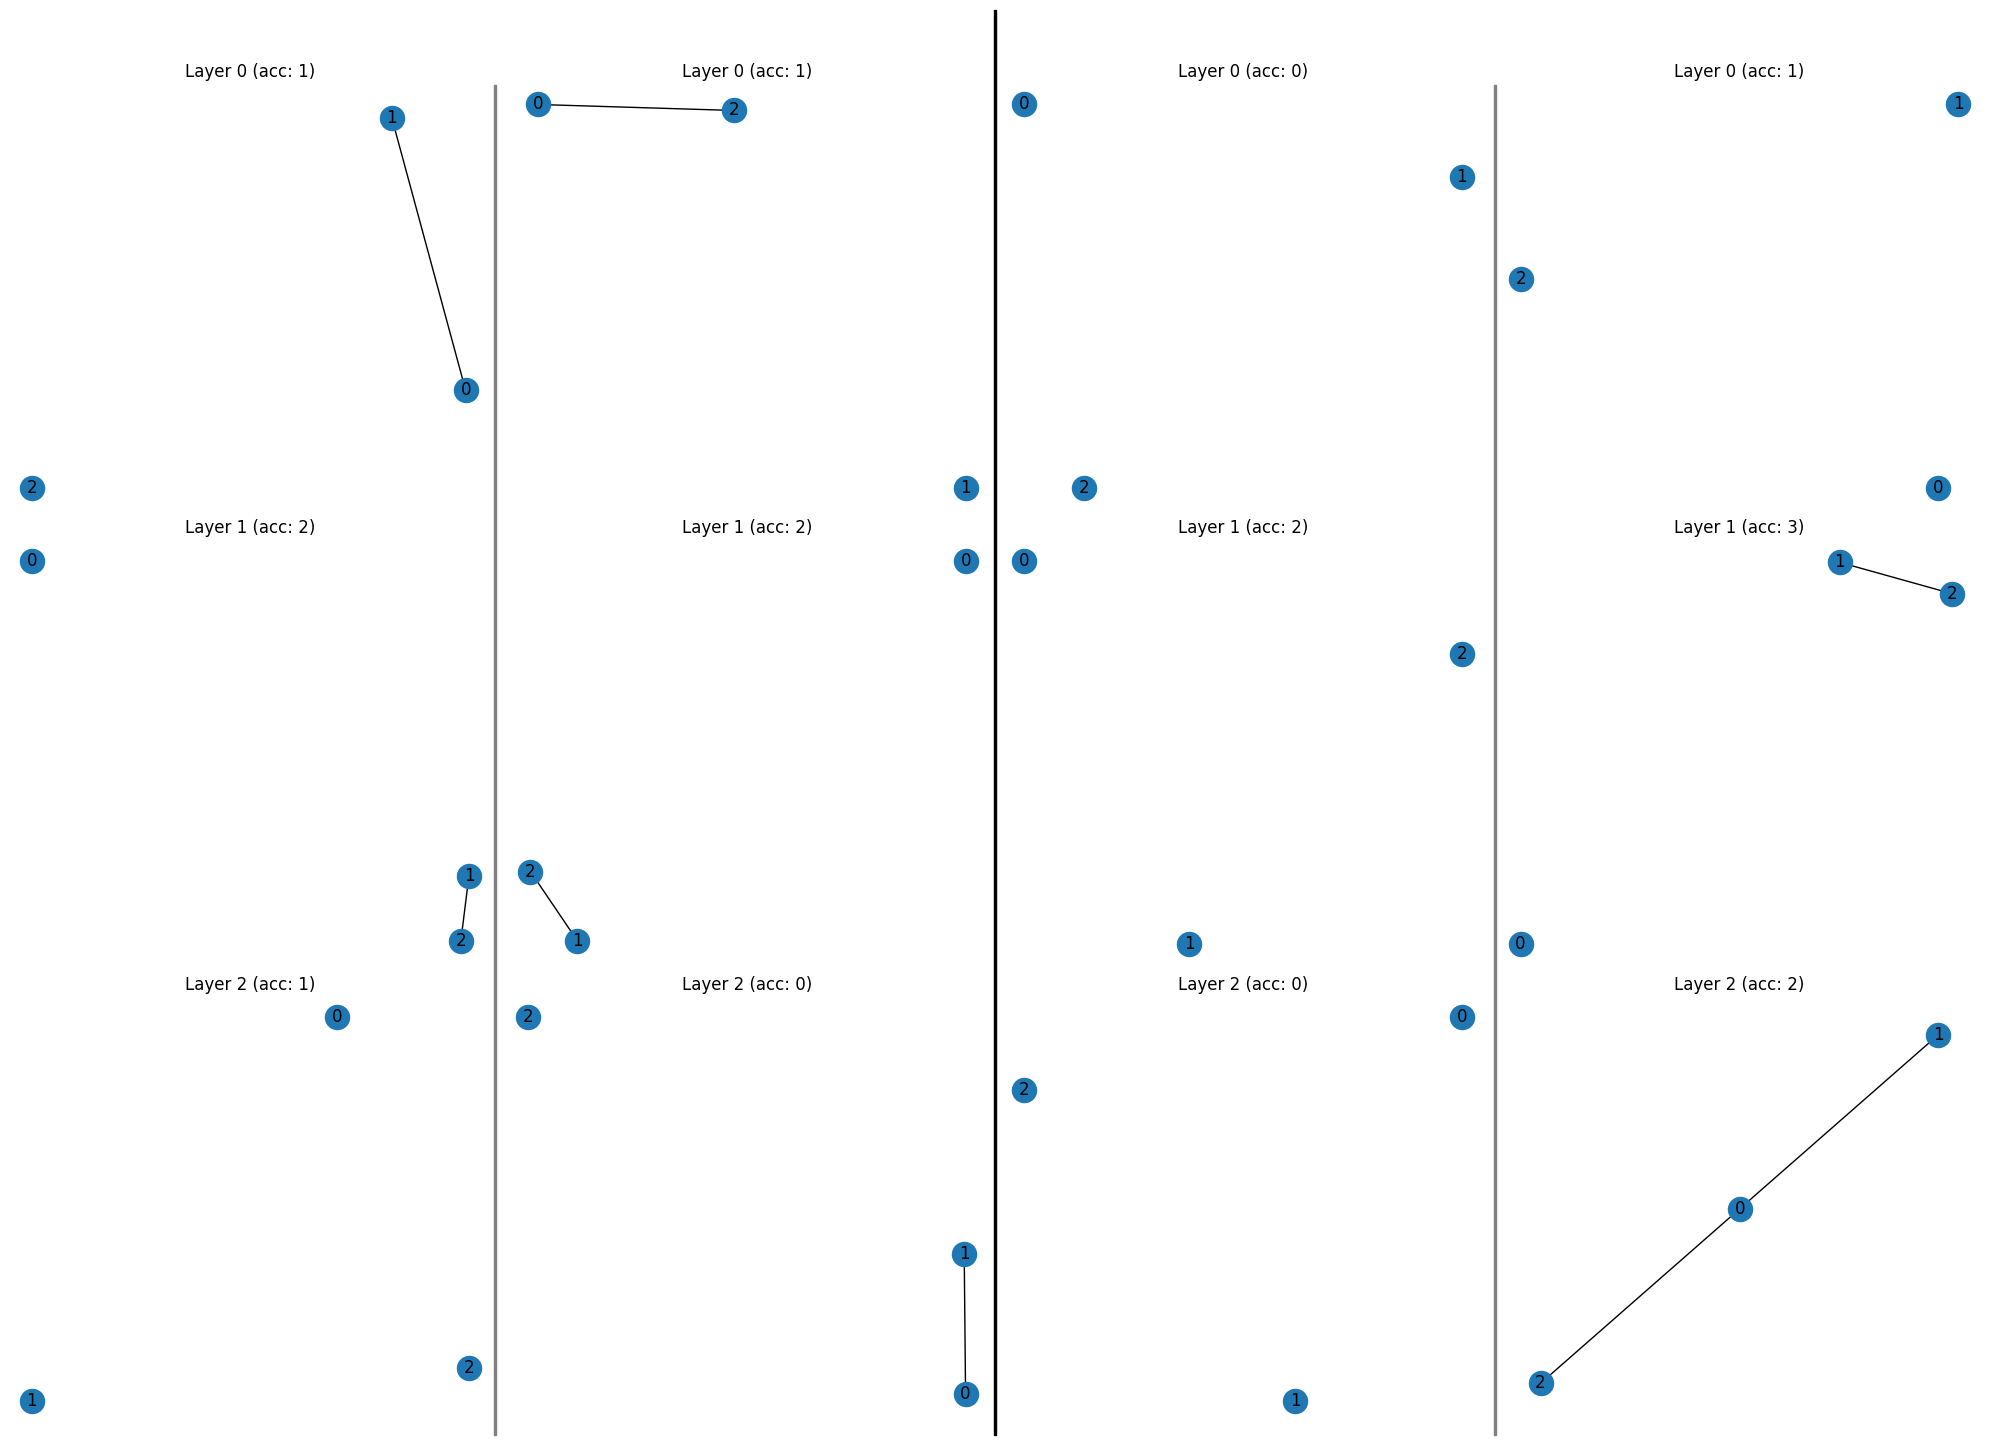

---------------------------------------------------------
4
Perm: (tensor([14, 13, 12, 15]), tensor([9, 8, 7, 6]))
Perm: (tensor([ 6,  4, 10,  3]), tensor([5, 2, 1, 0]))
Perm: (tensor([15, 14, 13,  3]), tensor([ 9,  2, 10,  3]))
Perm: (tensor([8, 1, 9, 5]), tensor([ 8,  3, 11,  2]))
Perm: (tensor([ 0, 13, 11,  6]), tensor([10, 12,  2, 13]))
Perm: (tensor([14, 16, 15,  6]), tensor([14, 16, 15,  2]))


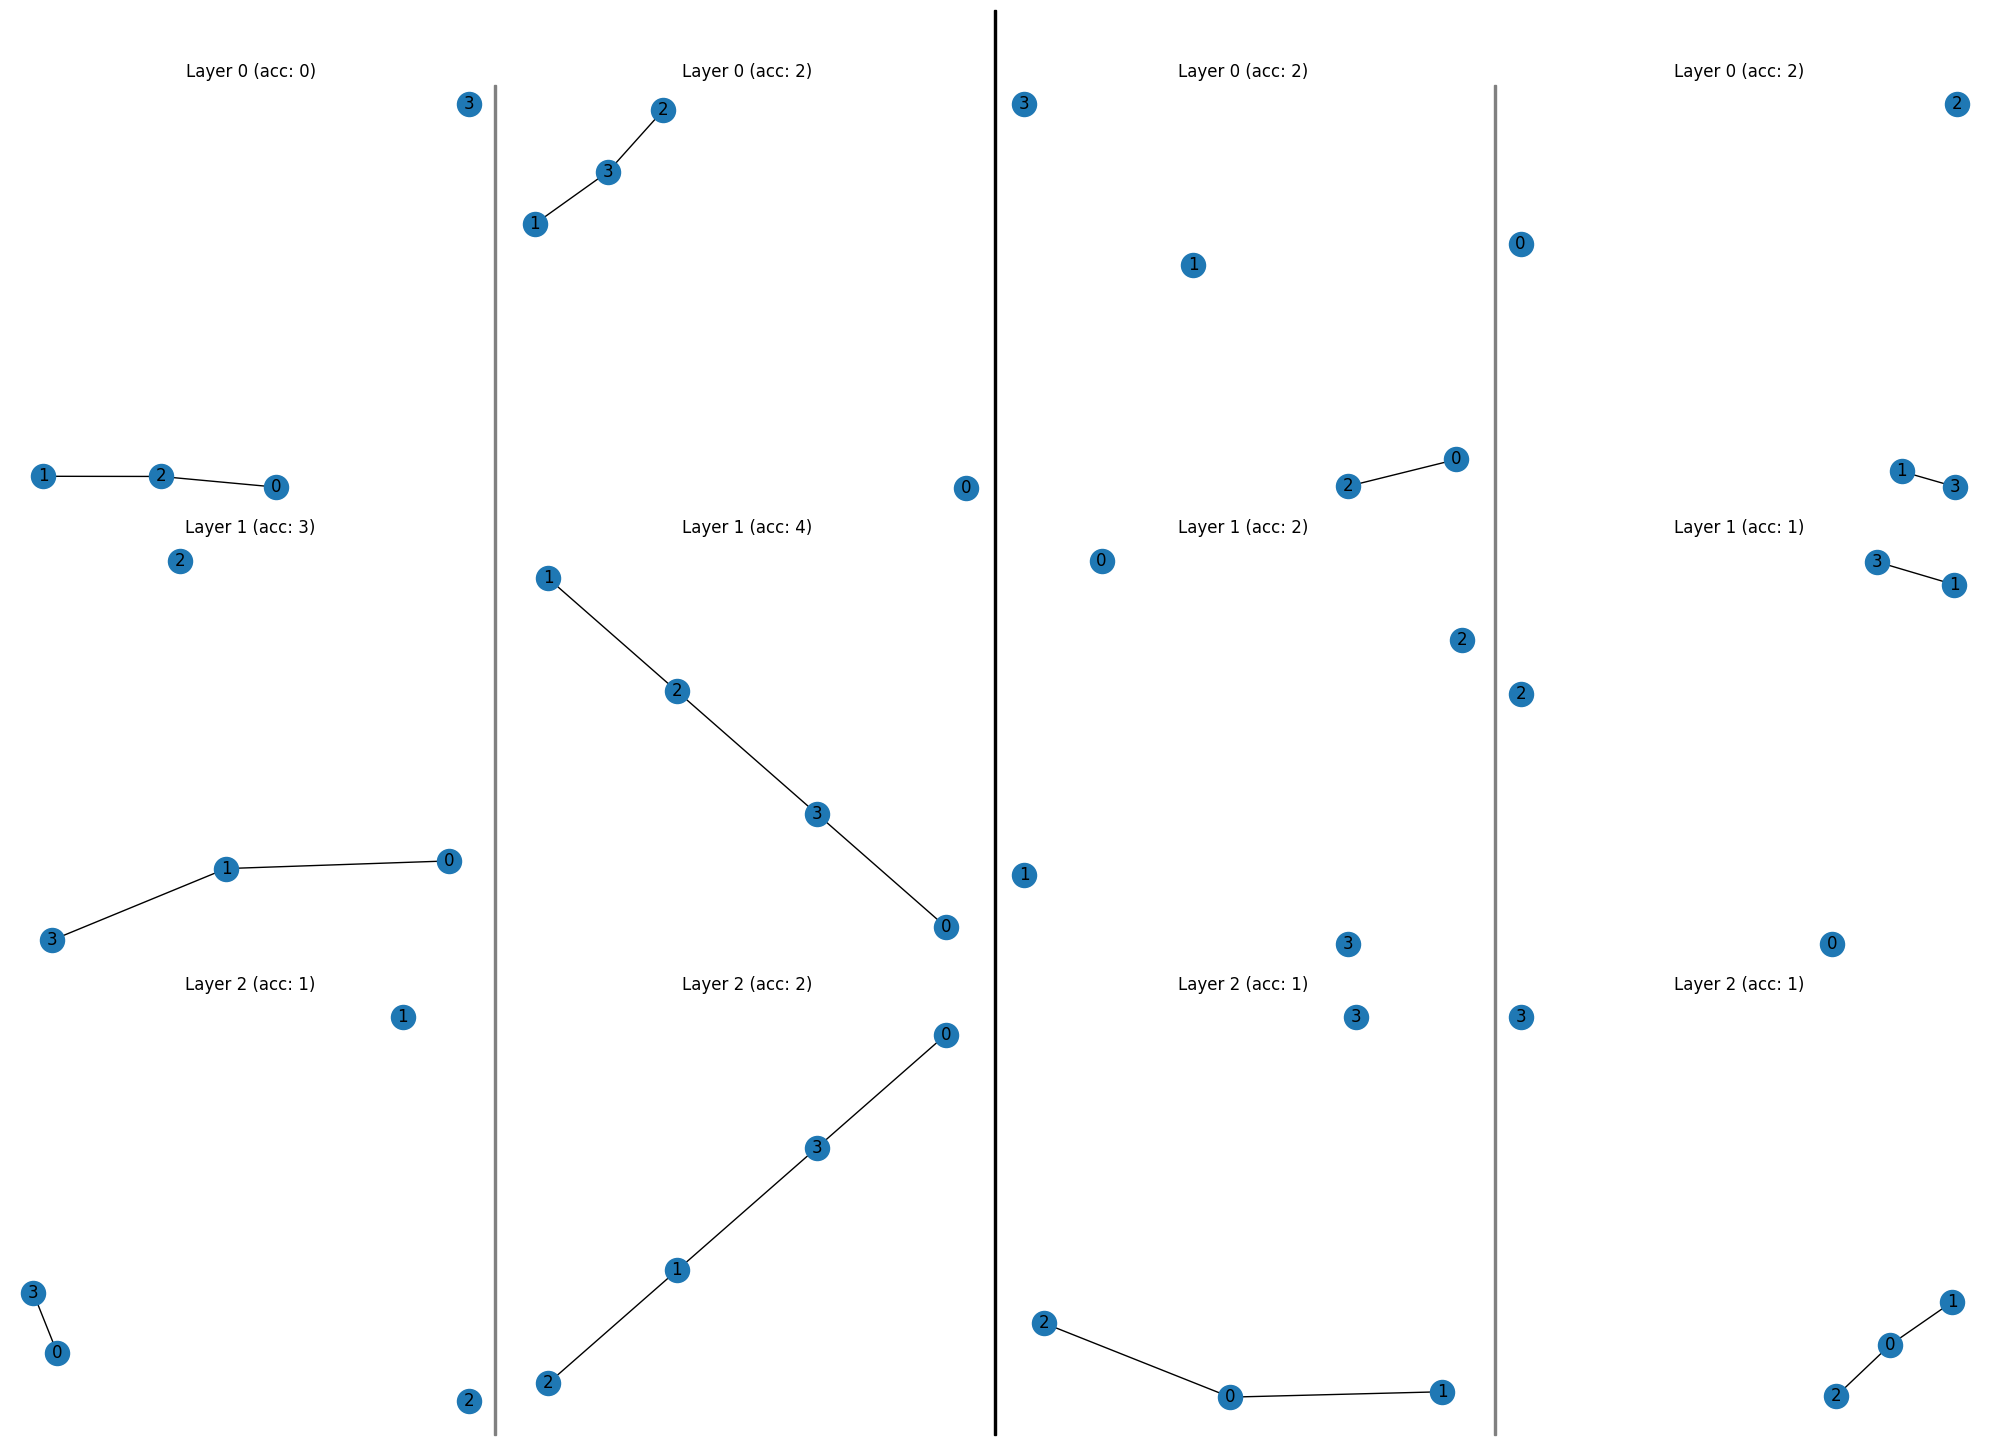

Perm: (tensor([13, 11,  4,  2]), tensor([1, 8, 2, 7]))
Perm: (tensor([ 2,  7,  4, 11]), tensor([3, 5, 7, 2]))
Perm: (tensor([11, 15, 14,  2]), tensor([ 7, 10,  9,  2]))
Perm: (tensor([10, 13,  2,  3]), tensor([12,  7,  3,  4]))
Perm: (tensor([ 9, 16, 19, 18]), tensor([0, 1, 8, 5]))
Perm: (tensor([13,  4, 12,  5]), tensor([14,  6, 13, 10]))


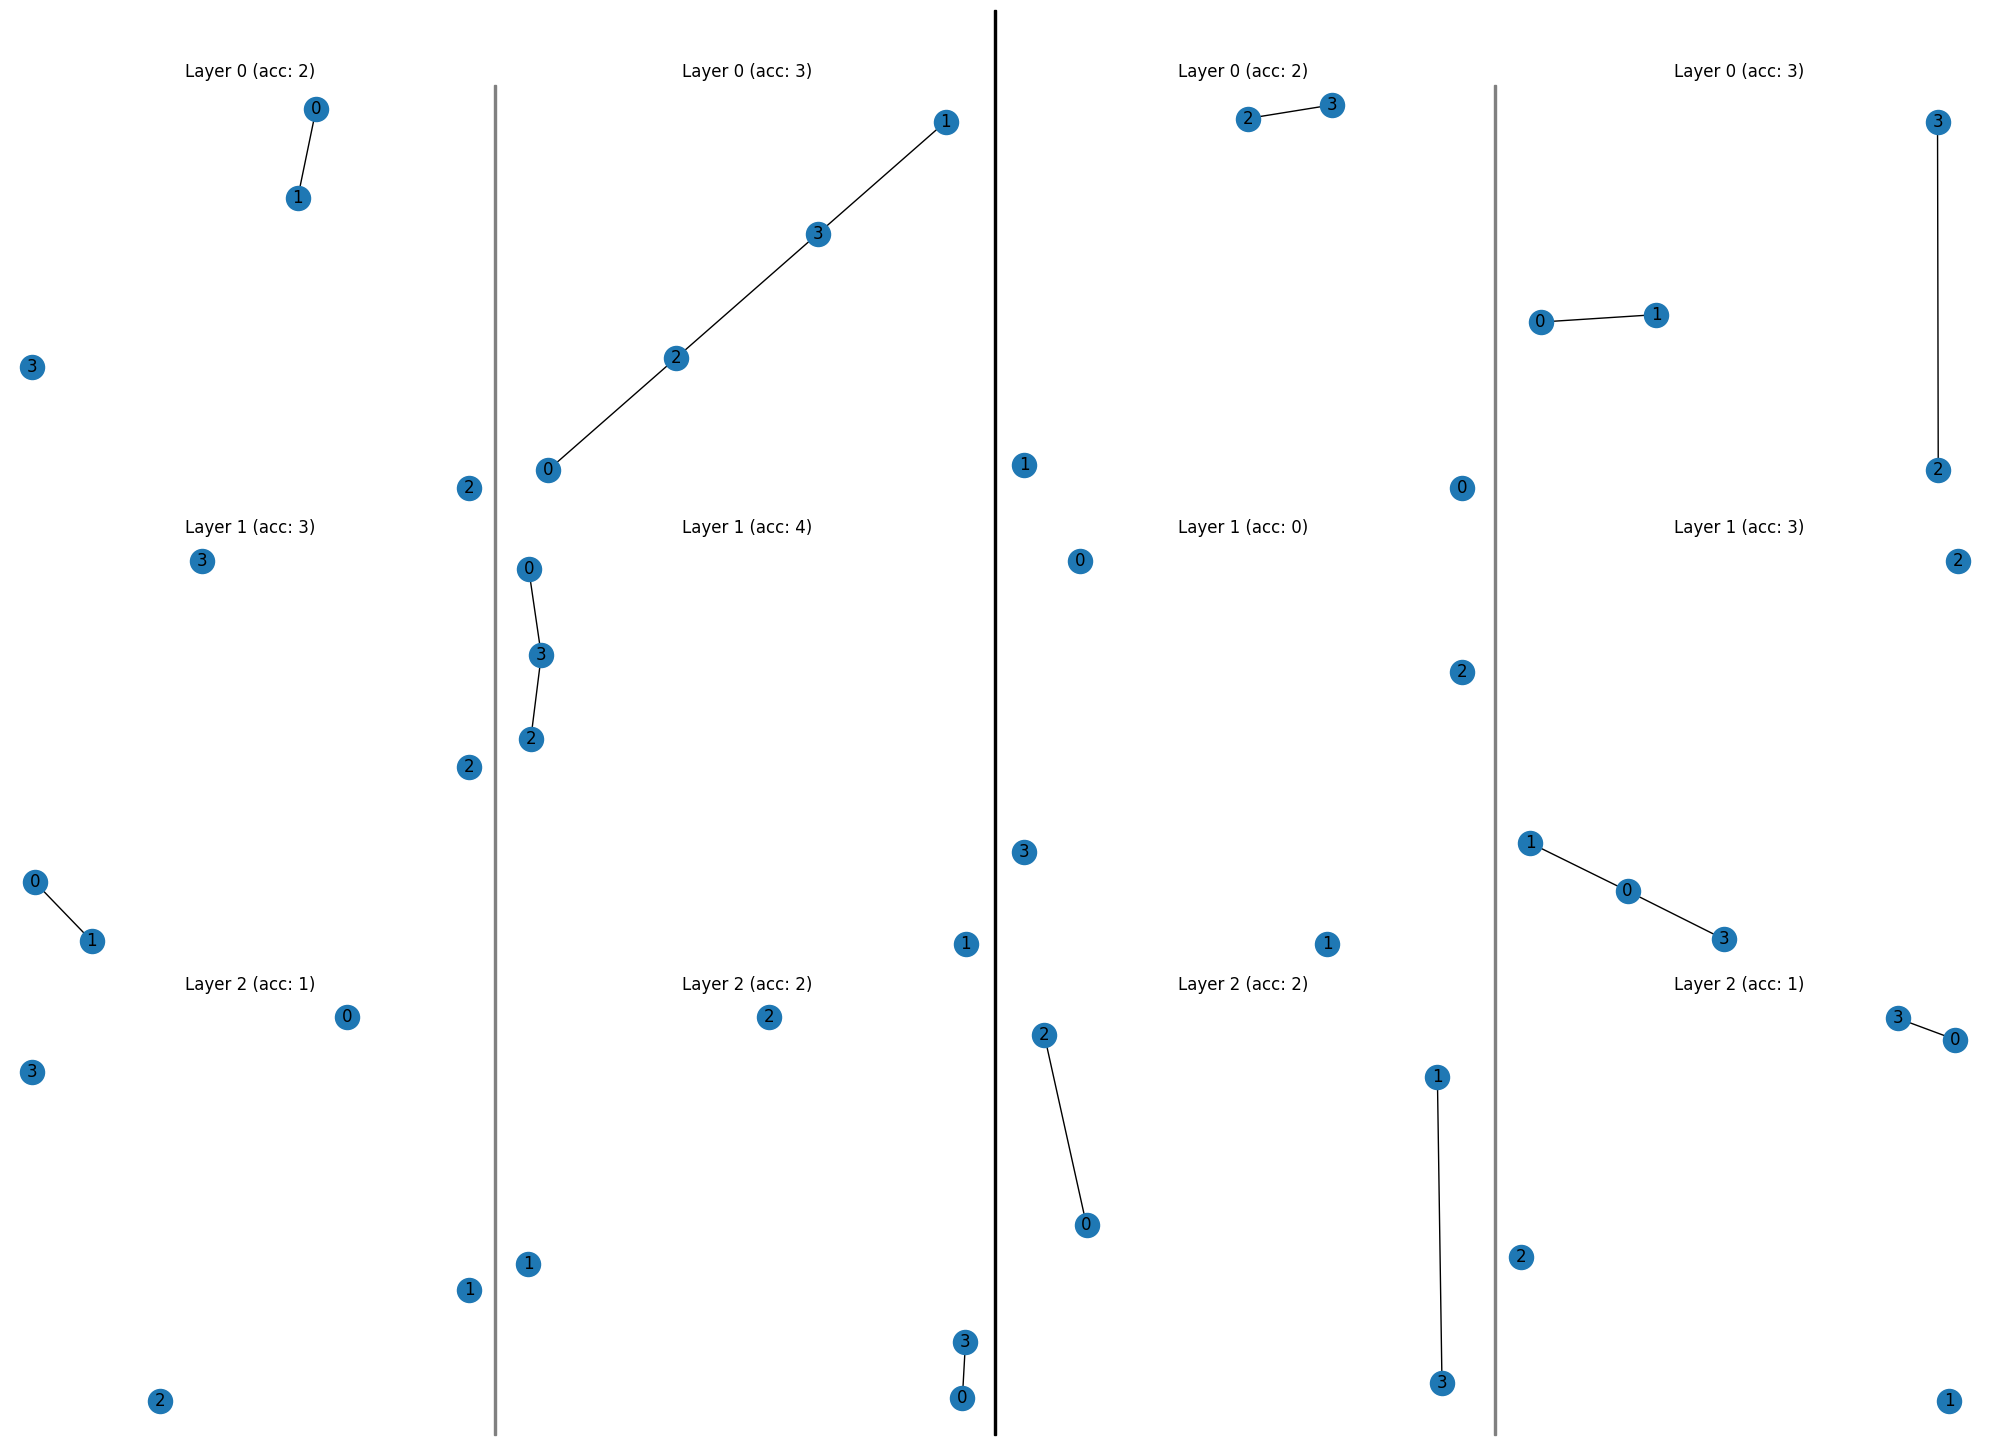

Perm: (tensor([ 7, 10,  9,  5]), tensor([ 8,  9,  1, 10]))
Perm: (tensor([5, 6, 0, 4]), tensor([ 1,  3, 10, 14]))
Perm: (tensor([10,  9,  7,  8]), tensor([ 8,  9,  5, 14]))
Perm: (tensor([16, 15, 14,  8]), tensor([16, 19, 18, 17]))
Perm: (tensor([14,  0,  2,  3]), tensor([17,  0, 13,  3]))
Perm: (tensor([5, 9, 4, 1]), tensor([11,  2,  5, 10]))


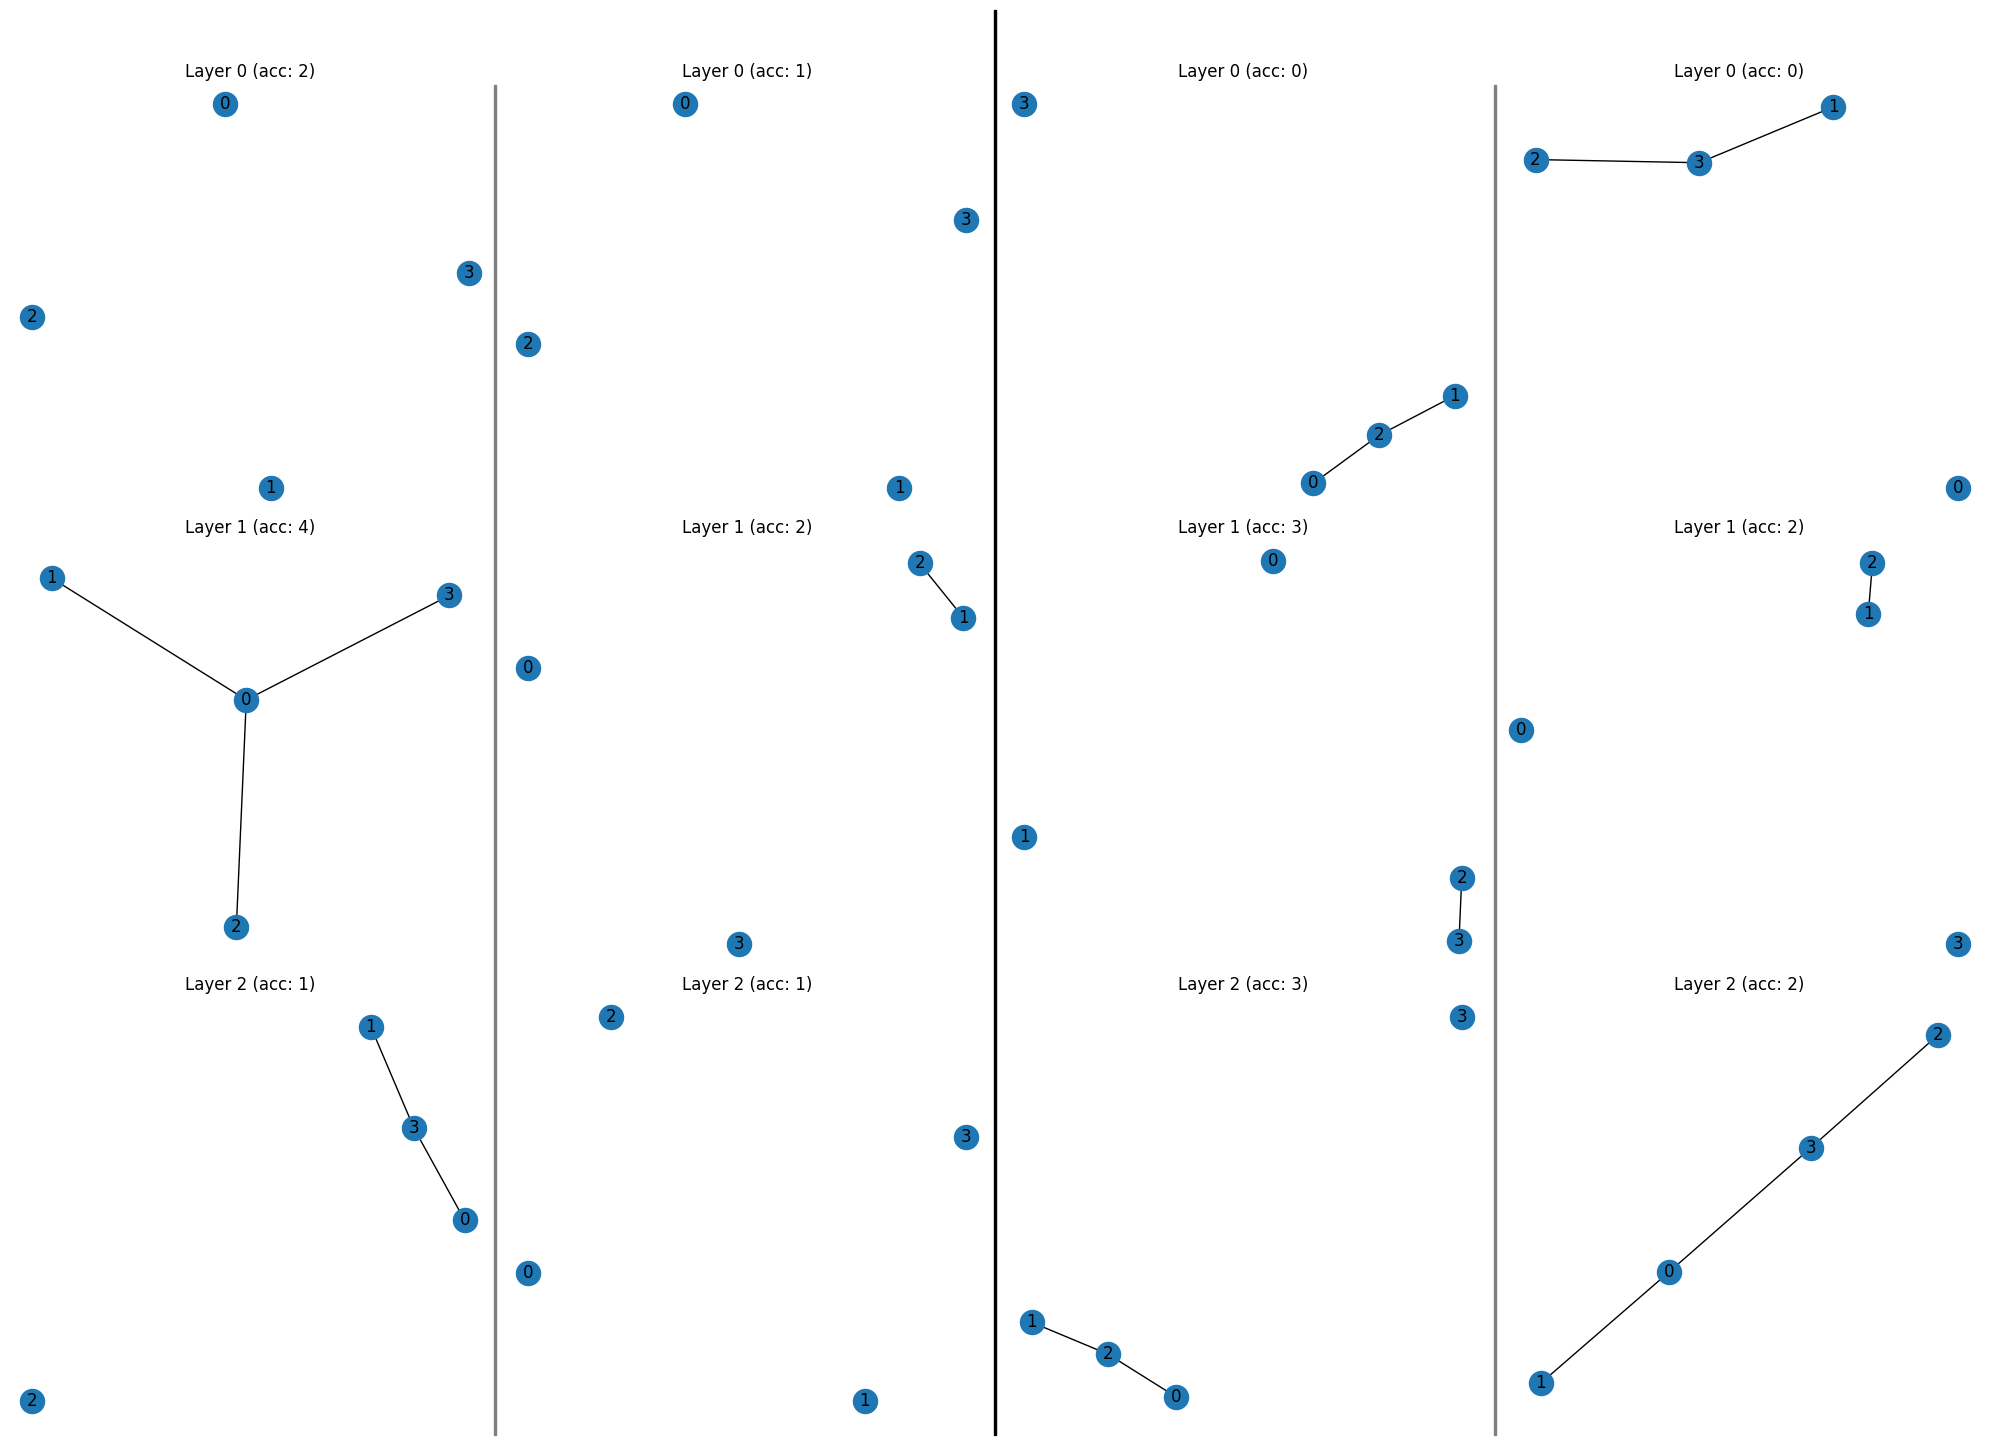

Perm: (tensor([13,  4, 15, 14]), tensor([11,  8,  0, 13]))
Perm: (tensor([15, 14,  4,  9]), tensor([13, 12, 10,  9]))
Perm: (tensor([13, 15, 14,  1]), tensor([ 8, 11,  1,  0]))
Perm: (tensor([7, 8, 9, 3]), tensor([5, 7, 8, 2]))
Perm: (tensor([14,  8,  3,  9]), tensor([12,  7,  6,  5]))
Perm: (tensor([16, 15, 14,  0]), tensor([14, 13,  5,  0]))


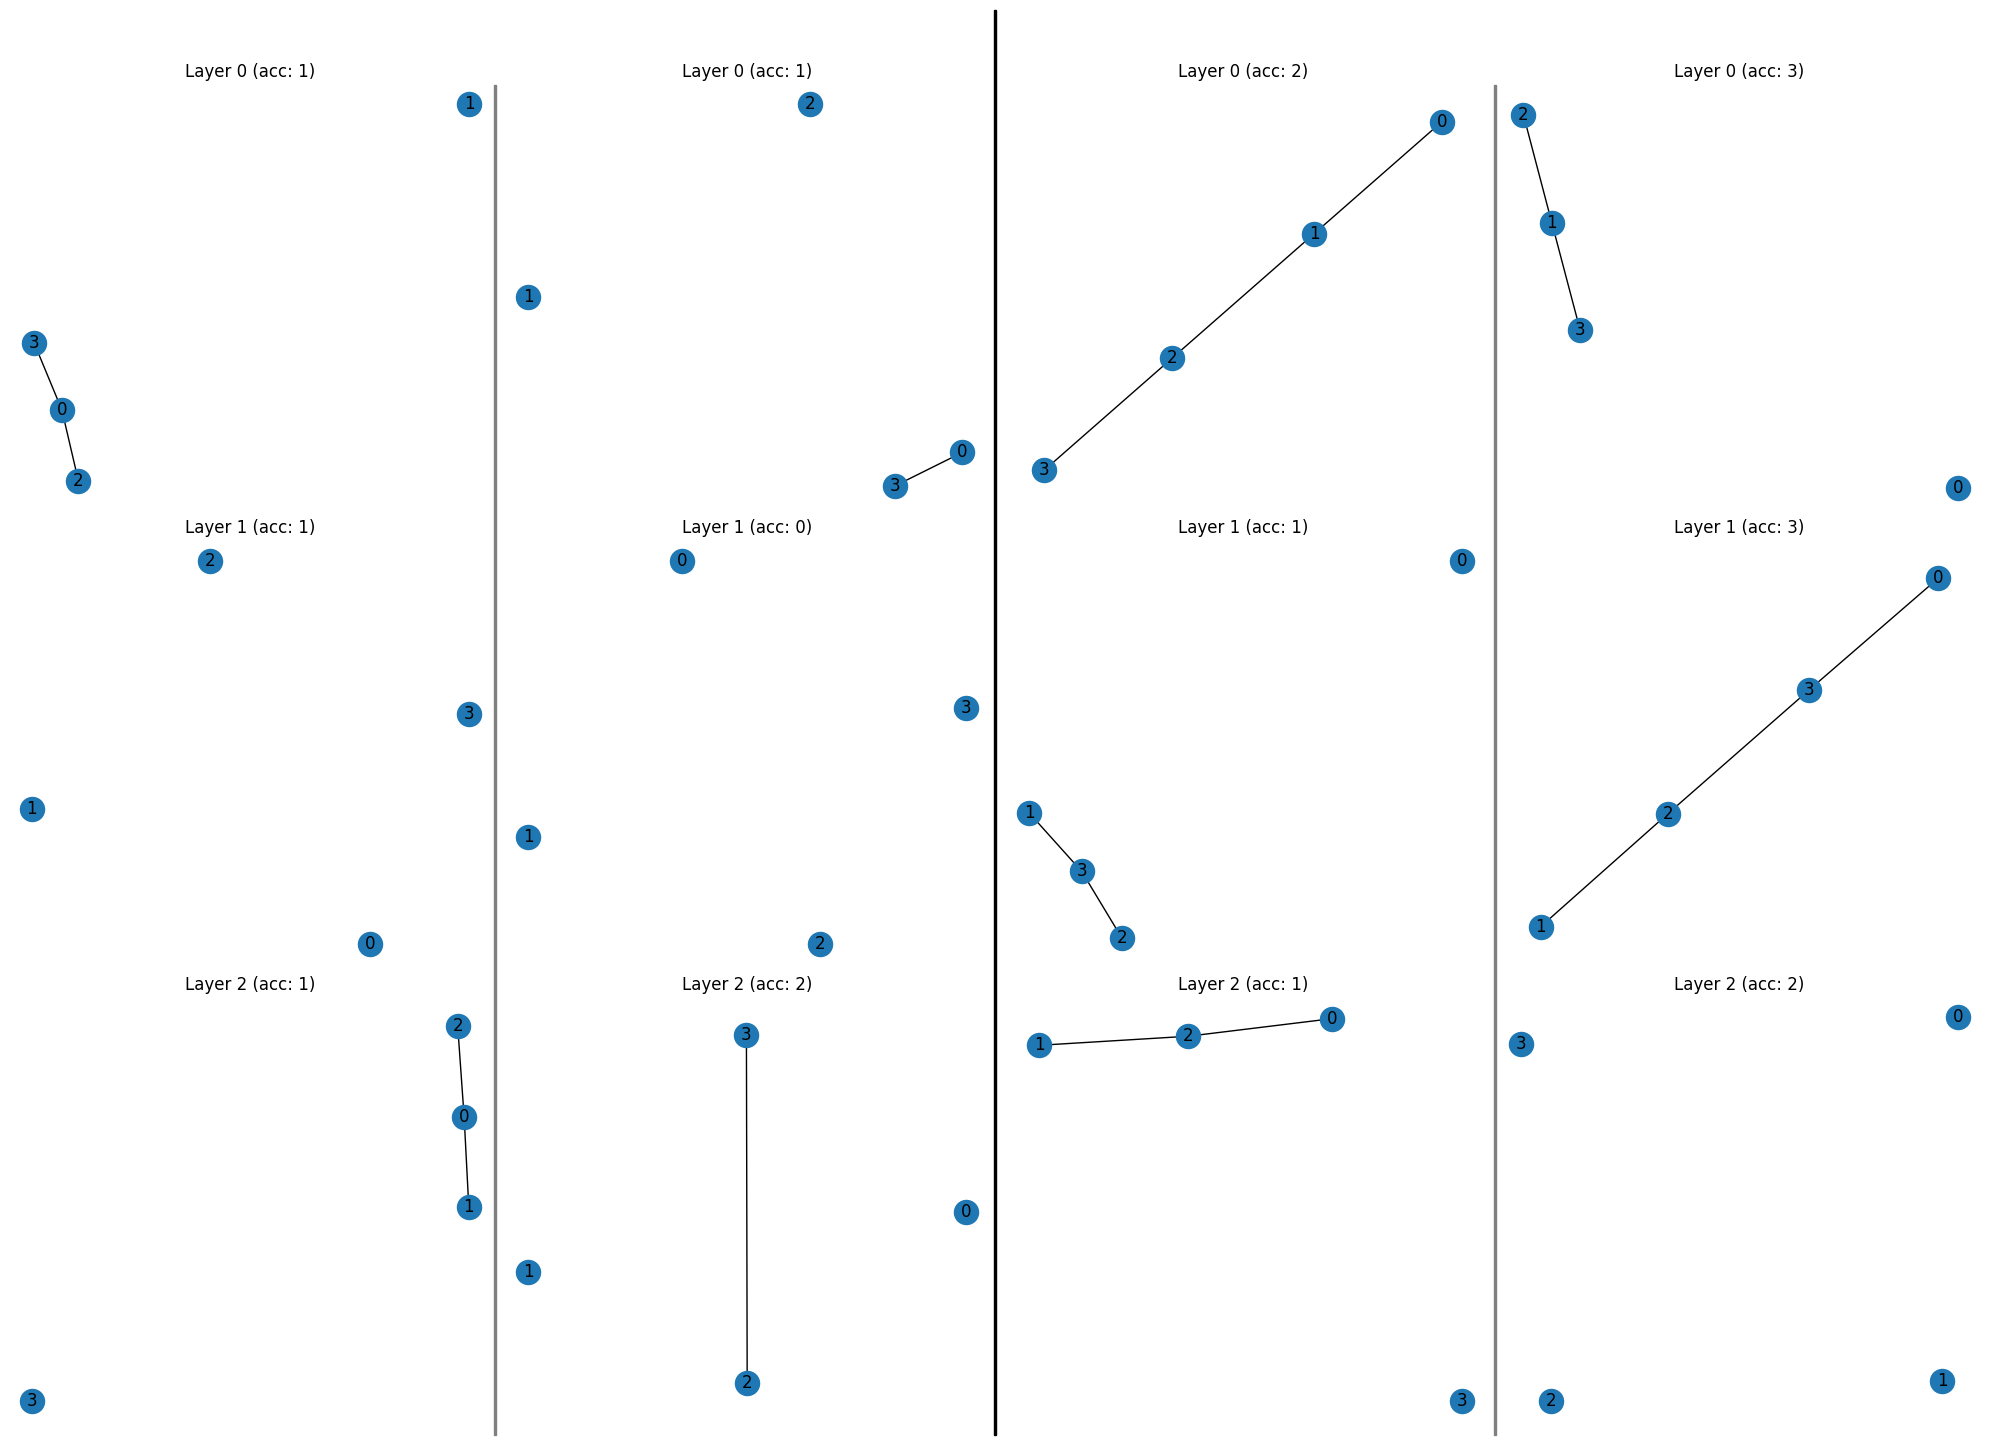

Perm: (tensor([10,  6,  7,  8]), tensor([10,  5,  8,  3]))
Perm: (tensor([10,  6,  9,  7]), tensor([10,  4,  6,  2]))
Perm: (tensor([10,  6,  1,  3]), tensor([10,  8,  3,  2]))
Perm: (tensor([ 0,  1, 13, 14]), tensor([ 8,  3, 14,  2]))
Perm: (tensor([ 6, 17,  9, 12]), tensor([14, 16, 15,  0]))
Perm: (tensor([ 6, 17, 18,  7]), tensor([14, 16, 15, 11]))


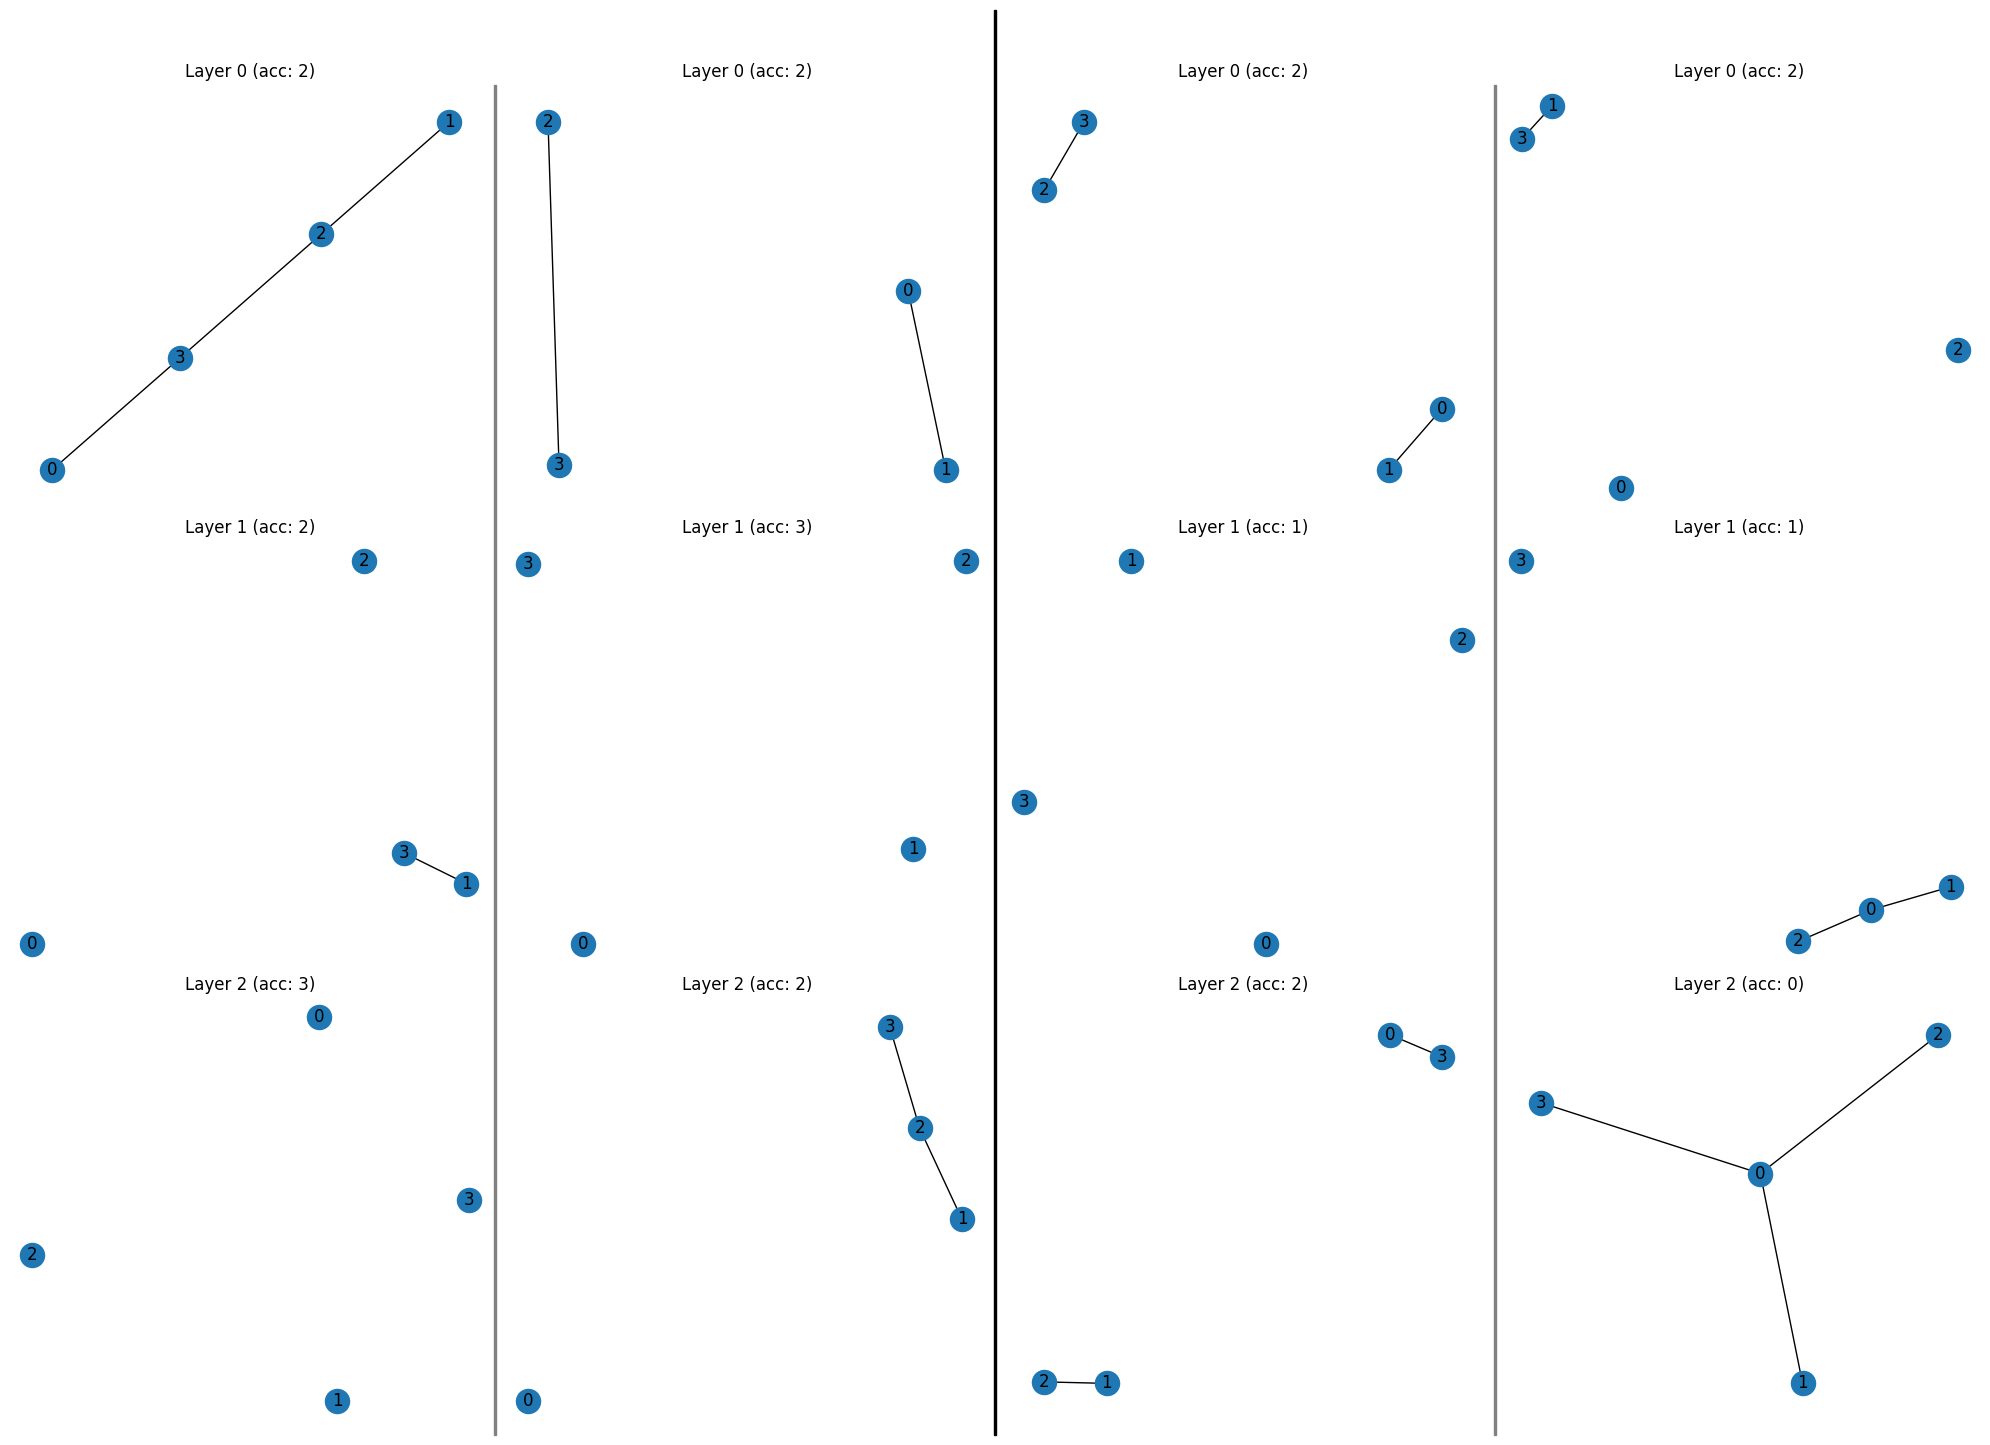

Perm: (tensor([ 6,  4, 10,  3]), tensor([7, 5, 2, 3]))
Perm: (tensor([ 4, 11,  6, 12]), tensor([7, 6, 3, 4]))
Perm: (tensor([13,  3, 15, 14]), tensor([ 1, 10,  0,  9]))
Perm: (tensor([16, 15,  1,  3]), tensor([17, 16, 12,  5]))
Perm: (tensor([16, 11, 10,  9]), tensor([17,  8,  7, 13]))
Perm: (tensor([12,  2,  5,  9]), tensor([12, 16, 13,  2]))


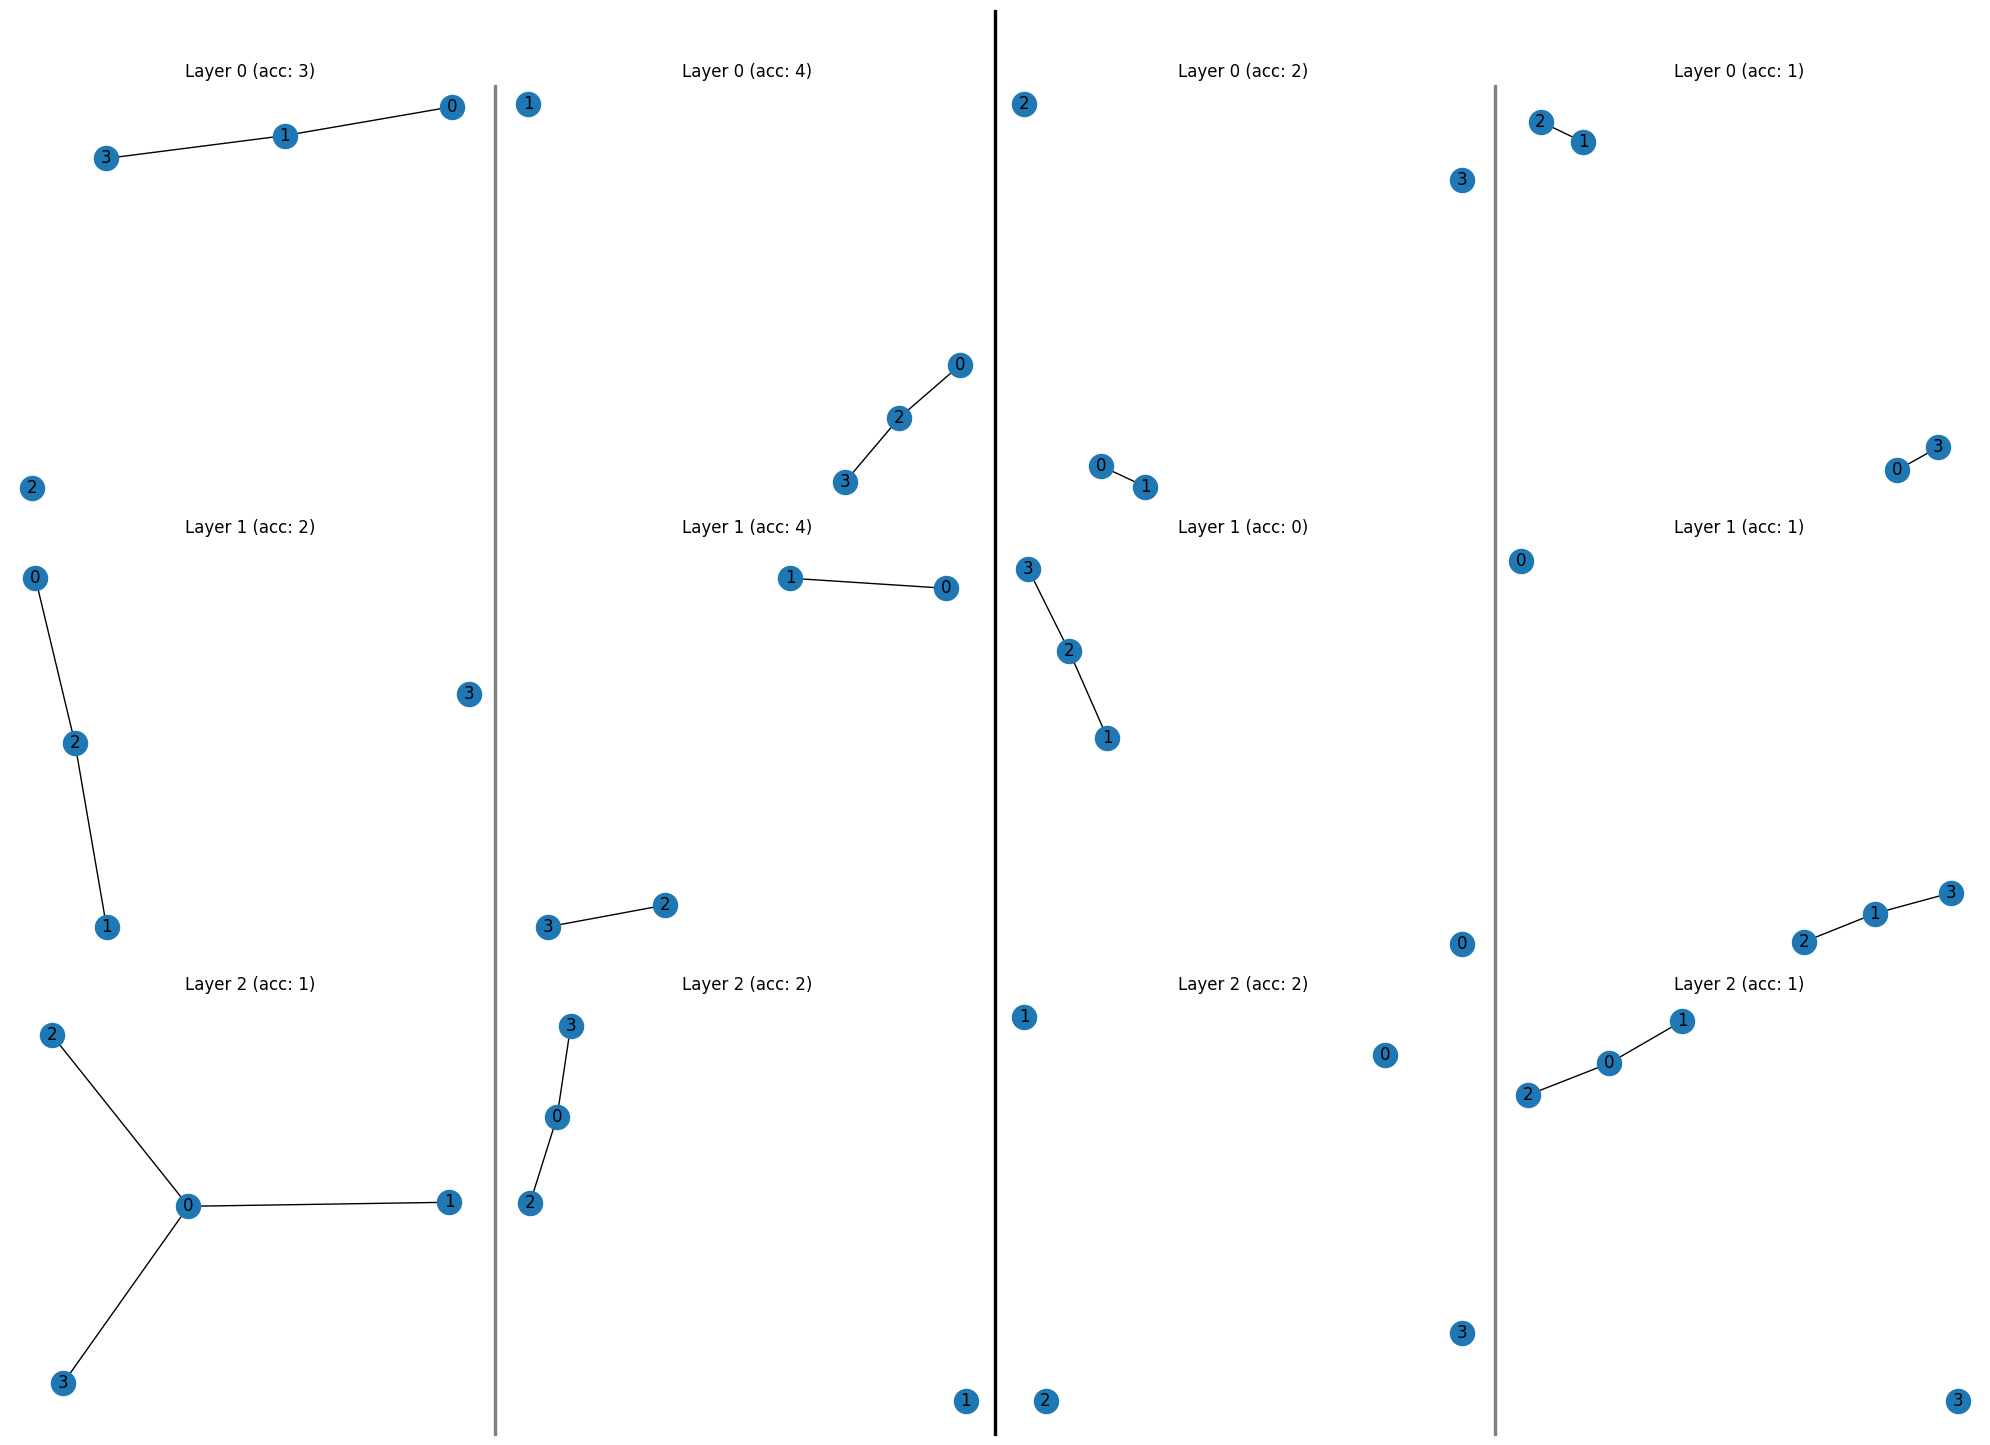

Perm: (tensor([11, 10,  0,  3]), tensor([10,  1,  2,  0]))
Perm: (tensor([11,  1,  6,  3]), tensor([10,  0,  1,  7]))
Perm: (tensor([ 8, 11, 13, 12]), tensor([10, 12, 11,  9]))
Perm: (tensor([ 9, 14,  2,  3]), tensor([9, 2, 1, 3]))
Perm: (tensor([ 3,  9,  2, 14]), tensor([ 9,  2, 12,  4]))
Perm: (tensor([ 6, 16, 17, 18]), tensor([ 6, 15, 16, 17]))


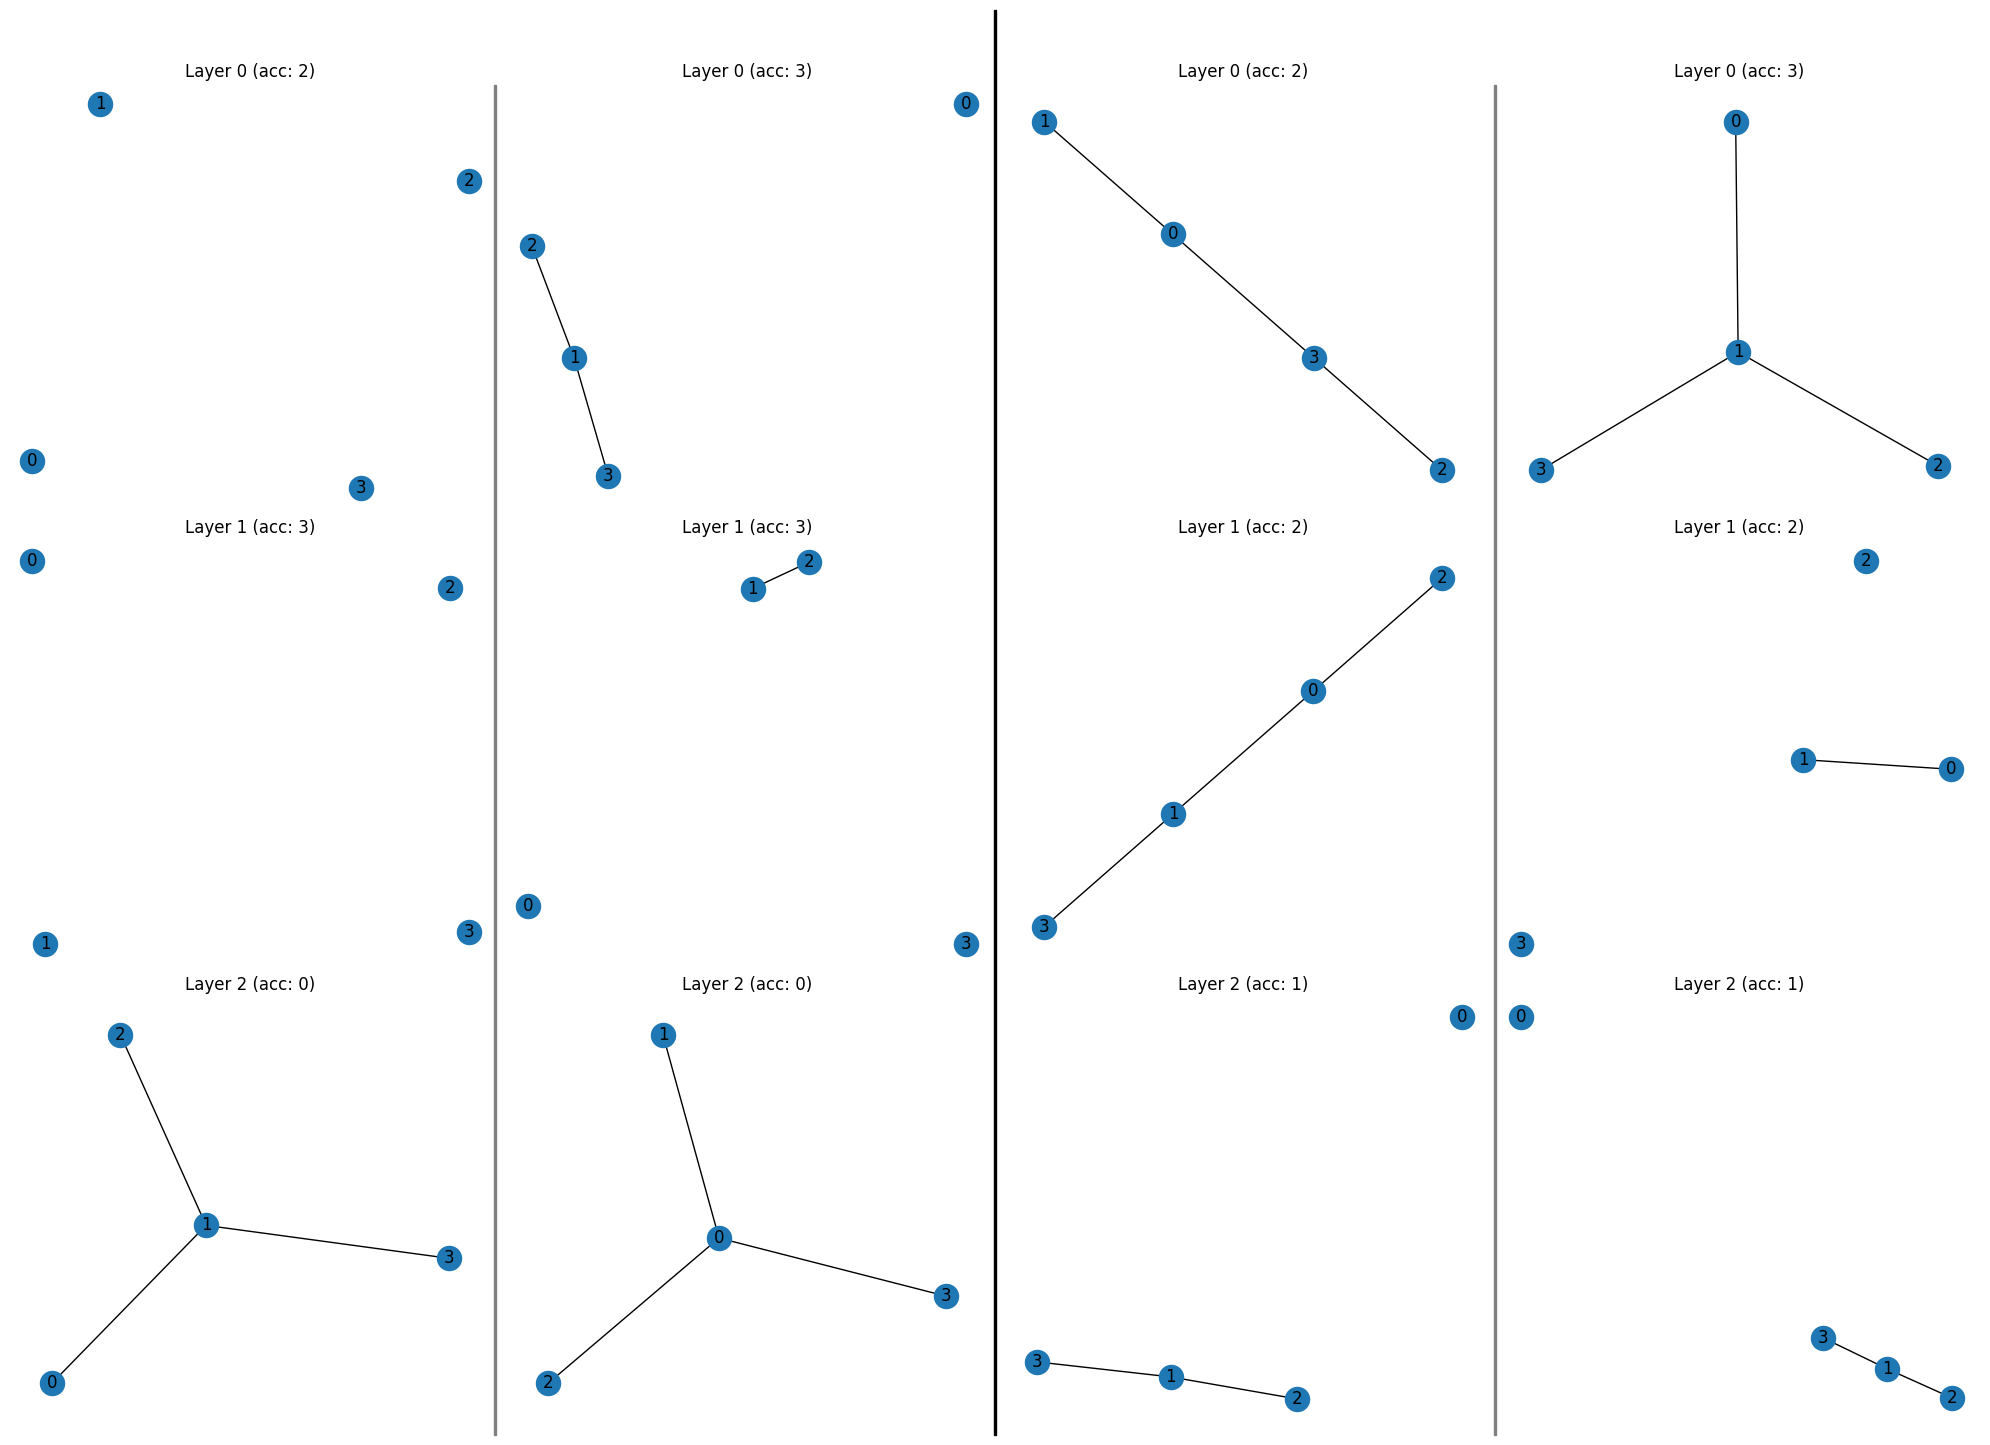

Perm: (tensor([ 1,  0, 12, 14]), tensor([ 8, 10,  9,  0]))
Perm: (tensor([13, 14,  7,  2]), tensor([ 7,  6, 10,  9]))
Perm: (tensor([14, 13,  0,  7]), tensor([6, 7, 3, 4]))
Perm: (tensor([10, 11,  2,  6]), tensor([ 9, 10,  6,  5]))
Perm: (tensor([18, 17, 13,  0]), tensor([ 1, 17, 16, 13]))
Perm: (tensor([ 7, 16, 10,  6]), tensor([ 8,  7, 14, 10]))


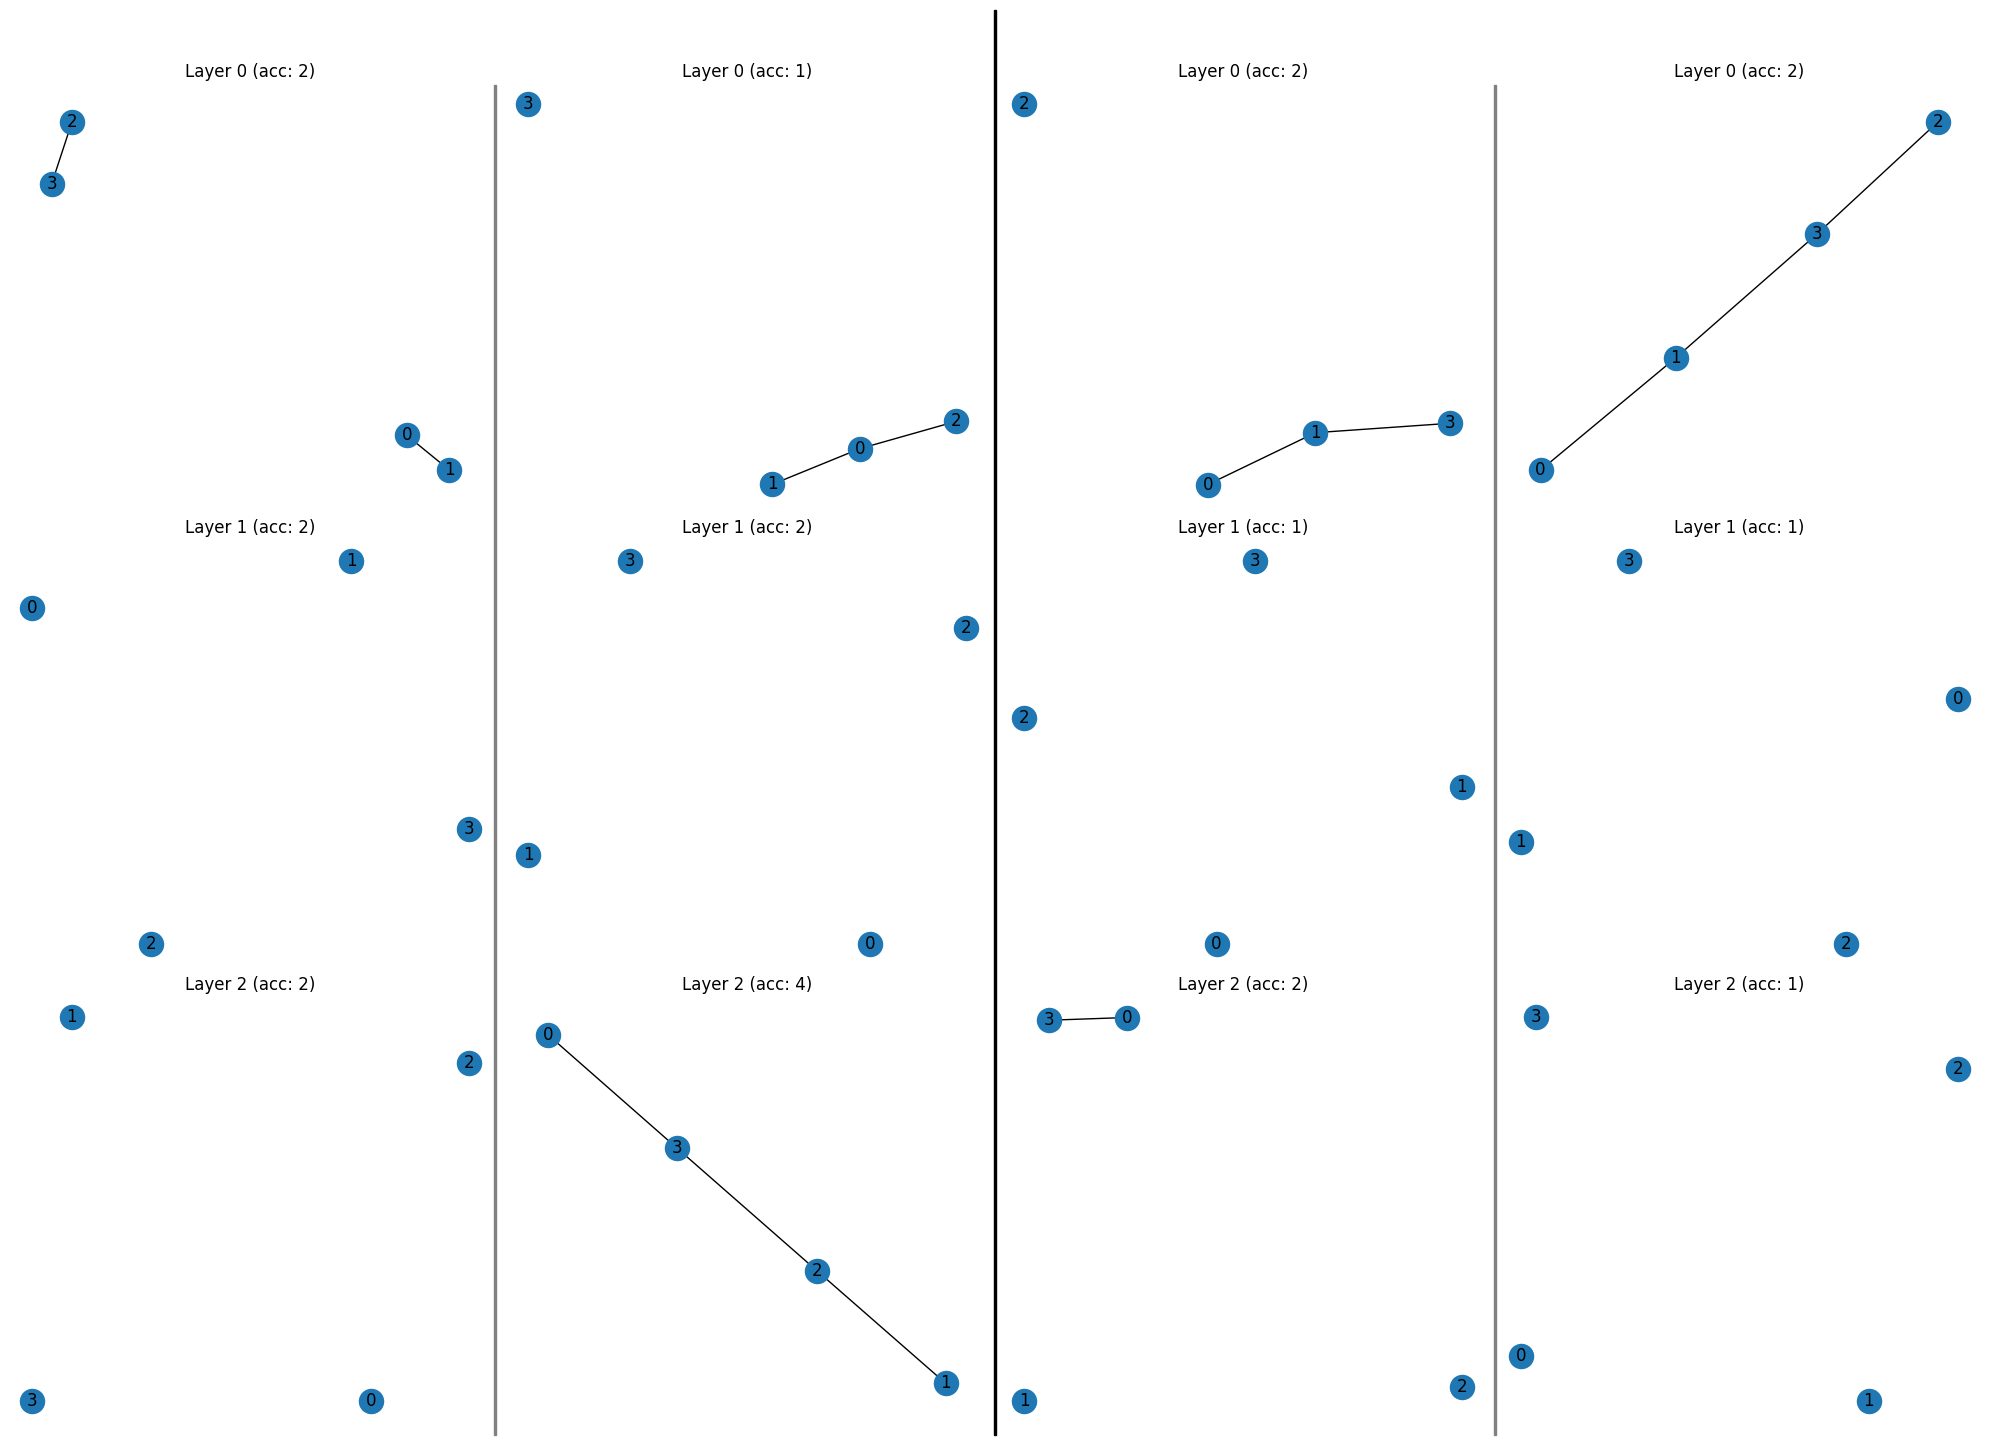

Perm: (tensor([11, 13, 12, 10]), tensor([11,  6, 13,  8]))
Perm: (tensor([1, 8, 9, 4]), tensor([10,  1,  5,  4]))
Perm: (tensor([11,  8,  1,  9]), tensor([ 1,  5,  6, 11]))
Perm: (tensor([12,  4,  9,  2]), tensor([11,  8,  7,  3]))
Perm: (tensor([ 9,  2, 12,  4]), tensor([8, 3, 4, 7]))
Perm: (tensor([ 1,  9, 14, 10]), tensor([3, 8, 4, 7]))


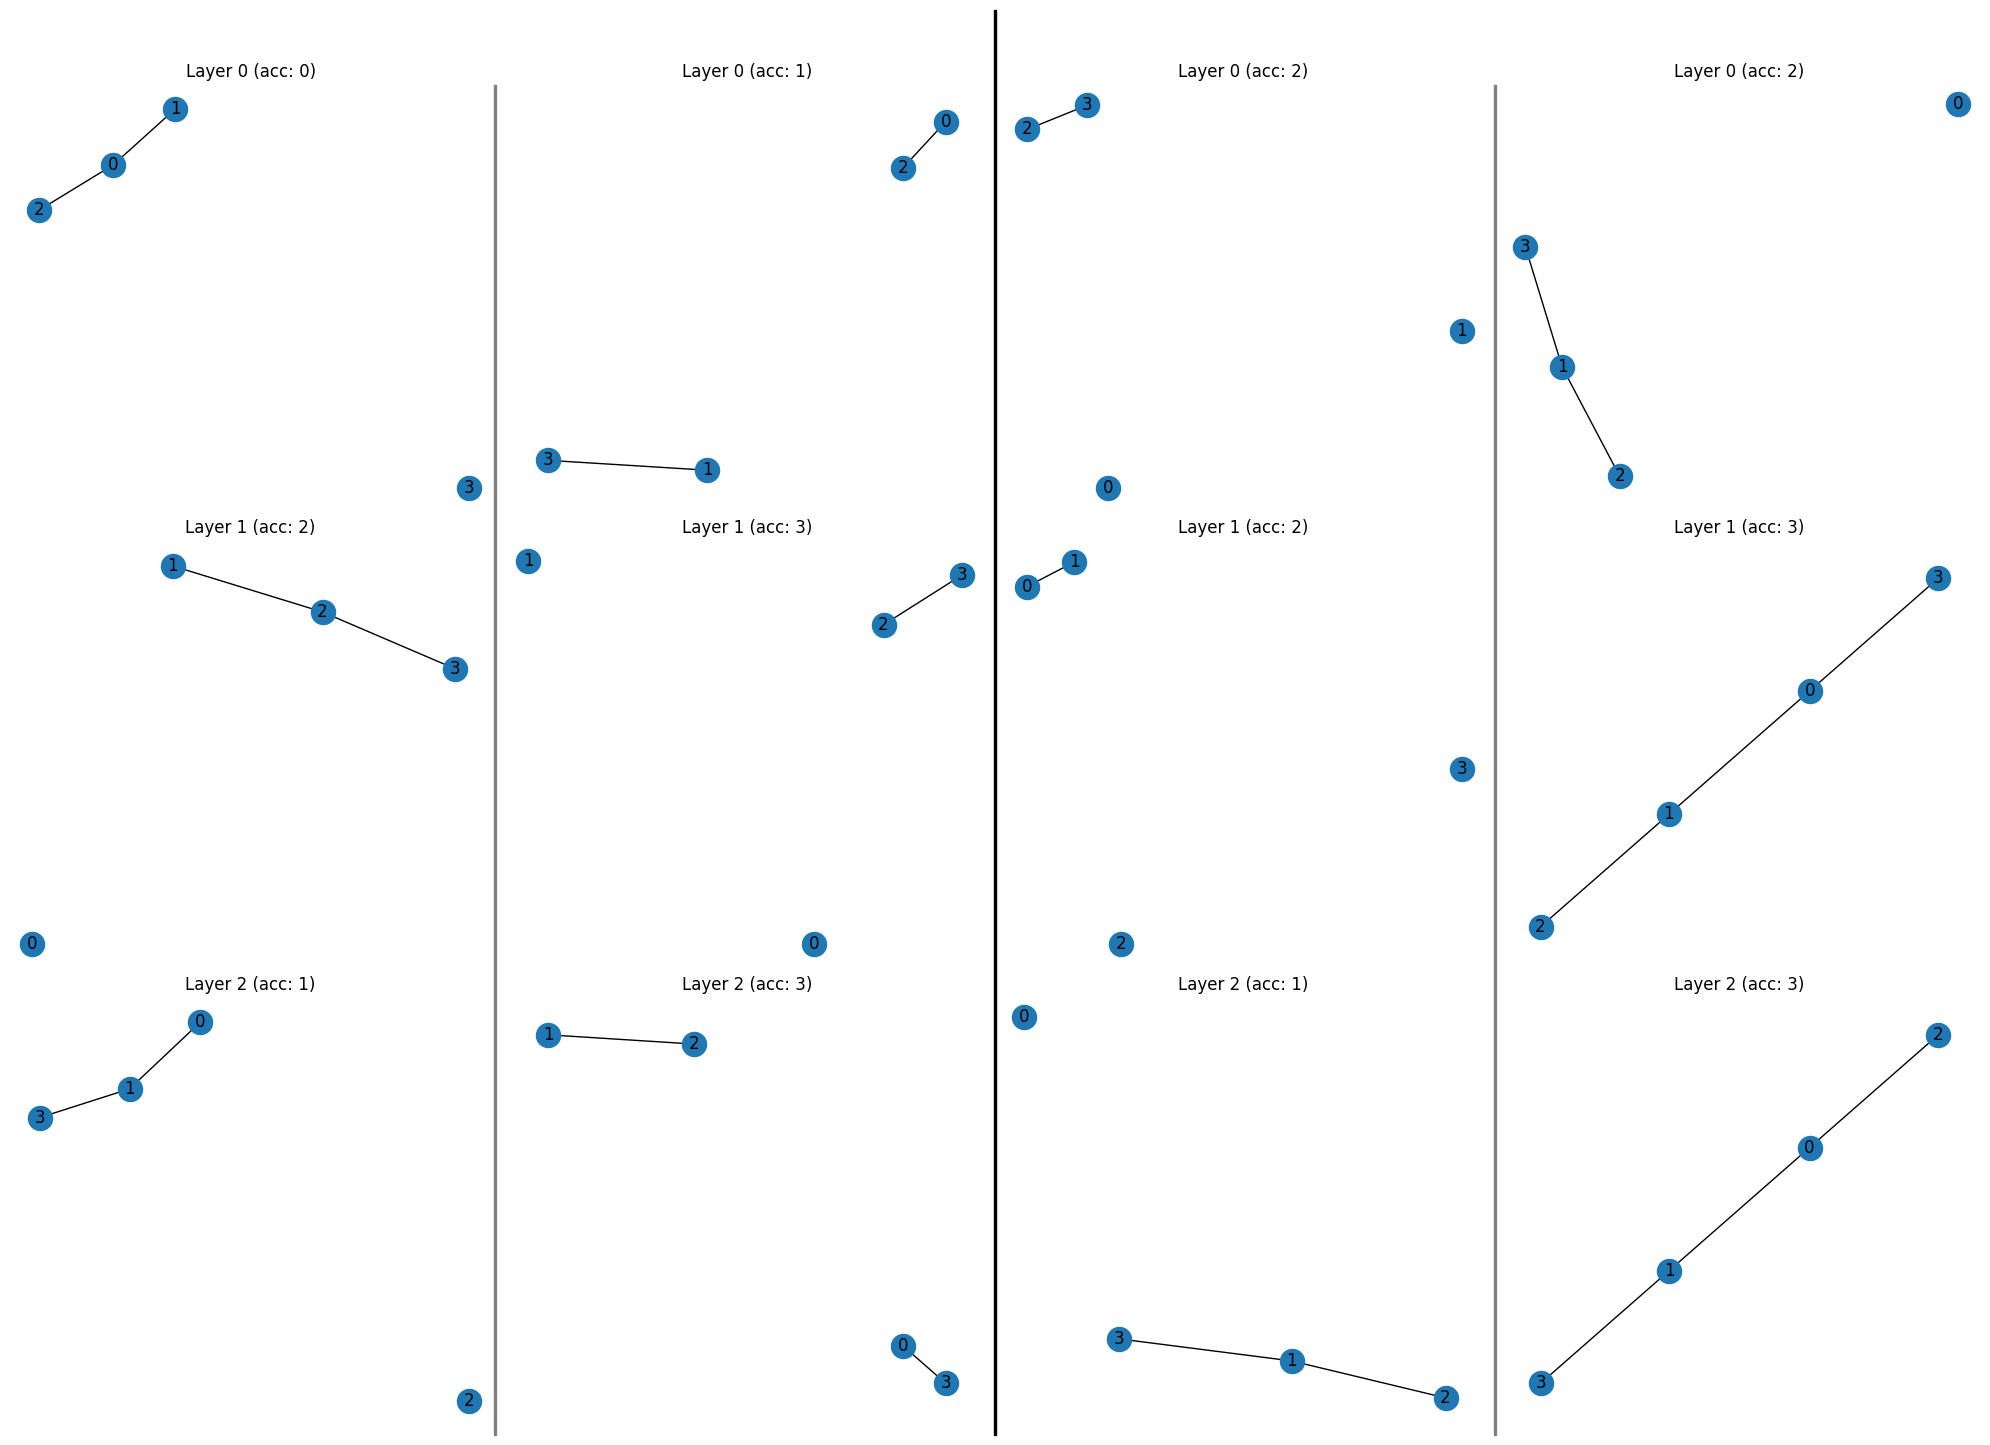

Perm: (tensor([0, 1, 4, 7]), tensor([ 0,  1, 12,  3]))
Perm: (tensor([5, 3, 0, 1]), tensor([ 2,  7, 11,  4]))
Perm: (tensor([ 7,  8, 11, 10]), tensor([13, 15, 14, 11]))
Perm: (tensor([ 5, 12, 13,  3]), tensor([8, 1, 9, 4]))
Perm: (tensor([ 6,  9, 16,  1]), tensor([14,  0, 16, 15]))
Perm: (tensor([18, 17,  4,  0]), tensor([9, 4, 5, 8]))


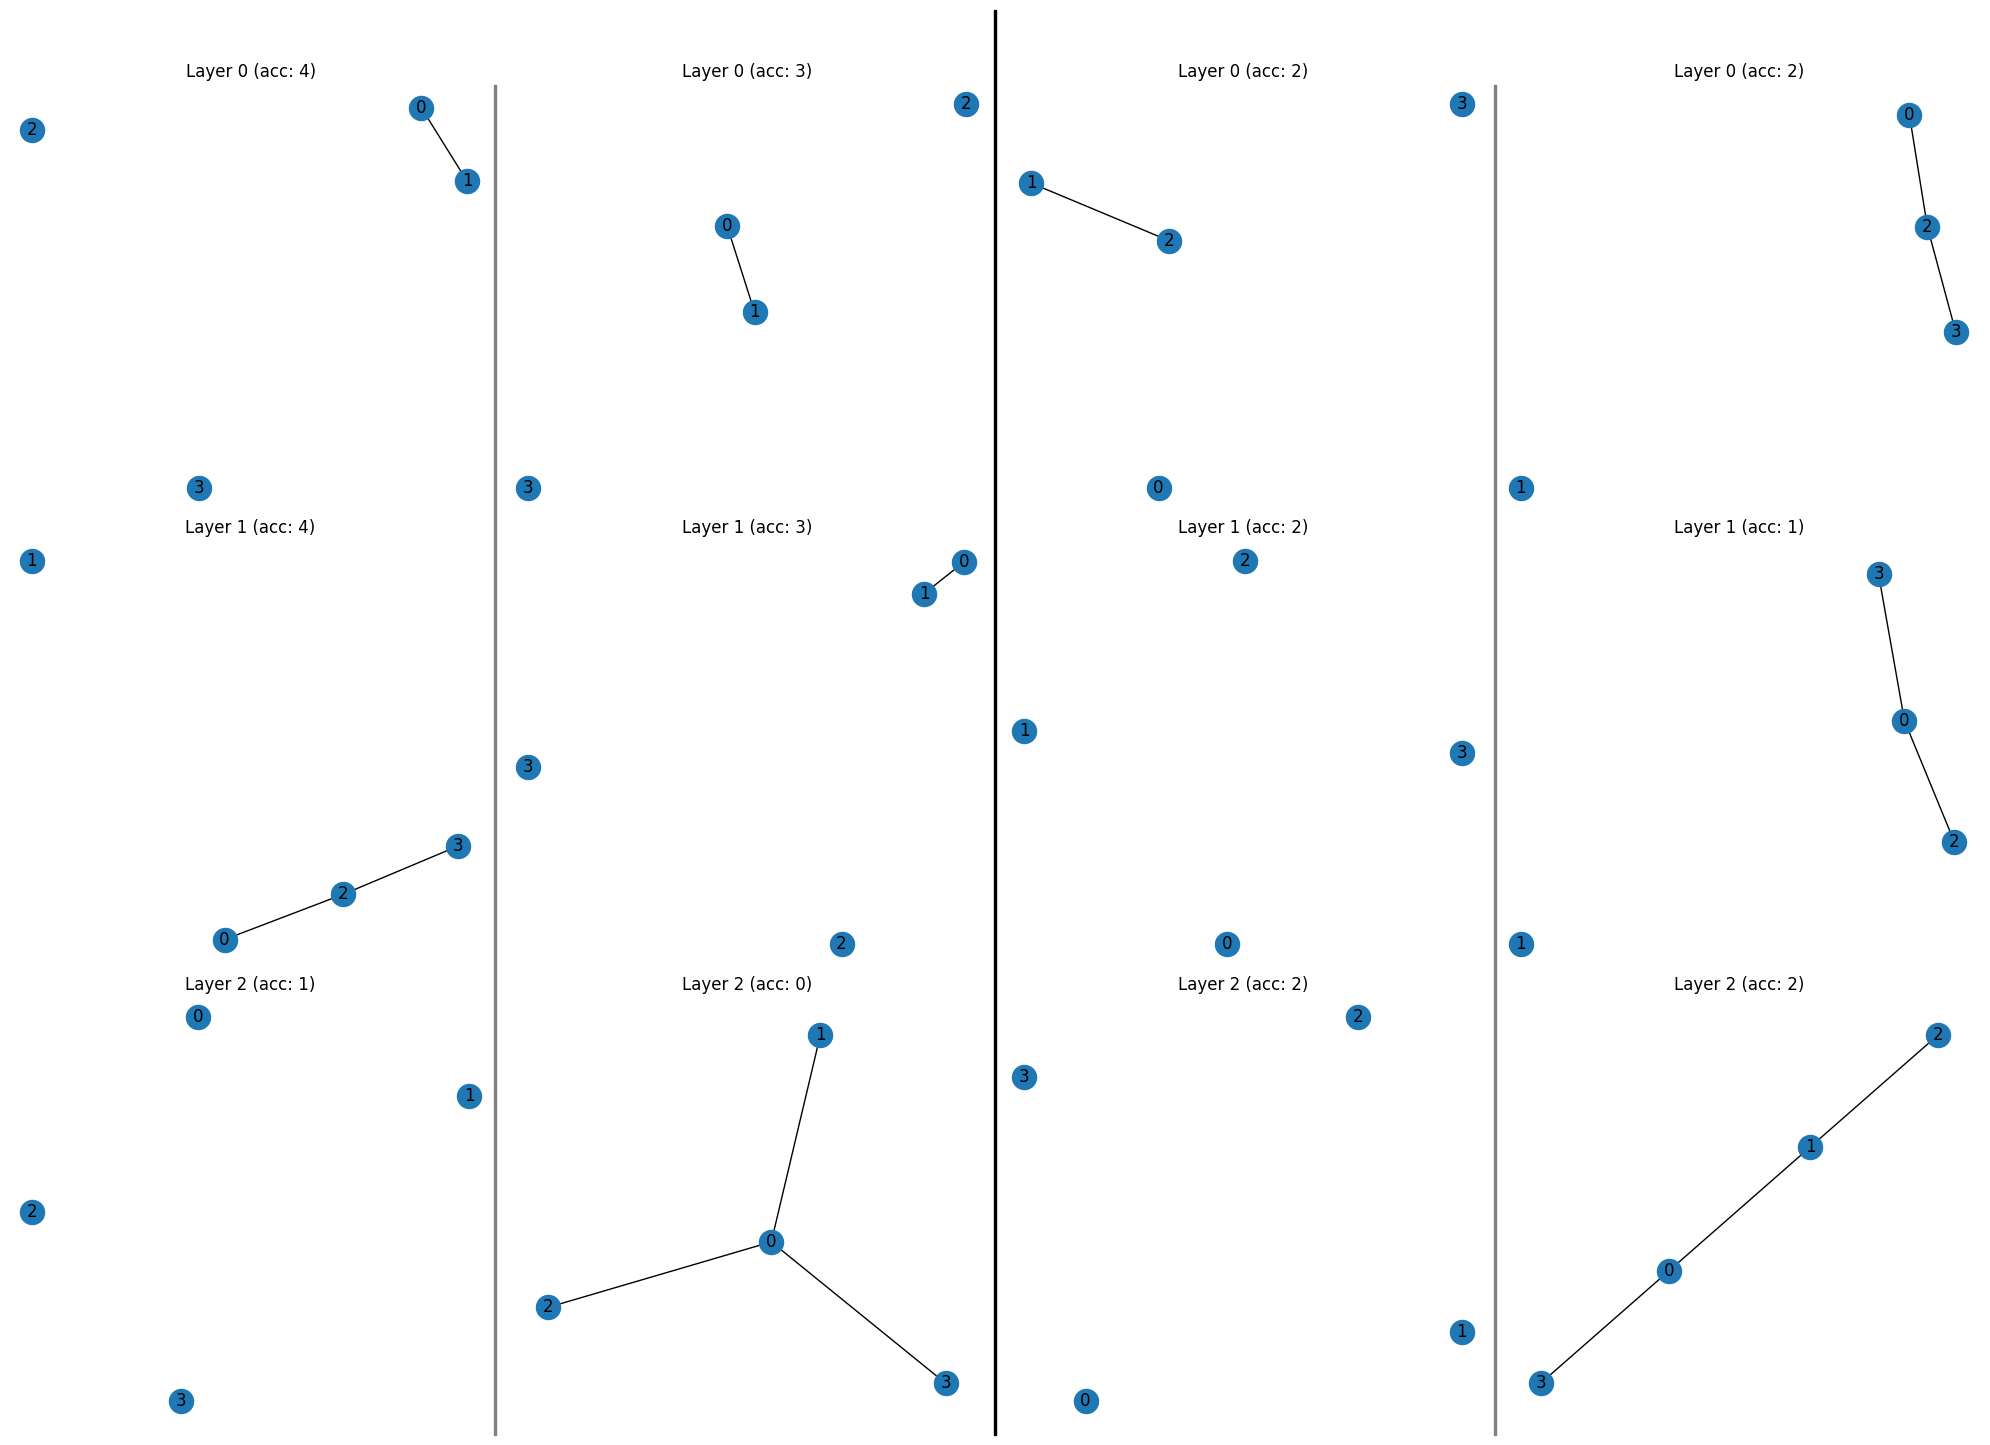

---------------------------------------------------------
5
Perm: (tensor([9, 6, 3, 2, 4]), tensor([10,  3,  6,  4,  2]))
Perm: (tensor([12, 14, 13,  0,  1]), tensor([15, 12, 14, 13,  0]))
Perm: (tensor([3, 6, 9, 2, 4]), tensor([ 6,  4, 10, 15,  7]))
Perm: (tensor([ 6, 16, 15,  0,  4]), tensor([19, 18,  8,  7,  4]))
Perm: (tensor([16, 15,  6, 13,  4]), tensor([19, 18,  8,  7, 11]))
Perm: (tensor([14, 12,  7, 13,  2]), tensor([ 6, 17, 16,  9, 19]))


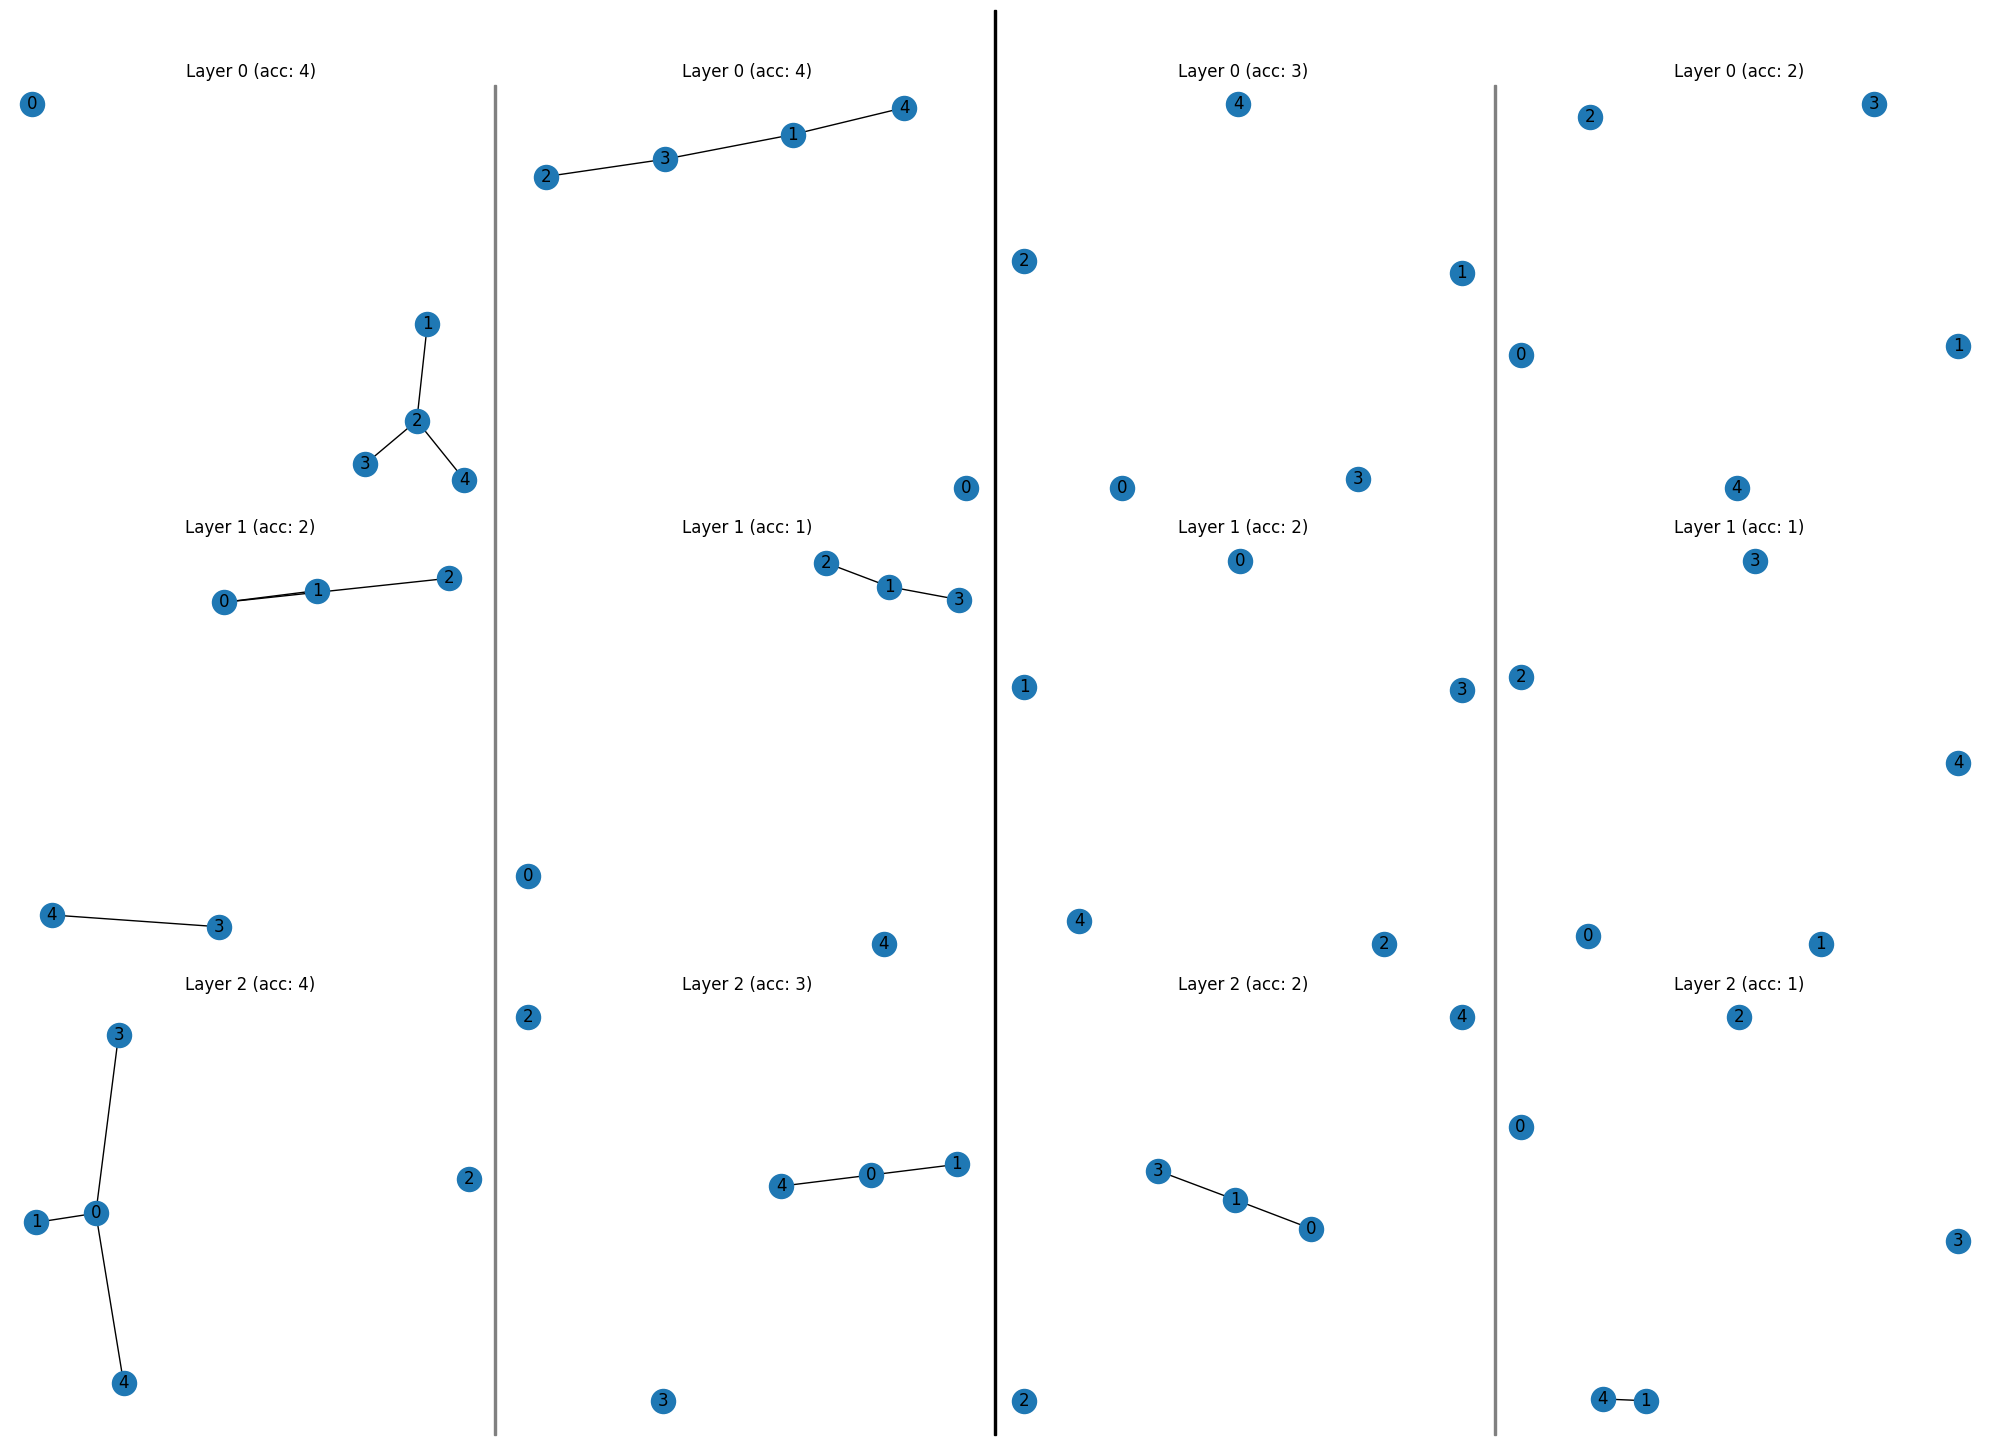

Perm: (tensor([0, 1, 4, 9, 5]), tensor([ 0,  8, 11,  3, 14]))
Perm: (tensor([6, 5, 4, 0, 1]), tensor([17, 13,  6,  1,  4]))
Perm: (tensor([5, 8, 7, 0, 3]), tensor([ 1, 19, 18,  5,  4]))
Perm: (tensor([ 0,  1, 12,  9,  4]), tensor([ 0,  1, 13, 14,  4]))
Perm: (tensor([ 8,  7,  4, 15,  9]), tensor([10, 19,  7,  8, 18]))
Perm: (tensor([6, 5, 9, 8, 7]), tensor([17,  6, 15,  5, 16]))


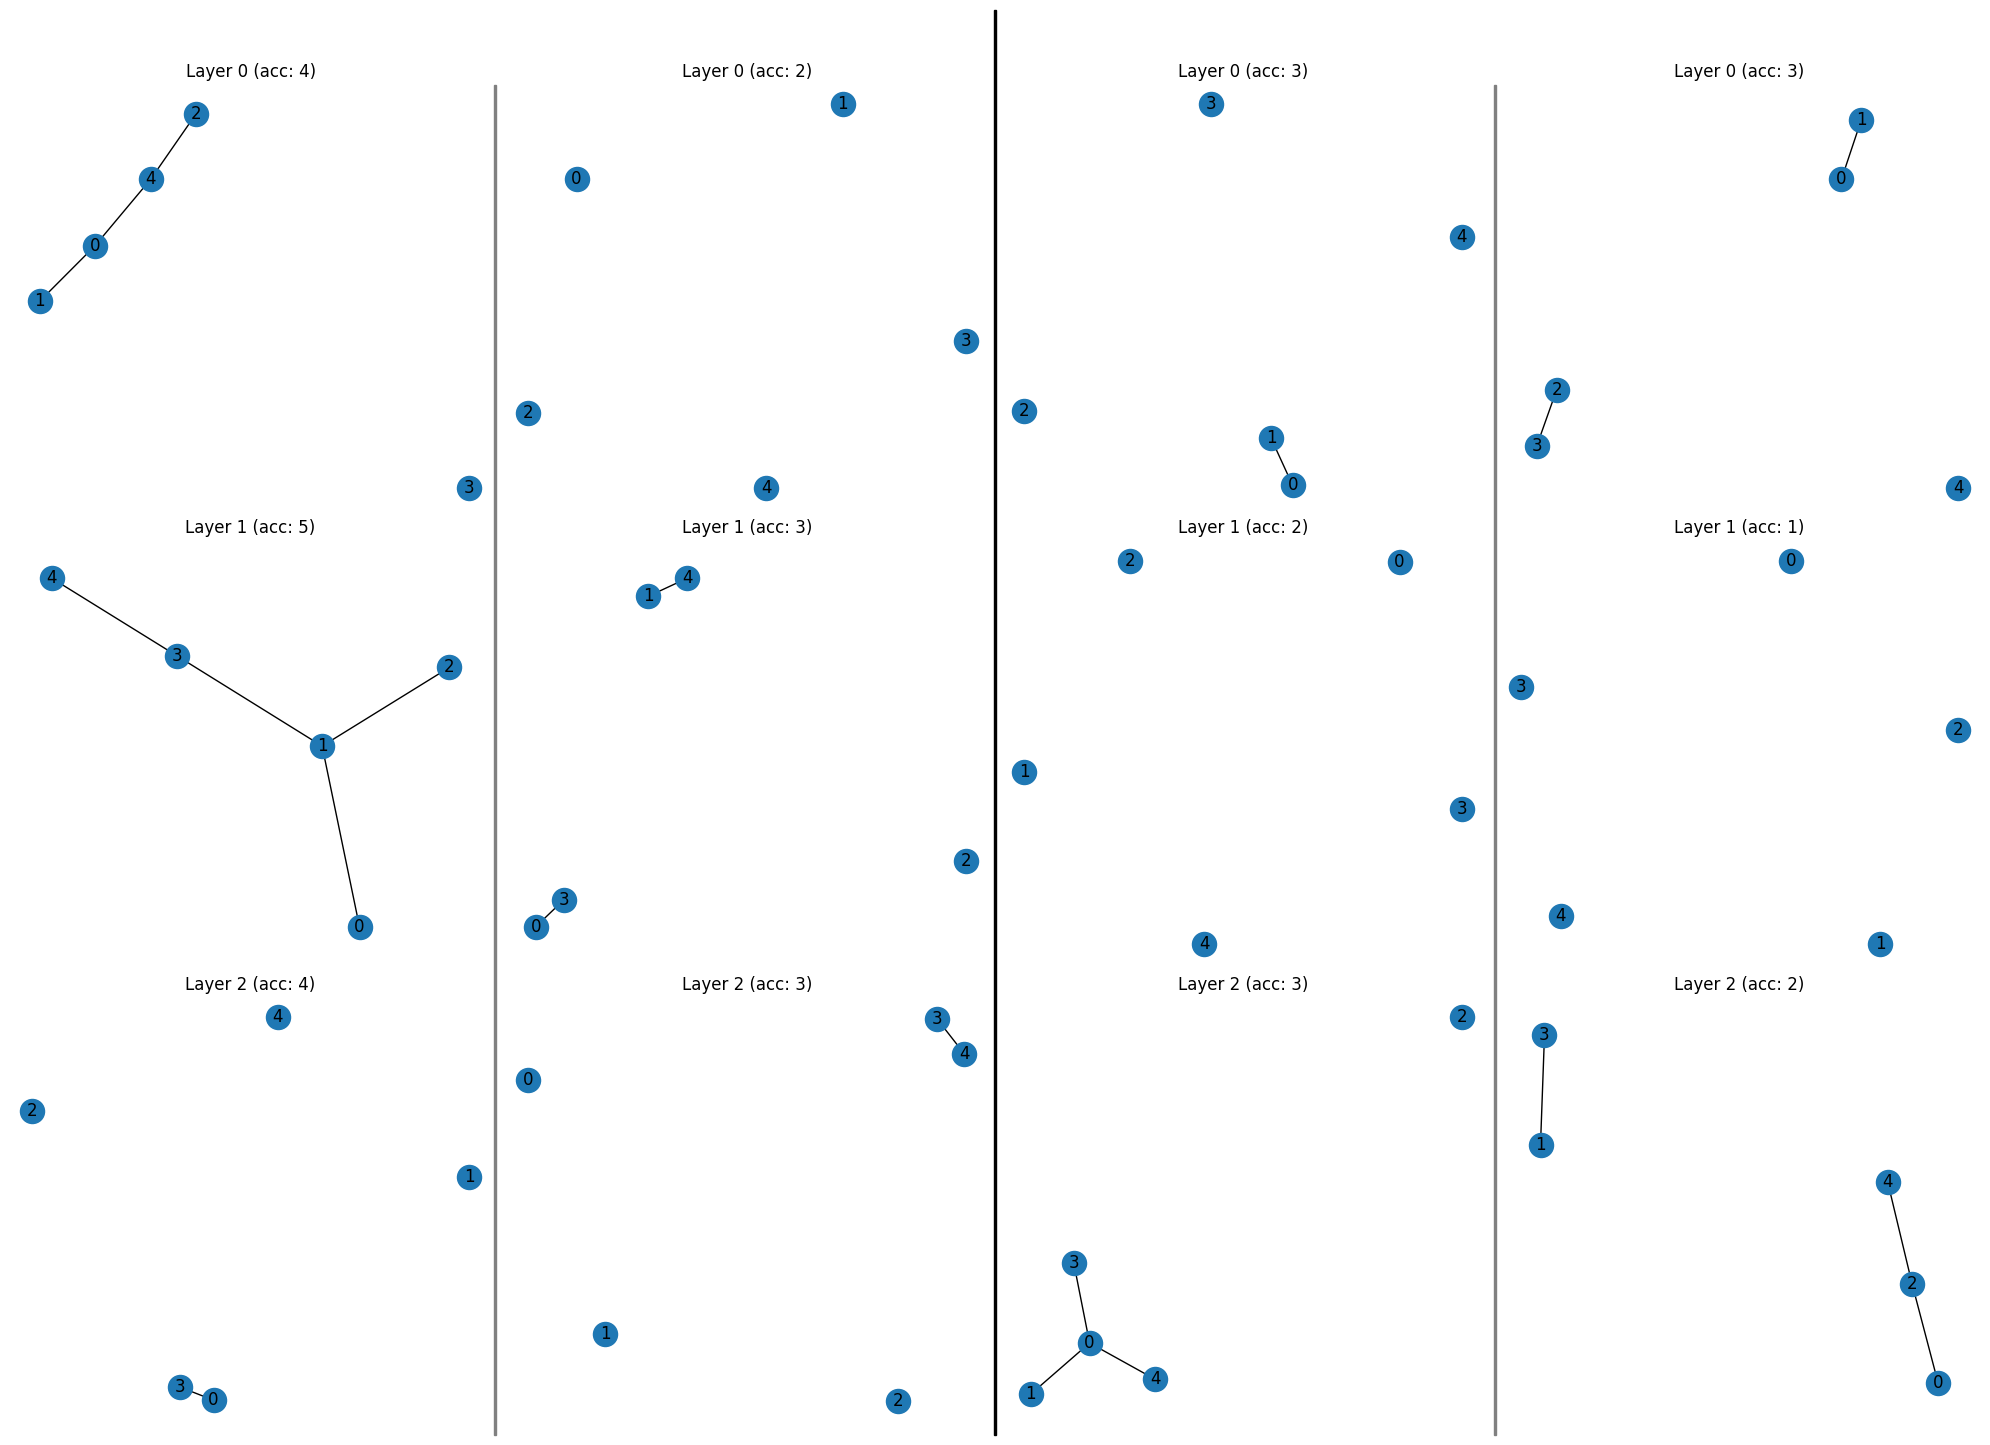

Perm: (tensor([ 1,  3,  8,  5, 10]), tensor([10,  3, 13,  2,  1]))
Perm: (tensor([12, 11, 10,  0,  4]), tensor([15, 14, 12, 11,  2]))
Perm: (tensor([9, 2, 6, 7, 8]), tensor([12,  7,  5, 11,  4]))
Perm: (tensor([ 9, 10,  2, 12, 11]), tensor([13,  6, 14,  3,  4]))
Perm: (tensor([16,  7, 14,  3,  4]), tensor([14,  0,  1,  8,  5]))
Perm: (tensor([ 7, 16, 10, 11, 12]), tensor([16, 15, 10,  9, 11]))


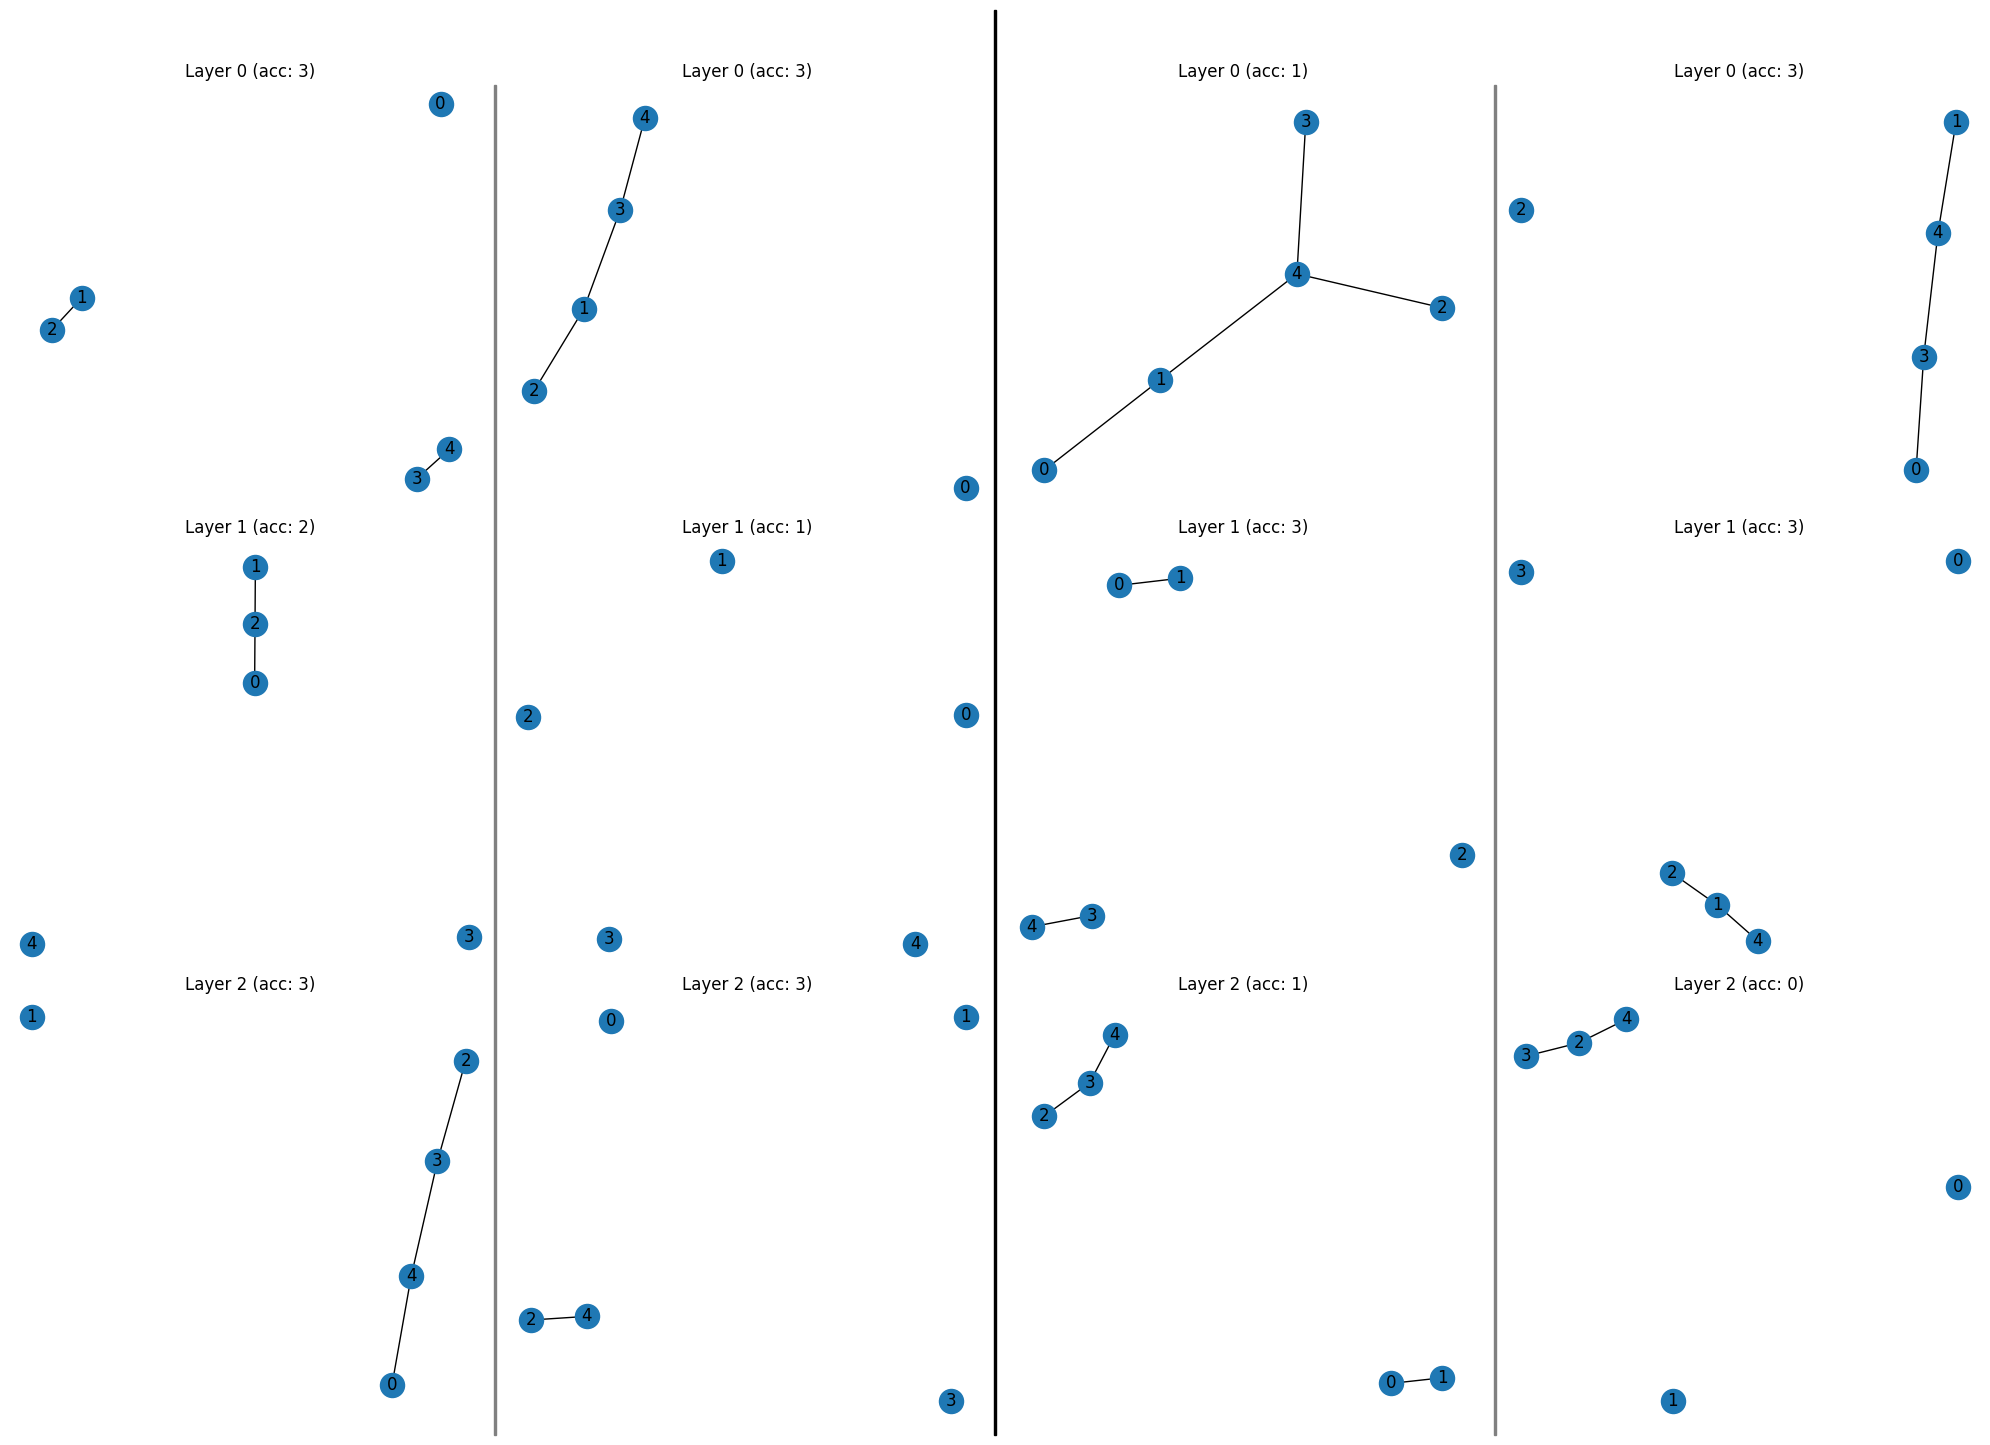

Perm: (tensor([7, 9, 8, 6, 4]), tensor([ 6,  9, 11,  7,  8]))
Perm: (tensor([ 5,  9,  8, 11,  0]), tensor([13,  7,  8, 11, 10]))
Perm: (tensor([10,  1, 11,  0,  2]), tensor([ 2, 13,  1,  0,  4]))
Perm: (tensor([ 0,  1, 14, 13,  4]), tensor([ 0,  1, 15, 13,  4]))
Perm: (tensor([19, 18,  8,  7, 10]), tensor([16, 14,  8,  7,  5]))
Perm: (tensor([17,  6, 19,  8, 18]), tensor([ 6,  8,  7, 13,  0]))


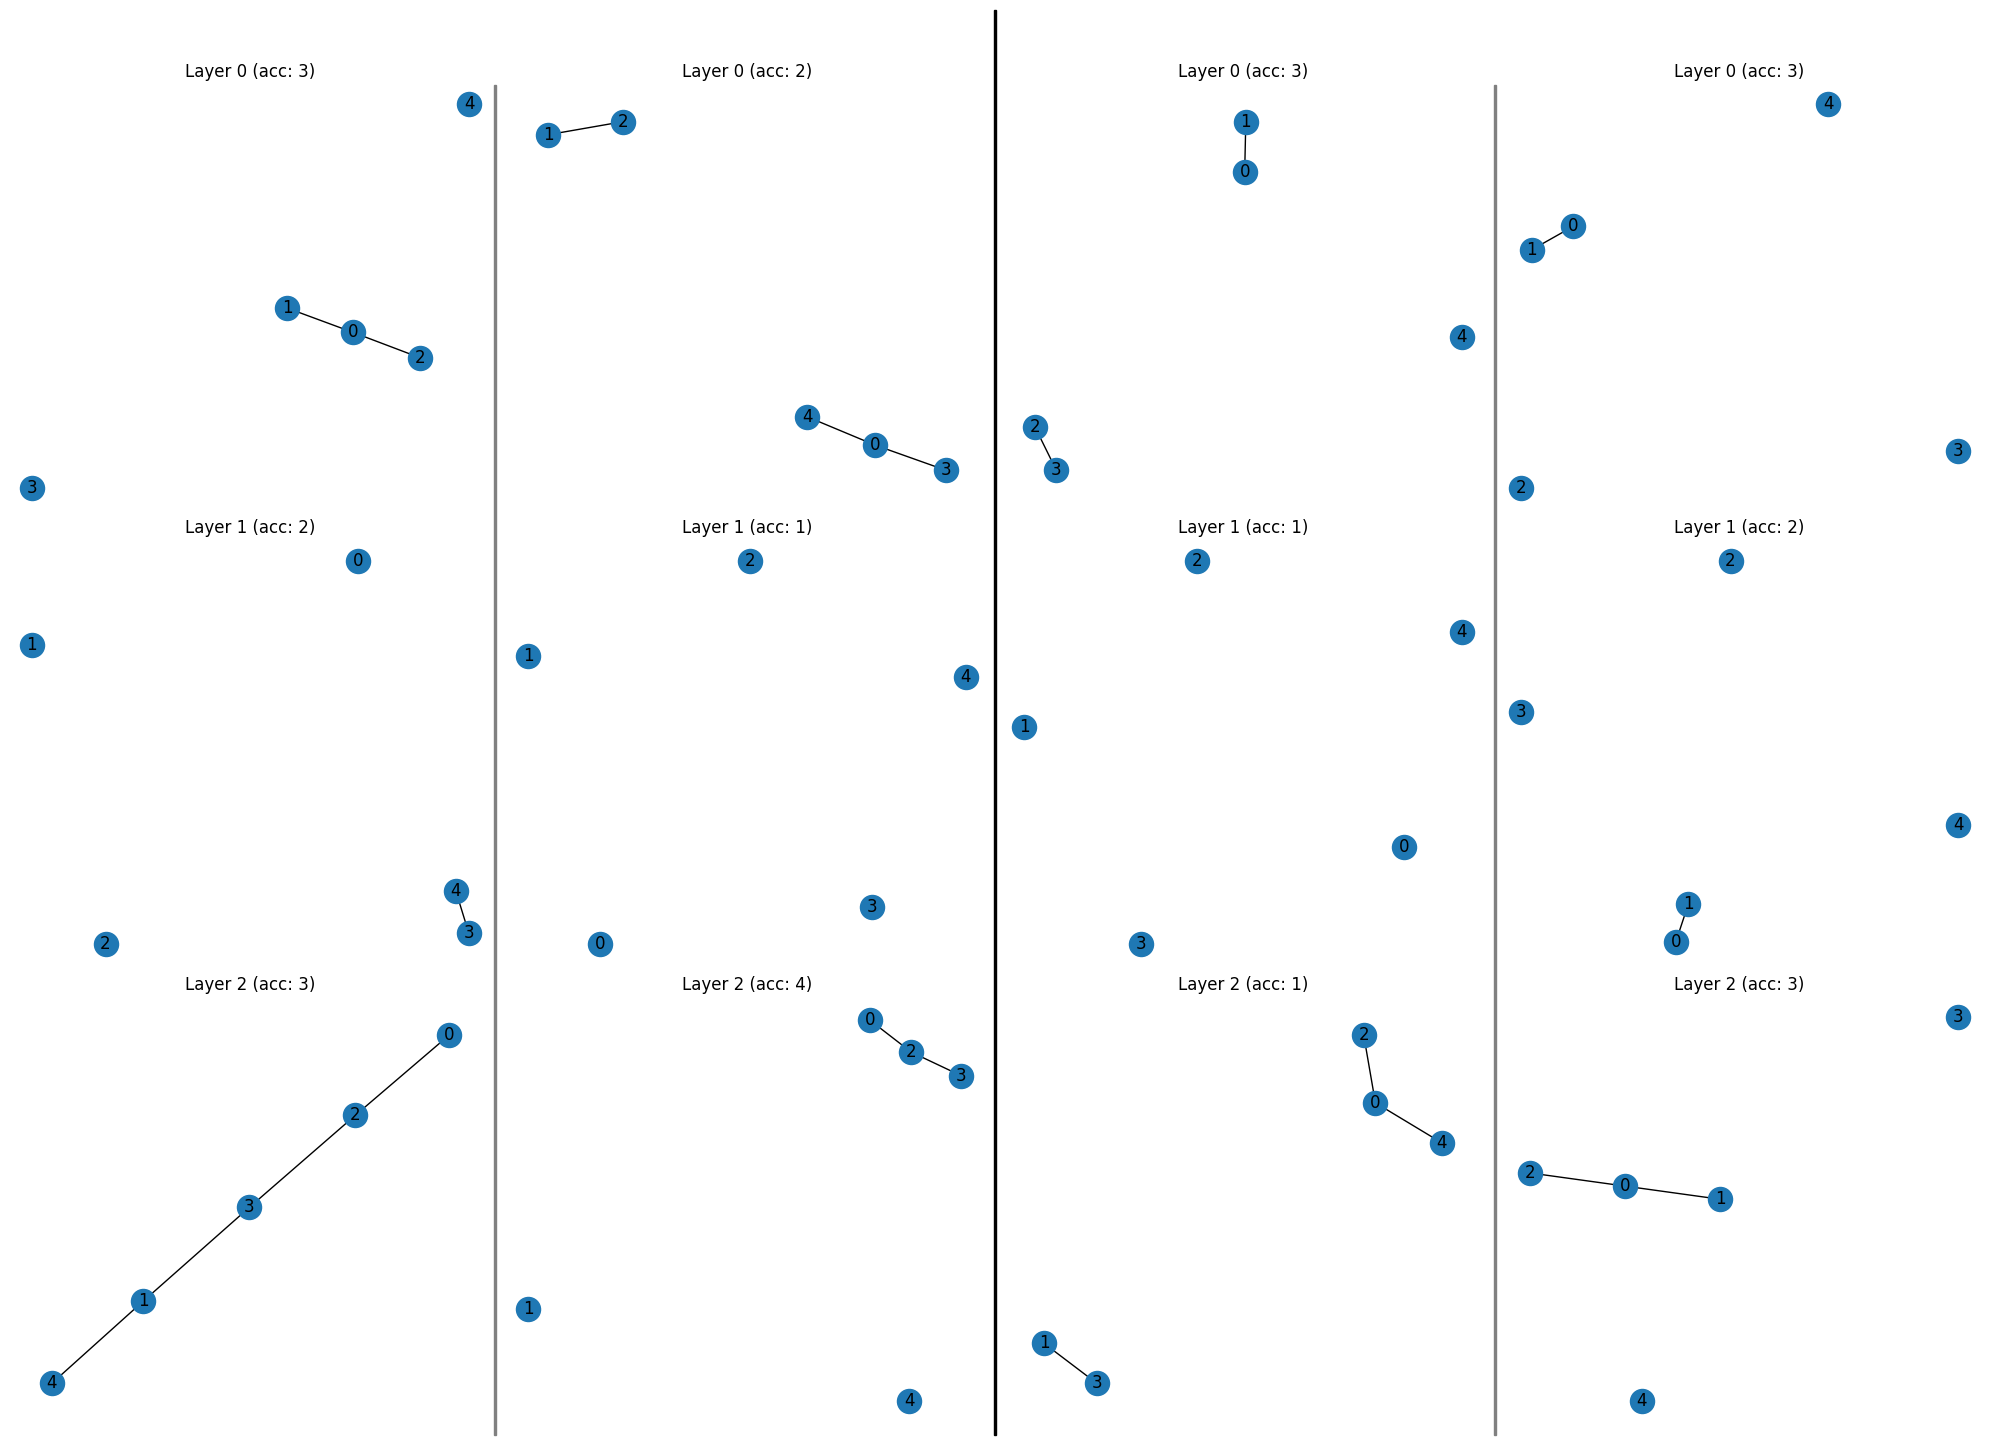

Perm: (tensor([10,  1,  2,  8,  5]), tensor([ 6, 11,  3,  2,  5]))
Perm: (tensor([10,  1,  2,  0,  9]), tensor([ 6, 11, 10,  4,  0]))
Perm: (tensor([12, 11,  0,  5,  9]), tensor([ 8,  7,  5, 10,  1]))
Perm: (tensor([6, 8, 7, 5, 4]), tensor([ 6, 17, 16,  9, 19]))
Perm: (tensor([ 6, 14,  5,  9,  4]), tensor([ 6, 17, 16,  9, 19]))
Perm: (tensor([16, 14, 13,  8,  7]), tensor([12,  5,  3, 10, 15]))


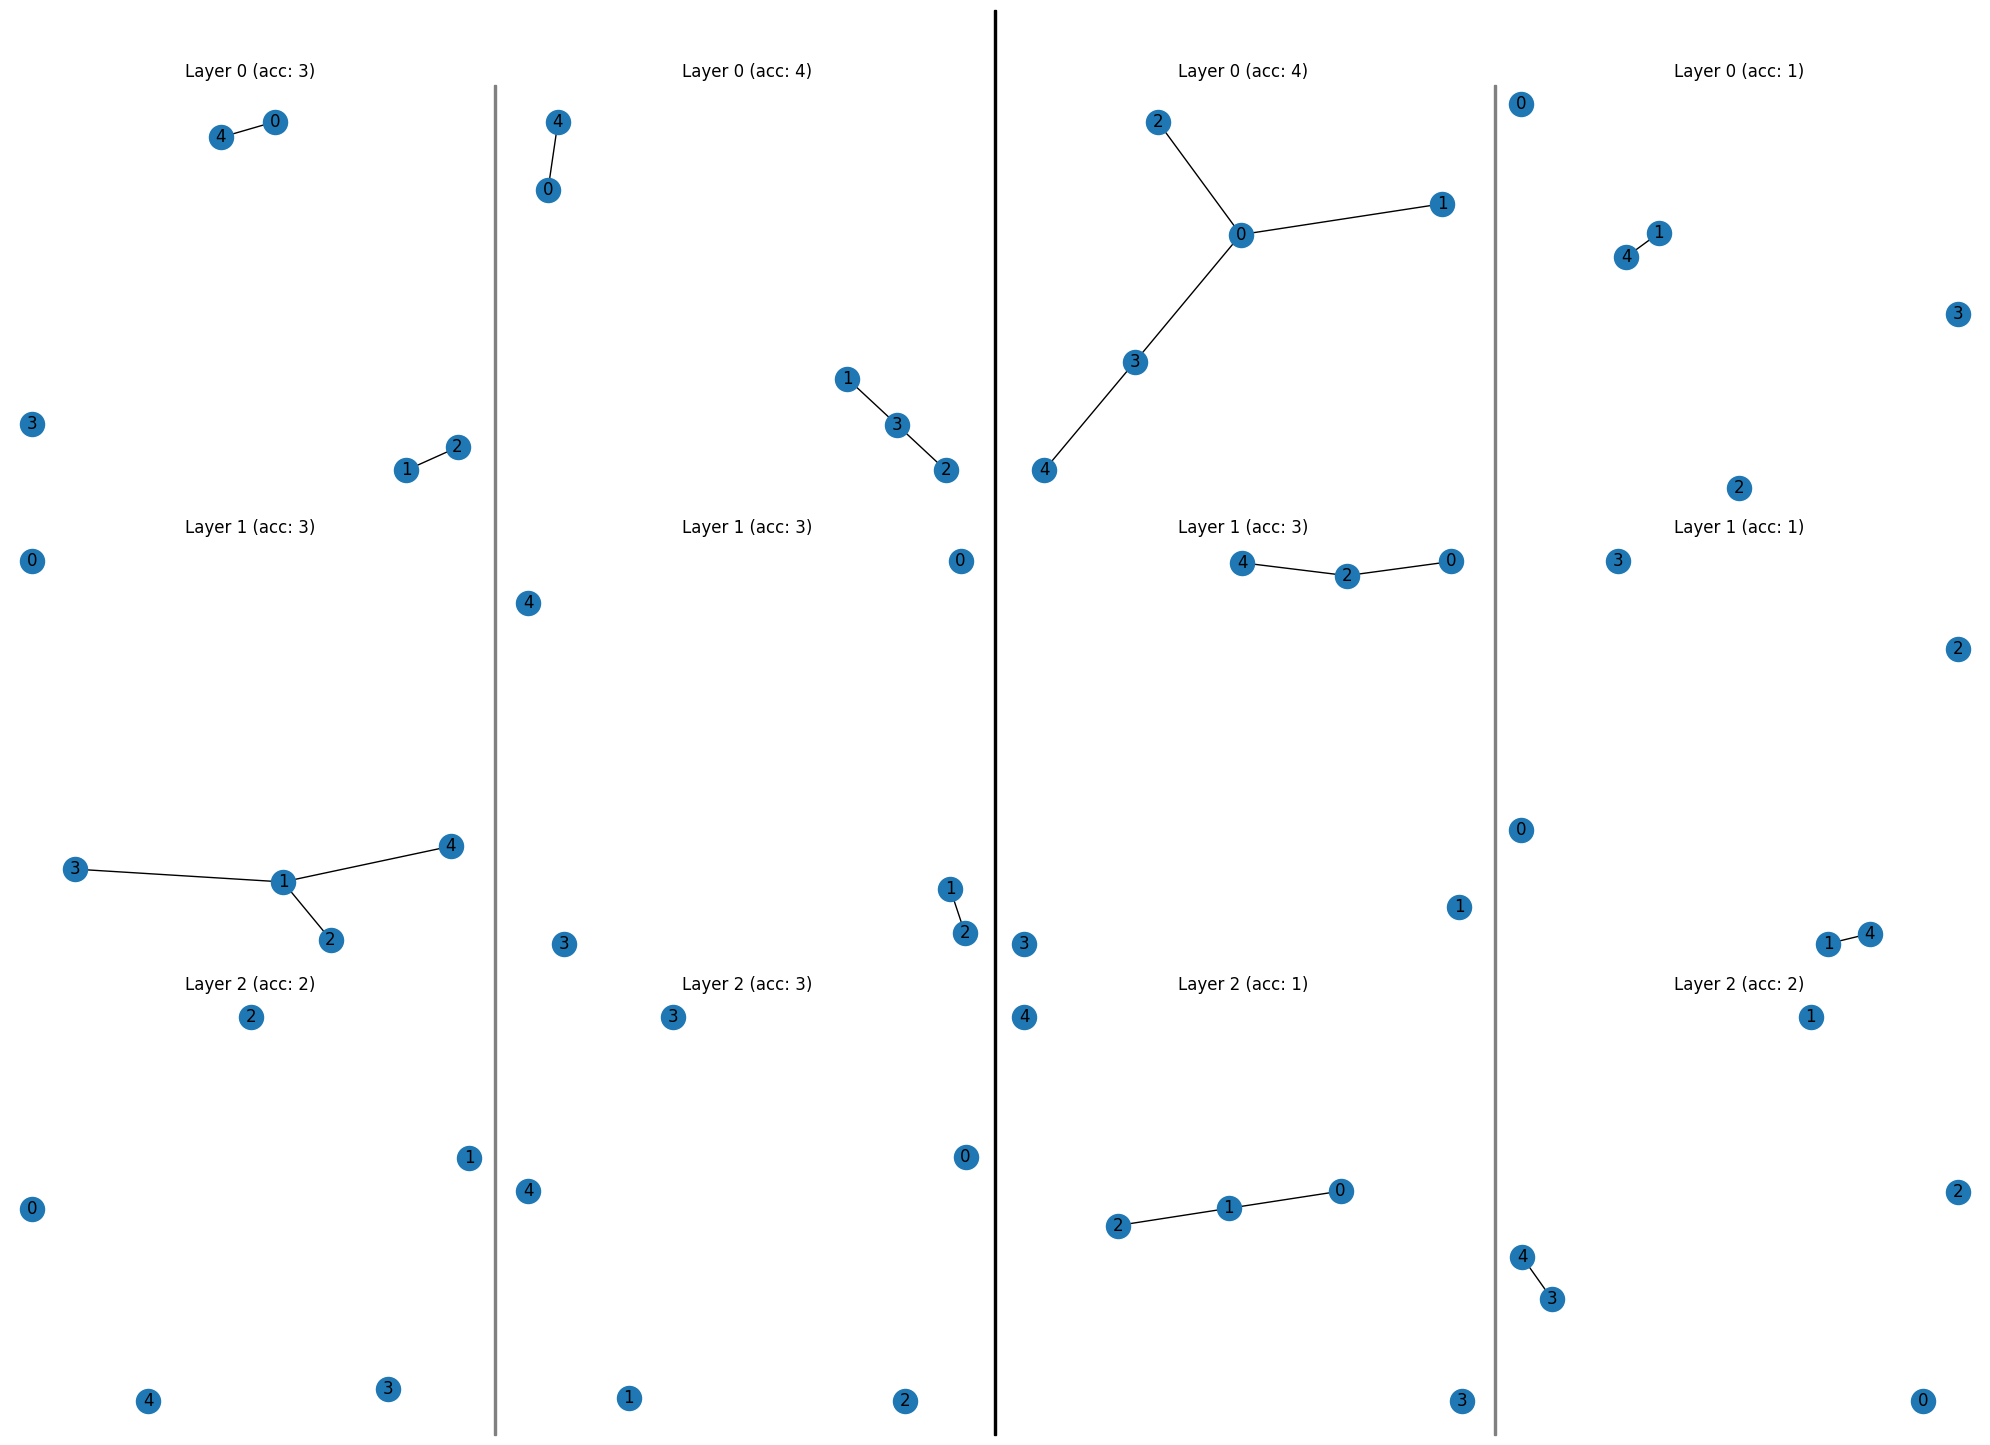

Perm: (tensor([ 0, 10,  9,  6,  4]), tensor([ 0, 13, 12,  3,  4]))
Perm: (tensor([ 3,  2,  9, 10,  7]), tensor([ 1,  2,  7, 13, 12]))
Perm: (tensor([ 8,  1, 12, 10,  9]), tensor([11, 13, 12,  9,  4]))
Perm: (tensor([ 9, 12,  2, 11, 10]), tensor([12, 10,  3,  5,  7]))
Perm: (tensor([ 2,  5,  9, 12,  0]), tensor([10, 12,  3,  5,  0]))
Perm: (tensor([16, 17, 18, 13,  1]), tensor([14, 16, 15, 10, 12]))


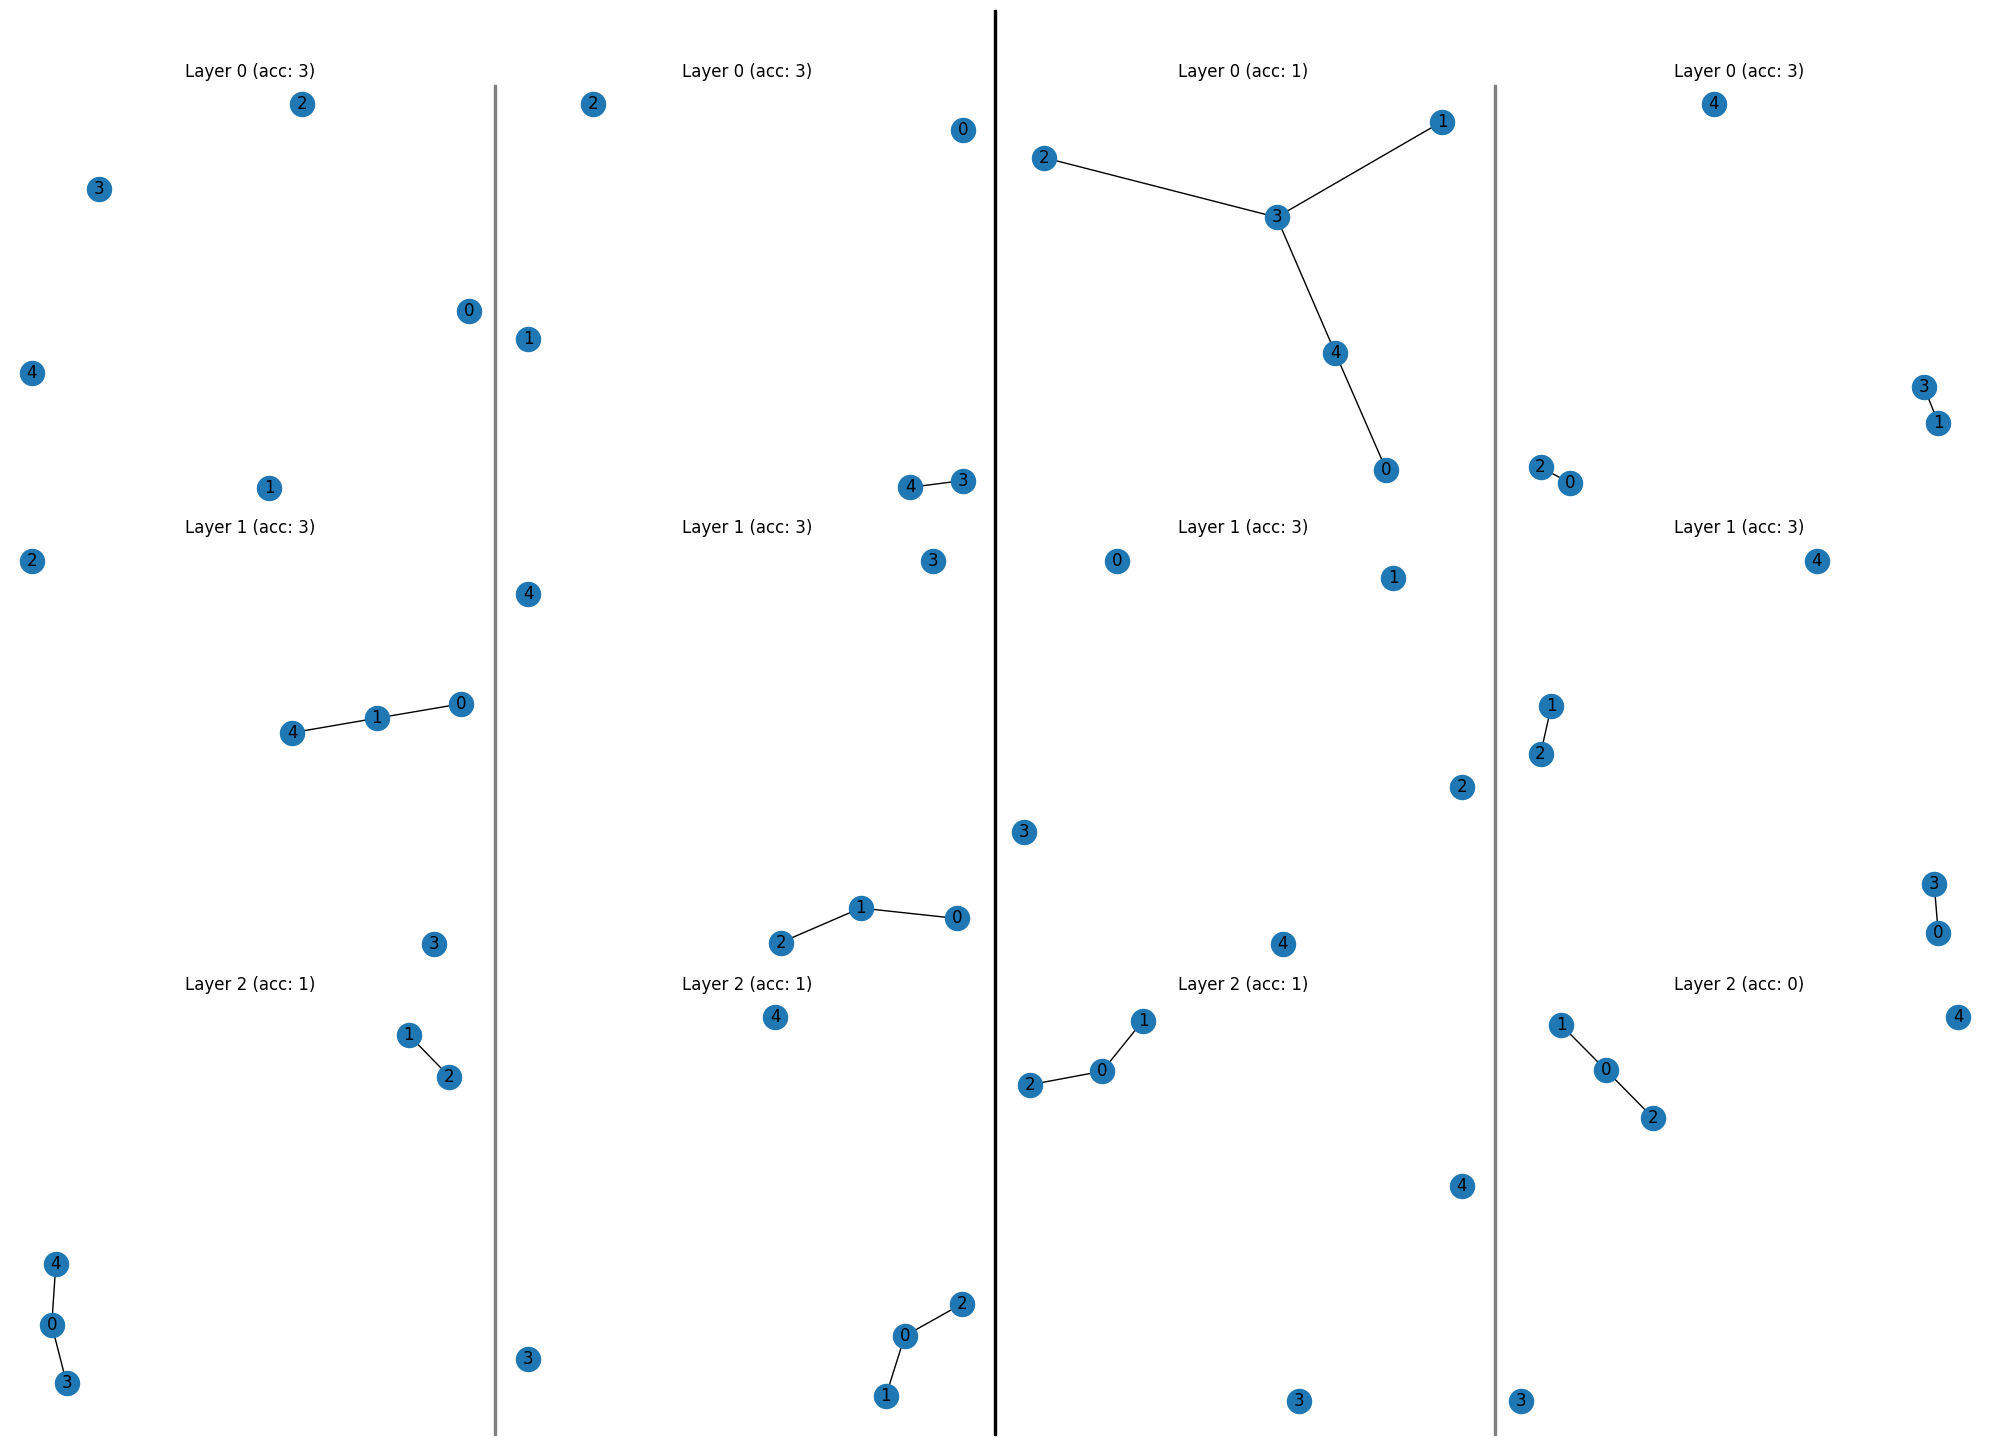

In [9]:
class Args:
    def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs, n_clusters):
        self.dim = dim
        self.feat_dim = dataset.num_features
        self.num_layers = num_layers
        self.margin = margin
        self.lr = lr
        self.n_classes = dataset.num_classes
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = n_clusters
        self.num_pairs = num_pairs


dims = [16, 32]
num_layers = [4, 5, 6, 7, 8]
margins = [0.1, 0.3, 0.5, 1]
lrs = [0.01, 0.001]
batch_sizes = [64, 128, 256]
num_pairs = [10000]
n_clusters = [3, 4, 5, 6, 7, 8, 9, 0.5, 0.6, 0.7, 0.8]

hyperparams = hyperparameters_enzymes[1]
newargs = Args(*(*hyperparams, 8))
m = GraphMatchingNetwork(newargs)
o = Adam(m.parameters(), lr=newargs.lr, weight_decay=1e-5)
p, l = create_graph_pairs(data, newargs.num_pairs)
train(m, o, p, l, newargs.batch_size, str(hyperparams))
for n in n_clusters:
    print(n)
    for _ in range(10):
        test(m, layers=newargs.num_layers, num_classes=newargs.n_classes, k=n)
    print("---------------------------------------------------------")